# Sentiment analysis COVID-19 scholar's articles

# Imports

In [1]:
import os
import json
import pandas as pd
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')
%matplotlib inline
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from  nltk import FreqDist
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.collocations import *
import re
import string
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from wordcloud import WordCloud
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm
import warnings
warnings.filterwarnings('ignore')
style.use('ggplot')
np.random.seed(0)

In [2]:
ls

 Volume in drive C is OS
 Volume Serial Number is D816-28B0

 Directory of C:\Users\luigi\FlatironSchool\personal_project

16/04/2020  13:11    <DIR>          .
16/04/2020  13:11    <DIR>          ..
23/03/2020  14:33    <DIR>          .ipynb_checkpoints
23/03/2020  14:30    <DIR>          biorxiv_medrxiv
23/03/2020  14:13    <DIR>          comm_use_subset
21/03/2020  00:32            26,690 COVID.DATA.LIC.AGMT.pdf
16/04/2020  13:11         3,854,921 COVID-19.ipynb
23/03/2020  14:13    <DIR>          custom_license
21/03/2020  00:37             2,906 json_schema.txt
21/03/2020  00:37             1,574 metadata.readme
23/03/2020  14:14    <DIR>          noncomm_use_subset
               4 File(s)      3,886,091 bytes
               7 Dir(s)  12,079,386,624 bytes free


# See documents README

In [3]:
with open('metadata.readme', 'r') as f:
    data = f.read()
    print(data)

(1) Metadata for papers from these sources are combined: CZI, PMC, BioRxiv/MedRxiv. (total records 29500)
	- CZI 1236 records
	- PMC 27337
	- bioRxiv 566
	- medRxiv 361
(2) 17K of the paper records have PDFs and the hash of the PDFs are in 'sha'
(3) For PMC sourced papers, one paper's metadata can be associated with one or more PDFs/shas under that paper - a PDF/sha correponding to the main article, and possibly additional PDF/shas corresponding to supporting materials for the article.
(4)	13K of the PDFs were processed with fulltext ('has_full_text'=True)
(5) Various 'keys' are populated with the metadata:
	- 'pmcid': populated for all PMC paper records (27337 non null)
	- 'doi': populated for all BioRxiv/MedRxiv paper records and most of the other records (26357 non null)
	- 'WHO #Covidence': populated for all CZI records and none of the other records (1236 non null)
	- 'pubmed_id': populated for some of the records
	- 'Microsoft Academic Paper ID': populated for some of the records


# Create df commercial articles for time series sentyment analysis

In [4]:
directory = ['comm_use_subset']

In [5]:
documents= []
for d in directory:
        for index, file in enumerate(os.listdir(f"{d}/{d}")):
            file_path = f"{d}/{d}/{file}"
            j = json.load(open(file_path, 'rb'))
            for x, y in j['bib_entries'].items():
                title = y['title']
                year = y['year']
                
                documents.append([title, year])
                
df_for_series = pd.DataFrame(documents, columns = ['title', 'year'])

In [6]:
df_for_series.head()

,title,year
0,NDV/HQ266603/Chicken/1992,NaN
1,MuV/FJ375177/Human/1987,NaN
2,HeV/HM044321/Horse/2007,NaN
3,NDV/FJ751918/Chicken/1979,NaN
4,APMV4/EU877976/Duck/2006,NaN


In [7]:
df_for_series.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 508264 entries, 0 to 508263
Data columns (total 2 columns):
title    508264 non-null object
year     495723 non-null float64
dtypes: float64(1), object(1)
memory usage: 7.8+ MB


In [8]:
df_for_series.isnull().sum()

title        0
year     12541
dtype: int64

In [9]:
12541/508264*100

2.4674185069176646

We have 12541 missing values representing the 2.5% of the total data.
Considering that is a relatively small % and that we are not able of obtaining those missing dates I decide to drop the corresponding rows.

In [10]:
df_for_series.dropna(inplace=True)
df_for_series.isnull().sum()

title    0
year     0
dtype: int64

In [11]:
df_for_series.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 495723 entries, 14 to 508263
Data columns (total 2 columns):
title    495723 non-null object
year     495723 non-null float64
dtypes: float64(1), object(1)
memory usage: 11.3+ MB


In [21]:
df_for_series['year'] = df_for_series['year'].astype('int')

In [23]:
df_for_series['year'] = pd.to_datetime(df_for_series['year'], unit='Y')
df_for_series.tail()

ValueError: cannot cast unit Y

# Sentiment analysis

In [12]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\luigi\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [13]:
sid = SentimentIntensityAnalyzer()

In [14]:
compound_list = []
for x in df_for_series['title']:
    ss = sid.polarity_scores(x)
    compound_list.append(ss['compound'])

KeyboardInterrupt: 

In [ ]:
df_for_series['compound'] = compound_list
df_for_series.head()

In [ ]:
df_for_series.tail()

In [ ]:
len(df_for_series)

In [ ]:
#df_for_series = df_for_series[df_for_series.index <= '2020.0']

In [ ]:
df_for_series['year'].describe()

In [20]:
df_for_series.set_index('year', inplace=True)
df_for_series.head()

,title,compound
year,,
1991.0,The dendritic cell system and its role in immu...,0.0000
2000.0,Immunobiology of dendritic cells,0.0000
2013.0,The CD4-centered universe of human T cell subsets,0.0000
1996.0,Ligation of CD40 on dendritic cells triggers p...,0.4019
1996.0,High level IL-12 production by murine dendriti...,0.0000


In [21]:
df_for_series = df_for_series.sort_index()
df_for_series.head()

,title,compound
year,,
1900.0,Bioterrorism and Biocrimes: The Illicit Use of...,0.0000
1900.0,Trends in recorded influenza mortality: United...,0.4215
1900.0,The changing epidemiology of yellow fever and ...,0.0000
1900.0,Host cell manipulation by human pathogen Toxop...,-0.2960
1900.0,Public health interventions and SARS spread,0.0000


In [22]:
df_for_series['compound'].describe()

count    495723.000000
mean         -0.018581
std           0.254947
min          -0.960700
25%           0.000000
50%           0.000000
75%           0.000000
max           0.965700
Name: compound, dtype: float64

In [23]:
target_list = []
for x in df_for_series['compound']:
    if x < -.25:
        target_list.append(-1)
    elif x > .25:
        target_list.append(1)
    else: 
        target_list.append(0)

In [24]:
df_for_series['target'] = target_list
df_for_series.head(20)

,title,compound,target
year,,,
1900.0,Bioterrorism and Biocrimes: The Illicit Use of...,0.0000,0
1900.0,Trends in recorded influenza mortality: United...,0.4215,1
1900.0,The changing epidemiology of yellow fever and ...,0.0000,0
1900.0,Host cell manipulation by human pathogen Toxop...,-0.2960,-1
1900.0,Public health interventions and SARS spread,0.0000,0
1900.0,The epidemiological transition in Antananarivo...,-0.5994,-1
1900.0,Ten great public health achievements-United St...,0.6249,1
1900.0,Disaster Trends,-0.6249,-1
1900.0,The Thompson Indians of British Columbia,0.0000,0


In [25]:
import seaborn as sns

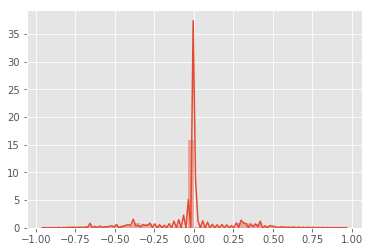

In [26]:
sns.distplot(compound_list);

In [27]:
df_time_series = df_for_series[['compound']].copy()
df_time_series.tail()

,compound
year,
2020.0,0.3182
2020.0,0.0000
2020.0,0.3182
2044.0,-0.1027
2081.0,0.0000


Drop outliers

In [28]:
df_time_series.drop(df_time_series.tail(2).index,inplace=True) # drop last n rows
df_time_series.tail()

,compound
year,
2020.0,0.0000
2020.0,0.3182
2020.0,0.3182
2020.0,0.0000
2020.0,0.3182


In [29]:
#df_time_series = df_time_series.loc[df_time_series.index < '2020.0']

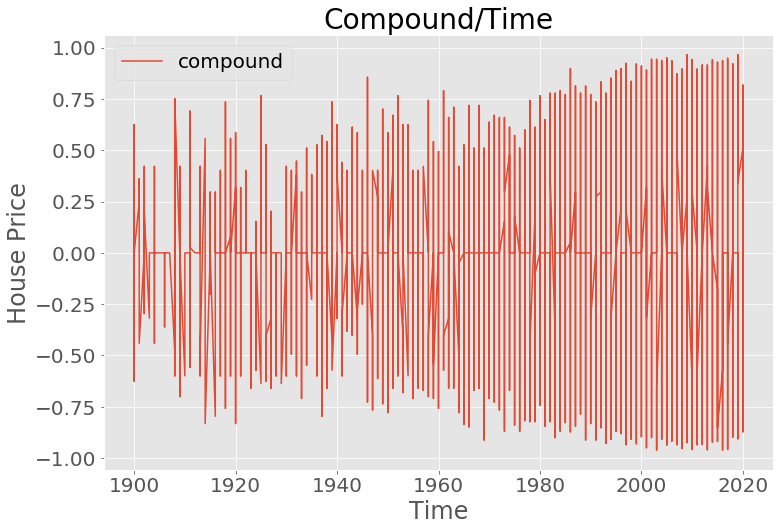

In [30]:
df_time_series.plot(kind='line', figsize=(12,8))
plt.title('Compound/Time', fontsize=28)
plt.xlabel('Time', fontsize=24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel('House Price', fontsize=24)
plt.legend(fontsize=20);

# ARIMA

In [113]:
df_time_series['date'] = pd.to_datetime(df_time_series.index, unit='M')
df_time_series.tail()

ValueError: cannot cast unit M

In [102]:
def arimamodel(timeseries):
    '''
     Creating the model: automatic ARIMA using ADF to test stationarity, 
     start values for p and q are set to 1, and the crypto data is not assumed to be seasonal 
 
     Args: 
         timeseries: Pandas timeseries with closing price 
         
     Returns: 
         automodel: automatic ARIMA model
    '''
    automodel = pm.auto_arima(df, 
                              start_p=1, 
                              start_q=1,
                              test="adf",
                              seasonal=False,
                              trace=True)
    return automodel

In [103]:
def plotarima(n_periods, timeseries, automodel):
    ''' 
    Plot ARIMA forecast using statsmodel’s plot_predict, 
        filling the area between the upper and lower prediction bounds.
    
    Args: 
        n_periods: steps for the forecast
        timeseries: Pandas timeseries with closing price 
        automodel: automatic ARIMA model
    '''
    # Hourly index
    fc_ind = pd.date_range(df.index[df.shape[0]-1], 
                           periods=n_periods, freq="h")
    # Forecast series
    fc_series = pd.Series(forecast[0], index=fc_ind)
    # Upper and lower confidence bounds
    lower_series = pd.Series(forecast[2][:,0], index=fc_ind)
    upper_series = pd.Series(forecast[2][:,1], index=fc_ind)
    # Create plot
    plt.figure(figsize=(20,10))
    plt.plot(df)
    plt.plot(fc_series, color="blue")
    plt.xlabel("date")
    plt.ylabel(df.name)
    plt.fill_between(lower_series.index, 
                     lower_series, 
                     upper_series, 
                     color="k", 
                     alpha=0.25)
    plt.legend(("past", "forecast", "95% confidence interval"),  
               loc="upper left")
    plt.show();

In [106]:
automodel = arimamodel(df_time_series)

ValueError: could not convert string to float: 'human type 1 DM. The aim of this study was to evaluate changes in fecal microbiota and fecal unconjugated BAs profile in dogs with naturally-occurring DM during insulin therapy and compare them to healthy control dogs (HC).\n\nTo this aim, naturally-passed fecal samples and left over serum samples obtained for diagnostic proposals from 17 adult dogs with DM were collected. Fecal samples from 16 clinically healthy dogs were used as a control population. In addition, serum folate, cobalamin and cTLI were assessed in the DM group to exclude the presence of other causes of dysbiosis; for each DM dog, the fed diet was known and the use of antibiotic within the previous 12 months was excluded.\n\nDNA was extracted from each fecal sample prior to quantitative PCR (qPCR) analysis. Data for 8 bacterial groups was compiled to calculate a microbiota dysbiosis index (DI). Concentrations and proportions of fecal unconjugated primary (cholic/chenodeoxycholic) and secondary (litho/deoxy/ursodeoxycholic) BAs were measured using a gas chromatography mass spectrometry platform. Unpaired t test and Mann-Whitney U test compared median values between HC and DM dogs with significance set at P < 0.05.\n\nMedian DI was statistically different between HC and DM dogs (HD −5.3 vs DM -1,5; P = 0.0019;). A negative dysbiosis index (DI), indicative of normobiosis, was present in 82% of DM dogs. Four dogs in the DM were dysbiotic (DI index >0). TLI, folate and cobalamin concentrations were normal in all dogs with DM, though two dogs had cobalamin levels <350 ng/L. There was no significant difference between groups for total BAs and proportion of secondary BAs (respectively P = 0.1124 and P = 0.5814).\n\nThe results of this preliminary study did not confirm the association Naturally passed feces were collected from 17 healthy kittens that did not receive antibiotics (Group 1), 14 kittens that received amoxicillin/clavulanic acid for 20 days (Group 2), and 13 kittens that received doxycycline for 28 days (Group 3) as part for standard treatment of upper respiratory tract infection. Kittens were approximately 2 months of age, on the same diet and the same antiparasitic treatment prior to sample collection. Fecal samples were collected on days 0 (before antibiotic treatment), 20 or 28 (Group 2 and Group 3, respectively; after the end of antibiotic administration), and 60. DNA was extracted from each sample and qPCRs were performed for total bacteria, Turicibacter spp., Faecalibacterium spp., Streptococcus spp., Escherichia coli (E. coli), Blautia spp., Fusobacterium spp., Clostridium hiranonis (C. hiranonis), and Bifidobacterium spp. The data were tested for normal distribution and appropriate statistical analyses were used for either repeated or independent measurements. Statistical significance was set at p < 0.05 and correction for multiple comparisons was used where appropriate.\n\nOn day 0, no significant differences were identified among the 3 groups. On day 20, there were significant increases in E. coli (p = 0.003) and decreases in total bacteria (p = 0.002), Blautia (P = 0.0038), C. hiranonis (P = 0.026), and Faecalibacterium (p = 0.031) in group 2 compared to group 1. On day 60, E.coli (P = 0.012) was significantly increased in group 3 compared to group 1. In group 1 E. coli significantly decreased (P < 0.0001) and Faecalibacterium significantly increased (P = 0.023) over time. In group 2, total bacteria (P = 0.014) Destruction of the intestinal barrier and microbiota dysbiosis especially around the time of weaning represent important mechanisms for allergic sensitization. Consequently, 42% of young dogs surviving a canine parvovirus (CPV) infection develop chronic gastrointestinal disorders later in their lives, but it is unknown if adult dogs with severe intestinal lesions also have an increased risk for developing chronic gastrointestinal disorders. The aim of this study was to evaluate, whether dogs with acute hemorrhagic diarrhea syndrome (AHDS) have a higher prevalence of chronic enteropathies later in life.\n\nForty dogs diagnosed with AHDS, for which a follow-up of at least 12 months was available, were included in the study. A historical control group of 67 dogs without history of gastroenteritis was included to enable risk assessment. Dog owners were asked to complete a questionnaire. The percentage of dogs with signs of chronic enteropathies in both groups were compared using Fisher\'s exact test.\n\nThere was no significant difference between AHDS and control dogs concerning development of chronic enteropathies (AHDS 22.5%; controls 12.0%; P = 0.177) during their observation time (AHDS: median 4 years, range 1-12 years; controls: median 5 years, range 1-12 years).\n\nThe results of this study suggest that dogs that experience an episode of AHDS do not have an increased risk for developing chronic gastro- Sixteen dogs in stage B2 MMVD were included in this prospective interventional study. Echocardiograms were performed at presentation and 3 hours following a single-dose pimobendan. Twodimensional, M-mode, and Doppler images were recorded from the right parasternal and left apical standard views. In all dogs, left atrial volume was measured using the biplane area-length method at three time-points: immediately before MV opening, at onset of P-wave, and at MV closure. Reservoir, conduit and active pump functions were calculated, as previously described. In ten dogs, MV regurgitation volume was calculated by subtracting the forward stroke volume (Aortic outflow velocity time integral multiplied by the aortic cross-sectional area) from the total left ventricular (LV) stroke volume (End-systolic LV volume subtracted from the end-diastolic LV volume, both measured using Simpson\'s method of discs). MV regurgitation fraction was calculated as the percentage of regurgitation volume from the total stroke volume. Paired Student t-test and Wilcoxon Signed-Rank Test were used to compare the results.\n\nCompared with baseline, LA volume was significantly lower on postpimobendan measurements immediately before MV opening (P < 0.01), at P-wave onset (P < 0.01) and at MV closure (p = 0.02).\n\nHowever, LA conduit, reservoir and active pump functions did not change significantly. MV regurgitation fraction post-pimobendan (27.7 +/− 5.3) was significantly lower (p < 0.01) compared with baseline (43.7 +/− 4.7), forward stroke volume was significantly increased (P = 0.015), while total stroke volume did not change significantly.\n\nThis study suggests that despite an acute reduction in LA volume, pimobendan may not exert a measurable effect on LA function. The beneficial decrease in left atrial volume appears to result from an acute reduction in MV regurgitation fraction. The mechanisms by which pimobendan reduces regurgitation fraction are thought to be associated with improved forward flow secondary to its inotropic and vasodilatory effects, in addition to reduced end-diastolic LV dimension, minimising secondary functional mitral regurgitation.\n\nNo disclosures to report.\n\nRetrospective evaluation of the safety and tolerability of pimobendan in cats with obstructive versus nonobstructive hypertrophic cardiomyopathy normal echocardiographic exam, normal blood pressure (systolic pressure < 160 mmHg) and euthyroid were included in the study. Cats with normal diastolic thickness of the left ventricle, but isolated basal septal hypertrophy (IBSH) ≥6 mm or SAM, were also included. The AoSA was measured from the right parasternal five chambers view, based on the published guidelines in the dog. A total of 316 cats were examined, 122 fulfilled the inclusion criteria. A left parasternal SM was found in 39 cats (32%). In 10 cats the murmur was audible only after stressed auscultation. SM were associated with a narrower AoSA (P < 0.001), higher prevalence of IBSH (P < 0.01) and higher AoV (P < 0.001), compare to cats without a murmur. The IBSH increases with aging, with an increase of 0,11 mm per year. The AoSA decreases with aging (P < 0.001), with a reduction of 0.55 per year. The AoSA was narrower in cats with IBSH (P < 0.001) and IBSH was always present in cats with AoSA<120 . The AoSA did not differ between cats with or without SAM (P = 0.853). There was a non-linear correlation between AoSA and AoV. In conclusion AoSA angle and the remodeling of the interventricular septum may be correlated and can be a cause of systolic murmur in apparently healthy cats. These findings resemble the sigmoid septum found in human, which can be considered a morphologic variant of the ventricular septum, age related and associated with a systolic murmur.\n\nNo disclosures to report.\n\nAccuracy of noninvasively determined pulmonary artery pressure in dogs with myxomatous mitral valve disease (MMVD) Eighteen measurement pairs were therefore used for comparison of PASP_C and PASP_D through Bland-Altman analysis and linear regression. A statistically significant bias between PASP_C and PASP_D (mean difference = 0.5 mmHg; Confidence interval: −6.5 mmHg, +7.5 mmHg) was not detected. The limits of agreement between the techniques were wide (−27.3 mmHg, +28.2 mmHg). Regression analysis failed to identify a significant linear association between the two techniques (r = 0.11, p = 0.17). In conclusion, PASP_D estimation poorly agrees with PASP_C measurement in dogs affected by MMVD in ACVIM stages B2 and C. In these dogs, PASP_D could under-or over-estimate PASP_C by more than 20 mmHg, and therefore caution should be used when interpreting PASP_D.\n\nDisclosures to report.\n\nMichele Borgarelli receives financial support from Ceva Sante Animale for other work not related to this abstract.\n\nLeft atrial tear in dogs with myxomatous mitral valve diseaseclinical presentation, echocardiographic features and long-term survival In conclusion, dogs with MMVD associated LAT bear a high mortality risk, especially in the first week post the event. However, once survived this critical time, LAT does not seem to significantly impact the long-term survival.\n\nNo disclosures to report.\n\nEchocardiographic evaluation of left ventricular dimension and systolic function before and 24 hours after percutaneous closure of patent ductus arteriosus in 120 dogs M. Claretti 1 , D. Piantedosi 2 , A. Piscitelli 2 , B. Serrano Lopez 1 , E. Boz 1 , L. Mazzoni 1 , A. de Rosa 2 , I. Navalon Calvo 3 , P. Ciaramella 2 , C. Bussadori 1 1 Clinica Veterinaria Gran Sasso, Milano, Italy, 2 Department of Veterinary Medicine and Animal Production, University Federico II, Napoli, Italy, 3 Ars Veterinaria, Barcelona, Spain\n\nOne hundred and twenty dogs were enrolled to value the effect of loading condition changes on left ventricular volumes before and 24-hours after the patent ductus arteriosus (PDA) occlusion by ACDO using standard echocardiography. The animals were divided in pure breed (n. 94) and mixed breed (n. 26); subsequently, the pure breed dogs were divided on the basis of the size of the breed of belonging in 3 groups (small size n. 36; medium size n. 8; large size n. 50). Moreover, the animals were divided in three classes based on their age: until 6 months; 6-12 months; over 12 months. A significant reduction of all the examined parameters (LVIDd, LVIDs, EDV, ESV, EDVI, ESVI, FS) was observed after ductal closure. The evaluation of the relative percentage difference (RDP) of the echocardiographic parameters showed at 24-hours after the closure, a significant reduction higher in small size breed than in large size breed dogs. No significant difference related to breed size was observed only for RPD_FS variable.\n\nA significant interaction effect, between breed size and age classes, was observed only for RPD_EDVI (F = 3.4; P = 0.039). Until six months of age there was no significant difference in RPD_EDVI reduction, but over 6 months a significant reduction between small size and large size breed dogs at 24-hours from the occlusion was observed.\n\nIn conclusion, our data seem to indicate that small breed dogs show a greater tolerance to congenital volume overload, and for this reason it could be possible to delay the PDA closure of a few months allowing weight gain that makes easier the interventional procedure. On the other hand, the large breed dogs should be submitted to ductal closure as soon as possible, in order to avoid an excessive LV wall stress.\n\nNo disclosures to report.\n\nDelayed Electrolyte Depletion and Azotemia in a Furosemide Rate Continuous Infusion Model D. Adin 1 , C. Atkins 2 , H. Ru 2 , G. Wallace 2 1 University of Florida, Gainesville, United States of America, 2 North Carolina State University, Raleigh, United States of America Intravenous furosemide is the mainstay of treatment for acute congestive heart failure in dogs, however, the potential for delayed effects on hydration, electrolytes and renal function have not been studied. This study sought to evaluate these parameters in normal dogs receiving furosemide continuous rate infusion (CRI) with or without renin-angiotensin-aldosterone system inhibitors.\n\nTen healthy dogs were studied in a 3-way randomized, cross-over design. Dogs orally received either placebo, benazepril, or benazepril +spironolactone for 3 days prior to 5-hour furosemide CRI 0.66 mg/ kg/hr. Body weight (BW), renal values, serum electrolytes, packed cell volume and total protein were measured before oral medications, hour 0 and 5 of the furosemide CRI, and hour 24. Variables were compared between time-points and treatments.\n\nLoss of BW during the CRI exceeded recovery at 24 hours and hemoconcentration occurred, with incomplete return to baseline at 24 hours. Blood urea nitrogen and creatinine were unchanged during the CRI but increased 24 AE 12% at 24 hours. Serum sodium did not change during the CRI but decreased at 24 hours. Serum chloride decreased at hour 5 and did not return to baseline at 24 hours. Hypochloremic metabolic alkalosis and increased anion gap present at hour 5 did not normalize at 24 hours. No differences between treatments were found. Some furosemide CRI-related biochemical changes were delayed for 24 hours while others evident at hour 5 only partially improved at hour 24 in these normal dogs. These findings have implications for clinical patients with renal dysfunction, or receiving higher doses or longer furosemide infusions.\n\nDisclosures to report. This study was funded by CEVA Sante Animale. Dr. Adin has received funding from the American Kennel Club Canine Health Foundation for other (unrelated) studies.\n\nChanges in renal endothelin activity with cardiac, renal and other chronic diseases in dogs groups of dogs presented to the R(D)SVS: healthy (n = 18), chronic kidney disease (CKD; IRIS stages 2-4; serum creatinine 257 μmol/l, IQR395; n = 11) cardiac disease (ACVIM classification B1-C; n = 39) and non-cardiorenal chronic disease (n = 14). Urine was free-catch and owner-collected on the morning of appointment. Samples were excluded if they contained active sediment, and were stored at −80 C before batch analysis.\n\nBoth UET-1 and cystatin C were measured by commercial ELISAs and indexed to urinary creatinine concentration (enzymatic method). Comparisons by one-way ANOVA yielded non-transformable residuals so Kruskal-Wallis with Dunn\'s post hoc tests were used (significance P < 0.05).\n\nThere was a marked increase in UET-1 excretion in dogs with stage C heart disease (0.69,IQR 1.61 pg/mg; n = 11) compared to healthy dogs (0.02 pg/mg, IQR 0.11; P = 0.02). UET-1 excretion was also increased in stage B2 heart disease (0.25 pg/mg, IQR 1.70; P = 0.03; n = 19) although to a lesser degree. This was predominantly due to increases in dogs with MMVD (0.38 pg/mg, IQR 1.75; P = 0.046; n = 7) rather than those with non-MMVD cardiac diseases (0.23 pg/mg, IQR 0.91).\n\nal increases in UET-1 in CKD and chronic disease groups were not statistically significant.\n\nBy contrast, CKD markedly increased urinary cystatin C excretion from below limits of detection to (0.53 ng/mg, IQR 2.44; P < 0.0001), while only modest increases (P = 0.03) were observed in dogs with chronic disease (0.02 ng/mg, IQR 0.07), and none at all in heart disease stages B1-C.\n\nRenal ET-1 activity increases with congestive heart failure, but surprisingly, also increases in MMVD before congestion develops. Neither increase is associated with renal injury or is a consequence of a chronic disease state. Renal ET-1 may mediate pathophysiological cardiovascular-renal interactions in MMVD that are different to those in isolated CKD and the development of congestive heart failure.\n\nNo disclosures to report.\n\nHigh grade AV Block and third degree AV Block in cats: a retrospective study of epicardial pacemaker implantation (2006) (2007) (2008) (2009) (2010) (2011) (2012) (2013) (2014) (2015) (2016) (2017) (2018) focusing on signalment, presentation and survival I. Spalla, G.A. Smith, D.J. Connolly Royal Veterinary College, Potters Bar, United Kingdom Third degree atrioventricular block (AVB) is characterised by complete atrioventricular (AV) dissociation, causing independent atrial and ventricular rhythms. Persistent third degree AVB (PAVB) is most commonly described. Another form of AVB, where AV dissociation is intermittent (IAVB) is also recognised. In cats, AVB can be associated with underlying cardiac or systemic diseases. When present, clinical signs associated with these forms of AVB can include weakness, lethargy and syncope. If clinical signs and in particular syncope are present, epicardial pacemaker implantation represents an effective treatment. The aim of the study was to retrospectively assess presentation, echocardiographic data, comorbidities and outcome from cats diagnosed with AVB (PAVB or IAVB) in a single referral hospital, including those that underwent pacemaker implantation. Non parametric testing and Kaplan Meier curves with log rank testing were performed. Sixty-four cats were included over a 12-year period.\n\nForty-three cats had PAVB, 21 had IAVB. Median age of presentation was 13 years, with no difference between AVB type (P = 0.752).\n\nThirty-five cats were male and 29 female. Forty-four cats were referred for cardiac complaints (syncope, arrhythmia or dyspnoea), 8 cats had non-specific signs (lethargy) and in 12 cats AVB was an incidental finding. Cats with IAVB were more likely to present with syncopal events (p = 0.005). The median duration of clinical signs prior to presentation was 21 days . Twenty-nine cats had echocardiographic changes, left ventricular hypertrophy (17), chamber dilation (12); 13 cats presented with congestive heart failure (CHF). Forty-five cats had one or more comorbidities, the most common were hyperthyroidism (16), diabetes mellitus (9), azotaemia (8). Fifteen cats underwent epicardial pacemaker implantation, mainly cats with IAVB (9/15). Five cats had minor complications (lead dislodgement, pacemaker undersensing, exit block) and 12 cats showed no further clinical signs since implantation. Forty-seven cats died; all-cause mortality median survival time was 799 days (0-2965) and no difference in survival was observed in cats that presented with CHF (P = 0.052), IAVB (P = 0.082), had comorbidities (P = 0.683) or pacemaker placement (p = 0.089). Death due to cardiac cause occurred in fewer cats (17/47), with shorter survival than all-cause mortality (65 days, P = 0.003). CHF on presentation was associated with cardiac death (P < 0.001). The results of this study showed a variable outcome in cats with AVB. Cardiac death occurred in the minority of cat and was associated with CHF at presentation. Most cats have comorbidities, which did not affect all-cause mortality. Pacemaker implant controlled clinical signs in the majority of cats.\n\nNo disclosures to report.\n\nDiet-induced reduction of cardiac wall thickness, Troponin-I and IGF-1 in cats with asymptomatic hypertrophic cardiomyopathy thicknesses measured by mid (LVWd, IVSd) and apical (IVSd) level were recorded as maximum (max-), sum-and number of areas ≥6 mm (n-)). Blood analysis included NT-proBNP, ultra-sensitive troponin-I (c-TnI), serum amyloid A (SAA), insulin, glucose and IGF-1. Linear and generalized mixed models analyzed diet, time and diet-time interactions with significance level of 5%.\n\nThere was a significant diet-time interaction for heart-rate (p = 0.032) and IGF-1 (P = 0.020). Test but not control diet showed a significant decrease over time for max-IVSd (P = 0.011), n-IVSd (P < 0.001), sum-IVSd (P < 0.001), M-IVSd (P = 0.023), max-LVWd (P = 0.002), n-LVWd (P = 0.035), sum-LVWd (P = 0.006), M-LVWd (P < 0.001) and n-(IVSd + LVWd) (P = 0.001), IGF-1 (P = 0.005) and cTnI (p = 0.001). No significant changes in BW, BCS or effect of cardiac medication were observed. Cats with left atrium remodeling separately had significantly decreased n-IVSd (P = 0.014), sum-IVSd (P = 0.003) and M-LVFWd (P < 0.001).\n\nA reverse effect on primary echocardiographic parameters of aHCM, with decreased c-TnI and IGF-1 was observed with the test diet. Further research is needed to evaluate the effects on clinical outcome.\n\nDisclosures to report.\n\nCanin SAS.\n\nThe study described was financially supported by Royal Canin SAS.\n\nBiomarker discovery in cats with cardiomyopathy Cardiomyopathies are frequent in cats and their diagnosis relies on a combination of physical examination, thoracic radiography, electrocardiography and echocardiography. Additionally, in the last decade, assays to measure circulating biomarkers of heart disease, such as cardiac troponin I and N-terminal pro-brain natriuretic peptide (NT-proBNP), have become available for cats. These assays have been proven useful in the diagnosis of feline cardiomyopathies, although in certain cases they may be less reliable. Therefore, the aim of this study was to detect new circulating proteins that may improve the identification of cats affected by cardiomyopathy using biomarker discovery. Client-owned cats were prospectively enrolled. Evaluation comprised complete blood count and biochemical profile with T4 determination, blood pressure measurement, thoracic radiography and echocardiography. Based on diagnosis, cats were allocated to 5 groups, namely symptomatic cardiomyopathy with signs of congestive heart failure (group CM-Sx), asymptomatic cardiomyopathy (group CM-aSx), respiratory diseases (group Resp-Ds), systemic diseases without systemic hypertension (group Sys-Ds), and healthy controls (group Healthy). Plasma samples were processed untreated or following enrichment in low-abundant proteins, submitted to mass spectrometry and their protein profiles compared with statistical software. Putative biomarkers were evaluated by western immunoblotting experiments. Eighty-nine cats were included; 9 in 30 in Sys-Ds and 27 in Healthy. In CM-Sx, 7/9 cats had hypertrophic cardiomyopathy and 2/9 restrictive cardiomyopathy; lung edema was identified in 7, pleural effusion and aortic thromboembolism in 2. In CM-aSx, all cats had hypertrophic cardiomyopathy. By mass spectrometry, several differential proteins were identified among groups. Putative biomarkers were tested by western immunoblotting and 2 of them (Protein 1 and Protein 2), were differentially detected in CM-Sx, compared to the others. In particular, Protein 1 was identified in 6/9 (66.7%) cats in CM-Sx, while plasma samples from cats in CM-aSx, Resp-Ds, Sys-Ds and Healthy had a visible band in 2/9 (22.2%), 2/14 (14.3%), 1/30 (3.3%) and 1/27 (3.7%), respectively (P < 0.001). Protein 2 was detected in the plasma of 4/9 (44.4%) cats in CM-Sx, 1/9 (11.1%) in CM-aSx and 1/30 (3.3%) in Sys-Ds, while no bands were detected in Resp-Ds and Healthy (P = 0.005). These data suggest 2 novel putative biomarkers for differentiating cats with symptomatic cardiomyopathy. Further studies with a higher number of cardiomyopathic cats and different symptomatic status are mandatory to optimize the tests and evaluate sensitivity and specificity of the candidate biomarkers.\n\nDisclosures to report.\n\nGrant from Sardegna Ricerche. Incentive for Polaris research.\n\nBlood pressure measurement by High Definition Oscillometry in different clinical settings in healthy cats present in all settings. The sequence of clinical settings was randomized and 4-6 recordings were made in each setting.\n\nThe combined effect of setting and sequence was associated with lower systolic (SBP), mean arterial (MAP) and diastolic BP (DBP) when BP was measured by the owner with the cat in its own carrier last in sequence (all; P < 0.0039). Heart rate was higher when BP was measured with cat on examination table first in the sequence (P < 0.0006).\n\nWhen measurements were made with the cat on the examination table, higher coefficients of variation (CVs) were found for SBP, MAP, DBP and HR (all; P < 0.0001).\n\nIn conclusion, measuring BP with cat in its own carrier gave lower BP, HR and CVs, compared to measurement on examination table. As sequence affected BP with lower values when recordings were made last by owner, time might influence results.\n\nNo disclosures to report.\n\nDoes pleural effusion protect against arterial thromboembolism in feline congestive heart failure?\n\nF. Busato 1 , A. Zoia 1 , M. Drigo 2 1 San Marco Veterinary Clinic, Veggiano, Italy, 2 University of Padova, Padova, Italy Aortic thromboembolism (ATE) is a frequently-seen cardiac complication in cats and left atrial (LA) enlargement is considered a risk factor.\n\nIn dogs, activation of coagulation followed by fibrinolysis occurs in all types of pleural effusions and dogs with pleural effusion of any type or with ascites secondary to congestive heart failure (CHF) show an enhanced systemic fibrinolysis, which may decreases clot formation. Therefore, the aim of this study was to determine whether cardiopathic cats with pleural effusion were less likely to develop aortic thromboembolism (ATE) than cats without pleural effusion.\n\nCross-sectional study retrospectively evaluating client-owned cats with heart disease presented between 2004 and 2018. All cats included underwent a full echocardiography evaluation and thoracic radiographs. Cats were divided into 3 groups: without CHF (group 1), with cardiogenic pulmonary edema (group 2) and with pleural effusion (group 3). Frequency of ATE among groups was compared by chisquare test. The LA diameter and the LA/aorta ratio (LA:Ao) were also compared between cats with and without ATE (T-test) and also among the 3 groups (Anova followed by Tamhane post-hoc analysis).\n\nIn the study were included 629 cats (group 1 = 420, group 2 = 71, and group 3 = 138). Sixty-one cats at time of presentation had ATE, overall prevalence of 9.7%. LA in cats with ATE (20.16 AE 4.48 mm) was significantly (t = 8.90, P < 0.001) bigger than in cats without ATE (15.23 AE 4.7). LA:Ao in cats with ATE (2.25 AE 0.49) was significantly (t = 8.16, P < 0.001) higher than in cats without ATE (1.68 AE 0.52).\n\nFrequency of ATE was statistically (χ 2 = 47.29, P < 0.001) different among the 3 groups (group 1, 30/420 [7.1%] ; group 2, 23/71 [32.4%]; group 3, 8/138 [5.8%]). LA was significantly (F = 79.3, P < 0.001) increased in cats of group 2 (19.80 AE 5.31 mm) and group 3 (18.17 AE 3.97 mm) compared to group 1 (14.20 AE 3.38 mm), while no significant difference was present between groups 2 and 3. LA:Ao was significantly (F = 66.6, P < 0.001) increased in cats of group 2 (2.24 AE 0.55) and group 3 (2.10 AE 0.51) compared to group 1 (1.53 AE 0.43), while no significant difference was present between groups 2 and 3.\n\nAs expected, cats with CHF (with edema or pleural effusion) had a bigger LA compared to the cats without CHF. Moreover, also cats with ATE presented a larger LA atrium compared to the cats without ATE.\n\nNevertheless, when pleural effusion is present frequency of ATE remains low despite an enlarged LA.\n\nNo disclosures to report.\n\nIatrogenic heart murmur: a new cause of systolic murmurs in cats L. Ferasin 1 , E. Kilkenny 2 , H. Ferasin 1 1 Specialist Veterinary Cardiology Consultancy Ltd, Alton, United Kingdom, 2 Lumbry Park Veterinary Specialists, Alton, United Kingdom\n\nHeart murmurs are commonly detected in apparently healthy cats and Doppler echocardiographic evaluation is ultimately required to identify the cause of blood flow turbulence responsible for this clinical finding. However, even Doppler echocardiography can occasionally fail to demonstrate the origin of murmurs in cats. Nevertheless, over the years, we have observed that applying gentle pressure to the right side of the chest wall of a cat with the ultrasound probe ("provocative testing") can induce temporary narrowing of the right ventricular infundibulum and dynamic right ventricular outflow obstruction, subsequently causing blood flow turbulence. We have also observed that a similar phenomenon can be reproduced by gently pressing the stethoscope head against the right wall of the chest, inducing an audible murmur during auscultation. The aim of this study was to evaluate the effect of increased pressure of the ultrasound probe against the chest wall of cats undergoing echocardiographic examination in increasing right ventricular outflow velocity and evoking blood flow turbulence in this anatomical area.\n\nClinical records of apparently healthy cats with dynamic right-sided systolic heart murmurs that underwent echocardiography between 2010 and 2018 were retrospectively reviewed. Only cats that had blood flow turbulence in the infundibular tract induced by provocative testing during image acquisition of the right parasternal short axis view at the level of the heart base and did not have functional or structural abnormalities during echocardiographic examination were included in this study (n = 61). Their median age was 8.0 (6.0 to 9.3) years and mean body weight was 4.5 AE 1.22 Kg. The median murmur grade was 2/6. All cats included in the study presented a laminar blood flow on colour Doppler assessment of the right infundibular tract; however, turbulence could subsequently be visualised following provocative testing.\n\nSimilarly, the provocative test caused increased peak systolic velocity and a late-peaking "scimitar-like" profile, characteristic of dynamic mid-systolic obstruction.\n\nOutflow peak systolic velocities were normally distributed both pretesting (1.05 AE 0.26 m/s) and post-testing (1.94 AE 0.51 m/s) and their difference (0.89 AE 0.40 m/s) was statistically significant on paired samples t test (P < 0.0001).\n\nThe result of this study confirms that some murmurs in cats can be of iatrogenic origin, being caused by pressure of the ultrasound probe against the chest wall. We postulate that a similar phenomenon can be evoked by pressing the stethoscope head against the chest wall.\n\nNo disclosures to report. Echocardiographic and CVC POCUS findings of dogs with DMVD presented between January 2017 and January 2019 were retrospectively reviewed. ACVIM stage and recent administration of diuretics were recorded. Dogs with significant right sided heart disease or pericardial effusion were excluded. POCUS CVC Cineloops were obtained during the echocardiographic evaluation, using a longitudinal subxyphoid view with dogs placed in right lateral recumbency. CVC maximal and minimal diameter were measured and indexed on aortic diameter (CVC D-max /Ao and CVC D-min /Ao), and CVC CI was calculated. One single observer, unaware of disease severity or ACVIM stage, performed all measurements, and subjectively assessed the CVC as fat, flat or normal. CVC parameters were compared between ACVIM stages using Fisher exact test and Kruskal-Wallis. ANCOVA were used to assess the effect of ACVIM stage and diuretic treatment on CVC parameters. Data are expressed as median and range., 81 dogs with DMVD were included (ACVIM stage B1 (23), B2 (24), C (27), D (7)), 28 had recently received diuretics. CVC parameters were associated with ACVIM stage. CVC D-min /Ao was significantly larger, whereas CVC CI was significantly reduced in dogs with ACVIM stage C or D compared with ACVIM stage B1 or B2 (P-value <0.01). CVC D-max /Ao differed in dogs with ACVIM stage D compared with other stages (pvalue <0.01). There was a significant association between a subjectively fat CVC and advanced DMVD stages (ACVIM C or D) (p-value <0.0001). ANCOVA revealed that CVC parameters were influenced by ACVIM stages and not by diuretic administration.\n\nCVC POCUS parameters (CVC D-min /Ao and CVC CI ) were correlated with disease severity in patients with DMVD, and could be useful to identify dogs in need of hospitalization or at increased risk of decompensation.\n\nNo disclosures to report.\n\nEchocardiographically determined left ventricular volume indices obtained from two views in dogs show good agreement Cardiologists can obtain these estimates from different views and index them against body size to normalize them for comparisons between individuals and to classify them into ranges of disease severity. However, to-date, studies comparing estimates obtained from different views have been performed by only one group of investigators examining specific breeds. Therefore, we examined the agreement between two methods of obtaining LV volume estimates in dogs with a range of diseases and disease states. We also generated reference intervals for LV volume indices.\n\nFive investigators contributed echocardiographic data from 199 dogs; one dog was excluded from the analyses. The LV of each dog was measured in triplicate using a Simpson\'s single plane method, from either the right parasternal long axis view or the left apical 4-chamber view, in systole and diastole. The 3 measurements were averaged, and the two methods were compared using limits-of-agreement analyses.\n\nVolumes were indexed to bodyweight and to body surface area. Ref- Our study suggests that little difference exists in estimates of LV volume from the two echocardiographic views, and that the estimates are interchangeable in dogs with a range of cardiac diseases and disease severities. Additionally, our data provide reference limits for volumes indexed to weight, which is both mathematically and physiologically more appropriate than indexing to surface area.\n\nNo disclosures to report. The causal mechanisms, predisposing factors and natural course of supraventricular tachycardia (SVT) and atrial fibrillation (AF) are well described in people and to a lesser extent in dogs. SVT has not been well-described in cats, and reports of AF are limited. The aim of this study was to describe the signalment, clinical findings and outcome for cats with SVT versus cats with AF.\n\nForty-four client-owned cats were included in this retrospective study; 23 cats with SVT and 21 with AF. Cats were examined between November 2004 and April 2014. Inclusion criteria were availability of a 50 mm/s 6-lead ECG and a concurrent echocardiographic study. Continuous variables were compared between groups using a two-sample t-test or Mann-Whitney U test and categorical variables were summarised using Chi-squared or Fisher\'s exact test.\n\nKaplan-Meier survival curves were generated to assess for impact of rhythm diagnosis, presence of ventricular arrhythmia, left atrial diameter, heart rate and congestive heart failure status on cardiac death. Differences in survival between groups were compared using Mantel-Cox logrank comparison of Kaplan-Meier survival curves.\n\nOverall, the most common presentation was respiratory distress, (10 of 44 cats), followed by lethargy (n = 9) and collapse (n = 8). Cats with AF had a slower median heart rate (220 [range 180-260 bpm] compared to cats with SVT (300 [range 150-380] bpm, P < 0.0001).\n\nAll cats with AF had cardiac chamber remodelling whereas 4 cats with SVT had no structural abnormalities. Left atrial diameter was significantly larger in AF cats (23.7(16.2-40.1) mm, compared to 19.1 (12.8-31.4 ) mm in SVT cats; P = 0.019)). Median survival was 58 days in cats with AF compared with 259 days (2-2295) in cats with SVT (p = 0.112). Cats presenting with signs of CHF had worse overall survival (P = 0.001); rhythm diagnosis, ventricular arrhythmia, left atrial size and heart rate had no impact on survival status.\n\nMost cats with AF or SVT have advanced cardiac remodelling, and median left atrial size was greater in cats with AF than SVT. Some cats with SVT had no evidence of cardiac remodelling, suggesting that SVT in cats is not always a consequence of atrial enlargement.\n\nNo disclosures to report.\n\nElectrocardiographic patterns of ventricular pre-excitation in the dog M. Perego 1 , R. Pariaut 2 , N.S. Moise 2 , S. Lombardo 1 , M. Mateos Panero 1 , R. Santilli 1 1 Clinica Veterinaria Malpensa, Samarate, Italy, 2 Department of Clinical sciences -Cornell University, Ithaca, United States of America Ventricular pre-excitation (VPE) describes the activation of a portion of the ventricular myocardium along an accessory pathway (AP), which occurs sooner than if an electrical impulse only conducted along the normal His-Purkinje system. Ventricular pre-excitation has been documented in 1/3 of the dogs with APs. The aims of our study were to explore the electrocardiographic (ECG) features of VPE and identify ECG criteria to determine AP location in this species.\n\nRecords of 26 privately-owned dogs with documented AP were retrospectively reviewed. For all dogs 12-lead ECG and detailed electrophysiologic mapping were analyzed. The dogs were classified in three groups according to the position of the AP: antero and mid-septal (6/26), right posterior and right lateral (9/26) and right postero-septal (11/26). For each ECG, measurements on 3 different beats were performed for the following parameters: P-delta wave (d) interval and segment duration, d duration, morphology and axis (at 20 and 40 ms), d-Q, d-R, d-R\' and d-S duration, morphology and axis. Descriptive statistics were performed and on quantitative variables normal distribution of values was assessed by the Shapiro-Wilk W-test and mean, median, quartiles and standard deviations were calculated. Kruskal-Wallis one-way analysis-of-variance-by-ranks test was used to evaluate difference between position and delta wave measured on each lead.\n\nIn 20 dogs VPE was manifest and in 6 intermittent. The most common d-QRS complex morphology in lead II was the multiple peak QRS (rR\', rRs) found in 18/26 dogs. Right posterior and right lateral APs had a taller d-R and d-S respectively in lead I (P = 0.04) and II (P = 0.01) Antero and mid-septal APs had a taller d-R\' in lead III (P = 0.04) and a taller d-S in lead V 2 (P = 0.01).\n\nThe results of this study suggest that localization of APs using surface ECG criteria is possible. Additional studies are needed to test the use of the d-R, d-S and dR\' amplitude to guide subsequent radiofrequency catheter ablation procedure.\n\nNo disclosures to report.\n\nUse of the cutting balloon technique for the treatment of subvalvular pulmonary stenosis M. Perego, S. Lombardo, R. Santilli Clinica Veterinaria Malpensa, Samarate, Italy Subvalvular pulmonic stenosis (SPS) is classified into two subtypes: infundibular (ISPS) and sub-infundibular (SISPS). ISPS can be primary, due to fixed obstruction of the right ventricular (RV) outflow tract, or secondary to right ventricular concentric hypertrophy caused by pulmonic stenosis. Furthermore, SISPS is also defined as double chambered right ventricle (DCRV), a high-pressure superior chamber and a low-pressure inferior chamber. The aim of the study was to describe the treatment of ISPS and DCRV in dogs and cats with a the cutting balloon (CB) technique. This retrospective study included 7 patients (5 dogs and 2 cats) diagnosed with ISPS or DCRV. All cases underwent dilation with a 8 mm in diameter (length 2 cm) CB followed by dilation with an high pressure-balloon. For each patient maximum outflow velocity (Vmax), maximum pressure gradient (PGmax), tricuspidal regurgitation maximum velocity (TRVmax), right atrial (RA) area, RV systolic function estimation were measured before the procedure (T0) and then 24 hr (T1) and 1 month (T2) after the procedure and right atrial and ventricular pressures during the procedure.\n\nThe mean diameter of the stenosis was 6,4 (AE1,54) mm for the dogs and reverse right atrioventricular remodelling at T1. The procedure could not be completed in 1 dog and 2 cats probably because of their small body size and/or their severe RA remodelling which impeded us to advace the stiff CB on the softer guide. These preliminary results indicate a possible application of CB dilation in the treatment of ISIP and DCRV.\n\nNo disclosures to report.\n\nImaging and clinical features of canine right atrial appendage aneurysm: a single-centre cross-sectional study in 10886 dogs \n\nNo disclosures to report.\n\nPredictors of reoccurrence of congestive signs in dogs with ACVIM-Stage C myxomatous mitral valve disease (MMVD) \n\nDietary lemon balm and fish peptides enhance the efficacy of Ltryptophan to reduce urinary cortisol, a stress marker in cats I.C. Jeusette 1 , G. Tami 2 , C. Torre 1 , A. Fernandez 1 , A. Tvarijonaviciute 3 , J. Ceron 3 , A. Salas-Mani 1 , J. Fatjó 4 1 Affinity Petcare SA, L\'Hospitalet de Llobregat, Spain, 2 Corbera de Llobregat, Spain, 3 Interlab-UMU, University of Murcia, Murcia, Spain, 4 Psychiatry and Forensic Medicine, Autonomous University of Barcelona, Bellaterra, Spain\n\nThe objective of this study was to test the efficacy of two diets supplemented either with L-tryptophan (diet U) or with L-tryptophan, plus lemon balm (Melissa officinalis L.) and fish peptides (diet US), on the reduction of urinary cortisol, a stress marker in cats.\n\nTen colony cats firstly received a control adult cat diet (diet C) for five weeks and then were randomly assigned to two groups to test diets U and US for five weeks, in a cross over design, with two weeks washout period. Twenty-four-hour naturally voided urine was obtained at the end of each period, under routine conditions and following the application of mild-stressors (open-field test, overnight fast and blood sampling). Urinary cortisol and serum serotonin concentrations were measured and behaviour tests were performed (open-field test and reaction to the presence of and contact with an unfamiliar person).\n\nMixed models for repeated measurements (SPSS) were used to analyse the data.\n\nCompared with control diet, both supplemented diets were effective to reduce urinary cortisol in almost all the tested situations (P < 0.05).\n\nCompared with diet U, diet US resulted in a lower urinary cortisol concentration on average and after an overnight fast (P < 0.05), difference for routine being marginal (P = 0.096). Diet US resulted also in a marginal increase in serum serotonin (0.05 < P < 0.10) compared to the two other diets (C and U). Diet U resulted in a higher average score for unfamiliar person test while diet US mainly increased the tolerance to the presence of the unfamiliar person compared to C.\n\nIn conclusion, both supplemented diets are effective to reduce stress markers in cats, with an enhanced effect for lemon balm, fish peptides and L-tryptophan supplementation compared to L-tryptophan alone.\n\nSupplemented diets may also help to improve interaction with unfamiliar person. New trials should be conducted in cats suffering from stress-related disorders to confirm the clinical benefits of these dietary supplementations.\n\nDisclosures to report. The use of probiotics is believed to have health promoting effects such as stabilising the gut microbiome, increase short-chain fatty acid (SCFA) production and lower circulating cholesterol levels. However, probiotic supplementation may also affect the vitamin B metabolism and there are indications that circulating cobalamin may be depleted to levels below reference levels in dogs. Yet, probiotic effects are highly strain specific. The aim of this study was to investigate the effects of a commercial complete diet containing Enterococcus faecium NCIMB 10415 on faecal quality, faecal SCFA (acetate, butyrate and propionate) concentrations as well as serum folic acid, cobalamin, cholesterol and triglycerides.\n\nTen healthy client owned dogs were included in this randomized prospective double-blinded crossover study. All dogs went through a 7 days acclimatisation period of gradual transit from their regular diet to the control diet. The acclimatisation period was followed by two study periods of each 35 days. In each study period, the dogs were randomly assigned to start being fed the control diet (CD) or probiotic diet (PD) (control diet supplemented with E. faecium NCIMB 10415, 10 9 cfu/kg). Blood samples and rectal faecal samples were collected at inclusion (I) at day 0 and at the end of each feeding period (day 42 and 77). The faecal quality was scored daily by the owner. Results are presented as mean AE SD, and a difference of P < 0.05 was considered significant.\n\nA significant reduction in serum cholesterol (I: 6.5 AE 2.22 vs PD: 5.40 AE 1.71 mmol/L) and increased faecal content of butyrate was found in the PD relative to I. For both PD and CD, serum cobalamin was significantly reduced (I: 442 AE 110 vs CD: 381 AE 73 and PD: 359 AE 77 ng/L) but within the reference interval (235-812 ng/L) and faecal concentration of acetate was significantly increased compared to I. No changes were found in serum concentration of triglycerides and folic acid or in the faecal concentration of propionate or faecal quality.\n\nBased on this study, E. faecium incorporated in a commercial diet, has a potentially health promoting effect in dogs by reducing the serum concentration of cholesterol and increasing the faecal concentration of butyrate. Circulating cobalamin decreased following intervention irrespective of whether E. faecium NCIMB 10415 was included or not, which could indicate that other dietary factors may significantly impact cobalamin levels.\n\nDisclosures to report.\n\nThe study was fonded and the study diets provided by Bacterfield GmBH, Hamburg, Germany, who employs one of the authors, Therese G Hosbjerg.\n\nThe Relationship of SDMA and Creatinine in Cats with Subnormal Total T4 After Hyperthyroidism Treatment R. Mack, D. Szlosek, C. Clements, M. Coyne IDEXX, Westbrook, United States of America Iatrogenic hypothyroidism in cats is associated with reduced glomerular filtration rate, increased occurrence of azotemia, and shortened long term survival. Previous studies have supported this conclusion but were limited by small sample sizes. Symmetric dimethylarginine (SDMA) has been shown to be an earlier, more sensitive, and reliable renal biomarker of decreased glomerular filtration rate than creatinine, which has been found to be influenced by fluctuations in lean muscle mass. The purpose of this study was to utilize big data to characterize the relationship of SDMA and creatinine (Cr) to subnormal total T4 (2015) (2016) (2017) (2018) . Dogs were included if an ACTH stimulation test was performed and post ACTH cortisol concentration was <55 mmol/L. The results of serum or plasma sodium and potassium concentrations at the time of initial presentation were also required for inclusion. Dogs were excluded if they were receiving trilostane or any other medication known or expected to interfere with adrenal function testing. Dogs were diagnosed with \'atypical\' hypoadrenocorticism if the Na:K ratio at the time of presentation was >27.\n\nForty-seven dogs with newly diagnosed hypoadrenocorticism were identified and included. Of the 47 cases included, 20 cases (43%) were diagnosed with \'atypical\' hypoadrenocorticism. Of the 33 cases diagnosed at referral practice, 16 (48%) were diagnosed with \'atypical\' hypoadrenocorticism. Of the 14 cases diagnosed at first opinion practice, 4 (29%) were diagnosed with \'atypical\' hypoadrenocorticism.\n\nThe overall percentage of cases diagnosed with \'atypical\' hypoadrenocorticism may be higher than previous estimates. The percentage of newly diagnosed cases of hypoadrenocorticism at referral practice which have \'atypical\' disease appears higher than the percentage of \'atypical\' cases diagnosed at first opinion practice. In the absence of electrolyte abnormalities classically associated with \'typical\' cases of hypoadrenocorticism, particularly a Na:K ratio < 27, the index of suspicion for the disease may be low. The finding of a higher percentage of patients with \'atypical\' disease when considering the population diagnosed at referral practice raises concern that cases may go undiagnosed at first opinion practice.\n\nDisclosures to report.\n\nOne of the authors was employed by the commercial laboratory which allowed its databased to be searched in order to identify cases. This commercial laboratory performed the measurement of serum cortisol concentrations in all included cases.\n\nThe predictive role of the transtubular potassium gradient (TTKG) for Addison syndrome in hyperkaliemic dogs: a cross-sectional study M. Petini, A. Zoia, M. Caldin San Marco Veterinary Clinic, Veggiano, Italy Addison disease is characterized by a deficiency of both cortisol and aldosterone. The lack of aldosterone results in renal sodium wasting and potassium retention leading to hyponatriemia, hyperkalemia and a body volume depletion. The effect of aldosterone on serum potassium excretion can be evaluated by comparing urine and serum potassium concentrations after correcting the urine potassium concentration for reabsorption of solute-free water by the kidney. This estimation has been called TTKG. Thus, the aim of this study was to evaluate the ability of TTKG in the identification of dogs affected by Addison disease among a population of hyperkalemic dogs.\n\nFor this cross-sectional study, we retrospectively search the data base for dogs with a serum potassium concentration > 5.5 mmol/L (reference interval = 3.9-5.1) presented between December 2012 and February 2019. Inclusion criteria were a urine TTKG calculated at hospital admission (which is routinely done in our laboratory) and a final diagnosis available. Based on final diagnosis dogs were divided in newly diagnosed, naturally-occurring Addison\'s disease (diagnosed by an ACTH stimulation test) and other diseases. Dogs were excluded from the study if they had an history of corticosteroid administration and/or drugs having affecting potassium excretion (e.g., ace-inhibitors, aldosterone-receptor blockers, diuretics, fludrocortisone, IV fluids).\n\nMoreover, hyperkalemic dogs were also excluded if urine osmolality was ≤300 mOsm/Kg or urine sodium was ≤25 mmol/L, precluding these values a correct TTKG calculation. TTKG was compared by Ttest between dogs with Addison disease and sick hyperkalemic controls dogs. Finally, ROC curve analysis was used to identify the best cutoff value (Youden index) for discriminating dogs with Addison disease from sick hyperkalemic controls dogs without Addison disease.\n\nFor all analyses the significance was set to α = 0.05.\n\nEighty hyperkalemic dogs were included in this study, 41 with Addison disease and 39 without. TTKG in dogs with Addison disease was significantly (P < 0.0001) lower (3.5 AE 1.73) than TTKG in control dogs (5.8 AE 2.07). The Youden index identified through ROC curve analysis for TTKG was 4.55 (sensitivity = 75.6%, specificity = 74.3%; AUC = 0.802, 95% CI, 0.707 to 0.898; p < 0.0001).\n\nThe present study showed that TTKG, in hyperkalemic patients can be used as a diagnostic tool in the initial discrimination of dogs with Addison disease, from hyperkalemic dogs without Addison disease. In a subset of hyperkalemic dogs, TTKG may be helpful in patient management until confirmatory diagnosis with an ACTH stimulation test is available.\n\nNo disclosures to report.\n\nComparison of different monitoring methods in dogs with hypercortisolism treated with trilostane Over the last years, many different studies investigated possible alternative methods with conflicting results. A single study to compare all these methods in the same canine population is lacking. The aim of this study was to evaluate which of the previous investigated monitoring methods better correlate with a standardized and published clinical score (CS) obtained by an owner questionnaire and could represent the best method to monitor trilostane therapy.\n\nWe conducted a prospective multicentre study. Dogs with HC on treatment with trilostane twice daily for at least two weeks were blood sampled and categorized as unwell (sick or over-treated dogs), well and under controlled (no dose or dose increase required dogs, respectively) based on the CS. The results of the CS were compared with: serum cortisol concentration pre-trilostane (T0), 3 h-post-trilostane (T3) and 4 h-post-trilostane (1 h-post-ACTH) (T4) administration, plasma ACTH concentration pre-trilostane administration, plasma ACTH/cortisol (T0) ratio, serum haptoglobin concentration (Hp), chemistry variables (ALP, ALT, GGT), urinary cortisol/creatinine ratio and urine specific gravity (from urine of the evaluation\'s day and from the morning of the day before). Plasma ACTH and serum and urinary cortisol were measured with a chemilumescent assay (Immulite 2000)., 76 re-evaluations of 37 dogs were included. Unwell dogs were excluded for further analysis. Haptoglobin was the parameter that better correlated with the CS (r = 0.47), followed by ALT (r = 0.34), T0 (r = 0.33) and the UCCR average of the 2 urinary samples(r = 0.33). ROC curve analysis identified a concentration of Hp of 150 mg/dl and a concentration of T0 of 4 μg/ dl as useful value to discriminate well and under controlled dogs with a specificity of 91% and 78% respectively.\n\nHp seems to be the best parameter to monitor trilostane therapy.\n\nHowever, Hp has likely limited capability to identify over-treated dogs; the concurrent evaluation of cortisol pre-trilostane may be use- Actually, there is a lack of validation studies for the measurement of feline plasmatic adrenocorticotropic hormone (ACTH). The aims of this study were to validate a commercially available chemiluminescent assay to measure feline ACTH concentrations, determine the normal reference interval (RI) and assess plasma endogenous ACTH concentrations in cats with primary hypoadrenocorticism (PH), HC and cats with other diseases (OD).\n\nThirty-three healthy cats and 25 cats with OD (9 cats with diabetes mellitus; 5 with hyperthyroidism; 3 each with chronic kidney disease, or gastrointestinal disease; 2 with acute kidney injury; and 1 each with hypovolemic shock, septic shock, or hyperaldosteronism) were included prospectively in the study. Data from 11 cats with PH and 9 with HC (8 pituitary-dependent hypercortisolism -PDH -and 1 adrenal-dependent hypercortisolism -ADH) were retrieved from medical records of three referral centers (University of Bologna, Zurich and Utrecht) that use the same method of measurement (Immulite 2000) .\n\nLeft over samples, collected for diagnostic purposes, were used. The intra-assay coefficients of variance (CVs) ranged from 2.6 to 3.6%, and interassay CVs from 6.6 to 13.2%, for samples with high and low concentrations of ACTH, respectively. Dilution studies performed on two samples with high concentrations of ACTH, using the diluent provided by the manufacturer, showed excellent accuracy (R 2 > 0.99). The RI for plasma endogenous ACTH in healthy cats, established using the Robust Method, was 27-390 pg/mL (median 96 pg/mL). Plasma ACTH concentrations ranged from 23.6 to 400 pg/mL, 21.6 to 355.5 pg/mL, 331 to >1250 pg/mL in healthy, OD and PDH cats, respectively; the only cat with ADH showed an ACTH value of 5 pg/mL (detection limit of the assay). In all the cats with PH the concentration of ACTH was >1250 pg/mL. ACTH concentrations did not show significant differences between healthy and OD groups. Cats with PDH and PH had significantly higher ACTH values than the other groups. There was only 1 PDH cat with a result in the range of healthy and OD cats.\n\nImmulite chemiluminescent assay is a valid technique for measurement ACTH in feline plasma and the RI is quite wide. Due to the low overlap between healthy or OD cats and those with PH or HC, measurement of endogenous ACTH seems useful and should be included in the diagnostic workup when PH or HC are suspected.\n\nDisclosures to report. were excluded. In all breeds, there were at least ten cases and the number of controls was equal to or greater than the number of cases.\n\nGenotypes from all three loci were combined to identify DLA class II haplotypes affecting risk of DM across each breed individually and all breeds together (P < 0.05 using Fisher\'s Exact test and an Odds Ratio\n\n[OR] confidence interval entirely <1.0 or > 1.0).\n\nFive breeds were identified as having one or more DLA haplotypes that were significantly different between DM cases and controls.\n\nThese breeds were Bichon Frise (one risk haplotype, OR = 4.41); Labrador Retriever (one risk haplotype, OR = 1.60); Cavalier King Charles Spaniel (one risk haplotype, OR = 2.73); Cocker Spaniel (one risk haplotype, OR = 6.31 and one protective haplotype, OR = 0.30); Border Terrier (one protective haplotype, OR = 0.21). Combined analysis of all samples identified four DM-associated haplotypes: one risk and three protective, including one protective DLA-DQ haplotype identified in the previous study.\n\nThese new DLA associations provide further evidence of a role for the adaptive immune system in canine DM, and highlight potentially different aetiologies between breeds.\n\nDisclosures to report. \n\nComparison of nine canine serum thyroxine measurement methods and impact of T4 cross-reacting autoantibodies L. Copley 1 , K. Refsal 2 , P.A. Graham 1 1 University Of Nottingham, Sutton Bonington, United Kingdom, 2 Michigan State University, East Lansing, United States of America Serum thyroxine (T4) concentration is commonly measured to assess canine thyroid function or monitor therapy. Several reference laboratory and in-clinic immunoassays are commonly used. The pathogenesis of hypothyroidism may result in endogenous T4 cross-reacting antibodies (T4AA) in the sera of a proportion of cases. T4AA may interfere with T4 analysis.\n\nThe aims of this study were to compare results between seven totaland two free-thyroxine methods and to investigate the in-vitro effect of T4AA on them.\n\nFive serum pools of predictably equidistant T4 concentration covering the reference interval were created using sequential 50:50 mixing of 2 initial pools of low and high T4 concentration surplus canine serum and analysed by 7 TT4 (Radioimmunoassay (RIA); Immulite Total T4 (ImmTT4); Immulite Canine Total T4 (ImmKT4); Thermo-Microgenics Total T4 (DRI-T4); IDEXX Catalyst T4 (CataT4); IDEXX Snapshot T4 (SnapT4) and Tosoh AIA T4 (TosT4)) and two Free T4 methods (Antech Free T4 by dialysis (FT4d) and Immulite Veterinary Free T4 (ImmVF4)). The mixed pools approach allowed for assessment of internal agreement within each method (linearity) as well as comparison between methods. To determine the impact of T4AA, the same 5 pools were additionally analysed after mixing 50:50 with a T4AA positive canine surplus serum pool.\n\nTotal T4 methods did not agree with one another; e.g., highest pool varied between 39 and 59.5 nmol/L. Two TT4 methods (RIA and ImmKT4) demonstrated good linearity with all points agreeing with predicted concentrations. Of 5 methods that demonstrated less good internal agreement, three were linear but with results that did not match predictions across the range (DRI-T4, TosT4, SnapT4) and two were non-linear (ImmTT4, CataT4). ImmVF4 and FT4d were linear, although one data point by FT4d was not as predicted.\n\nAn in-vitro effect of T4AA was seen in all methods (including FT4d) causing false low results by ImmKT4, DRI-T4, CataT4, SnapT4, TosT4 and FT4d and false high by RIA and ImmVF4. ImmTT4 generated midrange (21-24 nmol/l) results across all concentrations in the presence of T4AA. In a previous genome-wide association study (GWAS), 4 single nucleotide polymorphisms (SNPs) were found to be associated with DM in lean Domestic Shorthair (DSH) cats, and a polymorphism in the MC4R gene was associated with DM in overweight DSH cats in a candidate gene study. Susceptibility genes in Burmese cats, a breed predisposed to DM, had not been identified in the initial GWAS study.\n\nIn an attempt to overcome some of the limitations present in the Burmese breed due to inbreeding, data from the previous GWAS of DM in DSH and Burmese cats was combined for analysis. Genotyping was performed using Illumina Infinium 63 k iSelect DNA array, and after quality filtering, 390 diabetic and 390 non-diabetic control DSH cats, as well as 19 diabetic and 21 control Burmese cats were included in the analysis. Controls were significantly older than diabetic cats (P < 0.0001). Body condition score (BCS) was known for 718 cats, 62% of these were lean and 38% were obese. Stratified analysis using a Cochran-Mantel-Haenszel (CMH) test within strata defined in the multidimensional scaling (MDS), and logistic regression with MDS coordinates, using BCS and breed as covariates, were conducted for case:control association testing. P-values from the CMH test were adjusted for genomic inflation (λ = 1.187), and feline standard genome-wide significance was set at P < 10e-5. Max(T) permutations were used to generate corrected empirical P-values following logistic regression; significance was set at P < 0.05. A single significant SNP (chrC1:125033967; P raw [adjusted for genomic inflation] = 9.58x10e-6) was identified in the stratified analysis, and a single significant SNP (chrA2:3535683; P genome [100000 permutations] = 2.75x10e-3) was identified in logistic regression. The SNP in chromosome A2 was associated with DM in the previously reported GWAS of DM in lean DSH, but the association with the SNP in chromosome C1 in both breeds is new. These SNPs are located within and close to DPP10 and DPP9 genes, respectively, which are related to DPP4, an enzyme involved in degradation of incretins. This further analysis has revealed new potential candidate genes in both breeds, highlighting the usefulness of this alternative approach to the GWAS analysis. Both DPP9 and DPP10 have been implicated in metabolic and immune functions, suggesting that further investigation of these genes in the pathogenesis of feline DM is warranted. Glycemic variability (GV) refers to glycemic excursions with episodes of hypoglycemia and hyperglycemia throughout the day or on different days with no apparent causal link and is considered to be an indicator of glycemic control.\n\nIn humans with diabetes mellitus (DM), adding a glucagon-like peptide-1 (GLP-1) analogue to the conventional therapy results in significant reduction in GV. In cats knowledge on GV is scarce and the influence of different treatment modalities has not been studied. The objective of this study was to evaluate GV in cats receiving the GLP-1 analogue exenatide extended-release (EER) additionally to insulin therapy. Blood glucose curves from a recent prospective placebo-controlled clinical trial were evaluated for GV 1, 3, 6, 10 and 16 weeks after starting therapy.\n\nCats were treated with EER (200 μg/kg) or 0.9% saline, administered subcutaneously, once weekly. Both groups received insulin glargine twice daily and a low-carbohydrate diet.\n\nTo assess GV, mean glucose concentrations and standard deviations (SD) were calculated and compared between treatment groups and, in the EER group, between cats achieving or not achieving remission.\n\nBoth dependent variables (mean and SD) were analyzed using a repeated mixed linear model which included the fixed effects of treatment, week, their interaction and repeated animal effect. Data were reported as least-squares means and SE. Thirty cats with newly diagnosed DM were included, 15 of which received EER and 15 received placebo. Six of 15 (40%) cats and 3 of 15 (20%) achieved remission in the EER and placebo group, respectively (P = 0.427). The mean of the whole study period was lower in the EER group compared to placebo (9.6 AE 0.8 vs. 12.4 AE 0.8 mmol/L; P = 0.024); by considering the single time points, the mean was lower at week 6 (5.0 AE 1.7 vs. 12.9 AE 1.6 mmol/L; P = 0.003). The GV-SD of the whole study period was lower in the EER group compared to placebo (2.4 AE 0.3 vs. 3.3 AE 0.3 mmol/L; P = 0.035).\n\nIn the EER group, cats achieving remission had lower mean (7.6 AE 1.1 vs. 10.9 AE 0.8 mmol/L; P = 0.026) and lower GV-SD (1.7 AE 0.4 vs. 2.9 AE 0.3 mmol/L; P = 0.032) than those not achieving remission.\n\nIn conclusion, the GLP-1 analogue EER leads to a reduction in GV and better glycemic control in cats with DM. Furthermore, lower GV is associated with higher remission rates in cats treated with EER. The results of this study therefore suggest that adding a GLP-1 analogue to the conventional therapy may be advantageous in the treatment of cats with DM.\n\nDisclosures to report. Twenty DD on insulin treatment were prospectively enrolled in the study. The FGMS was placed on the neck for up to 14 days. Duringthe 1st-7th-14 th days, blood glucose curves (BGCs) have been performed simultaneously in the hospital with FGMS and a validated portable blood glucose meter (PBGM) (OptiumXceed, Abbott ® ). During the 5th-6th and 12th-13 th days the owners performed a BGC using the FGMS at home. The BGCs performed with PBGM and FGMS in hospital and those performed with FGMS at home and in hospital were compared. Each BGCs has been evaluated as optimal considering: 1) 50% of the values between 90-250 mg/dL or 2) glucose nadir between 90-180 mg/dL. The glucose nadirs obtained from the data downloaded by the software (DDS), the FGMS scans and the PBGM were compared. Moreover, the glucose day-time (GDTNs) and nighttime nadirs (GNTNs) were compared.\n\nThe evaluation of the BGCs performed in hospital with FGMS and PBGM, led to the same decision on insulin adjustment in 77% and 80% of cases considering the percentage of values in the range 90-250 mg/dL and the glucose nadir, respectively.\n\nThe evaluation of the BGCs performed at home and the following day in the hospital with the FGMS, led to the same decision of insulin adjustment in 68% and 64% of cases considering the percentage of values in the range 90-250 mg/dL and the glucose nadir, respectively.\n\nThe glucose nadirs were identified in 81% of cases by the DDS and in 65% and 35% of cases using FGMS scans and PBGM, respectively.\n\nThe medians of GNTNs were significantly higher than the GDTNs.\n\nThe hypoglycemic episodes obtained from the DDS were 39% more than those immediately showed on the display of the FGMS.\n\nIn conclusion, adjustments in insulin dose based on BGCs obtained with FGMS and with PBGM are similar. The FGMS detects the nadirs and the hypoglycemic episodes more frequently than PBGM and it allows the assessment of glucose variations also during different consecutive days. Therefore, FGMS is a potentially valuable tool in the monitoring of canine diabetes mellitus.\n\nDisclosures to report. Canine diabetes mellitus (DM) is more prevalent in certain breeds, suggesting an underlying genetic basis, although environmental factors may also be involved. Notably, dog breeds with low DM risk are over-represented in studies of neoplastic transformation of pancreatic beta-cells (insulinoma). This suggests that beta-cell survival may be an important contributing factor in canine DM, and that similar genes may be involved in canine DM and insulinoma. Previous genetics work in canine diabetes mellitus (DM) has focused on candidate genes and genome-wide association studies, employing a case-control design within individual breeds. However, this design does not account for the fact that, within high risk breeds, a fixed genetic risk of DM may exist, resulting in only minimal genetic differences between cases and controls.\n\nThe aim of this study was to develop a new model for identification of genetic risk variants in complex disease, in order to identify new canine DM genes. This was achieved by exploring the genetic differences between dog breeds at very high risk of DM (Samoyed -Odds Ratio 15.2) and exceptionally low risk of DM (Boxer -Odds Ratio < 0.01), as part of the Canine Diabetes Genetics Partnership initiative.\n\nWhole genome sequencing (WGS) at 30X coverage was undertaken on 6 diabetic Samoyeds and 6 Boxers with insulinoma, using Illumina HiSeqX technology. Six Samoyeds and 6 Boxers without DM or insulinoma underwent WGS as controls. DNA was extracted from blood samples that were surplus to requirements for clinical purposes. A custom bioinformatics pipeline was developed to annotate and prioritise variants for follow-up, based on the Genome Analysis ToolKit.\n\nVariants were annotated according to their minor allele frequency (by breed or case-control status), predicted impact on gene function and location near a region with a plausible role in beta-cell function or diabetes risk. In Samoyeds, >4000 breed-unique high or moderate impact variants were identified, >3000 of which were present in more than one Samoyed, and 173 of which were found exclusively in the diabetic group. In Boxers, >1500 breed-unique high or moderate impact variants were identified, >150 of which were present in more than one Boxer, and 68 of which were found exclusively in the insulinoma group. Replication and functional studies are in progress to validate candidates and investigate underlying mechanisms. This study demonstrates that WGS offers a promising route for investigation of complex diseases where genetic risk may be fixed at a high or low level within breeds.\n\nDisclosures to report.\n\nAll authors are members of the Canine Diabetes Genetics Partnership, which is supported by Dechra Veterinary Products (providing financial support for members\' travel to CDGP meetings three times a year, and acting as the industrial partner in a PhD studentship for Alice Denyer).\n\nThe CDGP is funded by the PetPlan Charitable Trust, and this funding paid for the whole genome sequencing as well as the salary of the author (not attending the congress) and bioinformatician Marsha Wallace. Brian Catchpole also receives funding for a PhD student (unrelated to this project) from MSD Animal Health. Lucy Davison (Senior Author and presenter) is funded by the UK Medical Research Council and also has funding from BSAVA PetSavers for work unrelated to this abstract. She is also already entitled to free registration to the meeting as Chair of the ECVIM exam committee and wants to disclose that she is Vice-president of ESVE and cannot be involved in abstract review.\n\nWe would be happy to provide any further details on request. Other authors (CDGP members) are involved in a wide variety of other research projects at their respective institutions, across a large number of fields with numerous funding sources. None of their funding sources have access or potential to gain from the data presented here. No CDGP members receive any salary or consultancy fee for their role in the CDGP and none stand to make any direct financial gain from the data in this abstract. All authors have seen the information presented in this abstract and have been given the opportunity to comment on it. In the interests of full disclosure, please note that a preliminary findings abstract on Whole Genome Sequencing in canine diabetes (submitted by the Canine Diabetes Genetics Partnership) has been accepted for poster presentation at the Canine and Feline Genetics and Genomics meeting in Bern 2019. However the ECVIM abstract submitted here is based on screening variants against a larger data set, so uses data from additional dogs and breeds. It also includes bioinformatics improvements, allowing better quantification and annotation of candidate genetics variants.\n\nEvaluation of 1,2-o-dilauryl-rac-glycero glutaric acid -(6 0methylresorufin) ester (DGGR) lipase assay in dogs with naturally occurring hypercortisolism G. Linari, F. Dondi, S. Segatore, K. Vasylyeva, F. Fracassi University of Bologna, Bologna, Italy\n\nCanine pancreatic-specific lipase (ScPL) is considered the most sensitive and specific test for the diagnosis of pancreatitis in dogs. However, relatively high costs and long turnaround times can limit everyday clinical use. Other more accessible serum assays are available for daily usage like 1,2diglyceride lipase assay (total lipase; TL) and 1,2-o-dilaurylrac-glycero glutaric acid-(6 0 -methylresorufin) ester (DGGR) lipase assay (DGGRL). Recently a study compared ScPL to DGGRL obtaining a high agreement. For this reason DGGRL is actually widely used. A recent study observed that in 35% of dogs with hypercortisolism, ScPL concentrations were elevated (≥400 μg/L) resulting in false positive results for pancreatitis.\n\nThe aim of the present study is to evaluate serum DGGRL and TL activity in dogs affected by naturally occurring hypercortisolism. Dogs with acute pancreatitis (AP) and healthy dogs (HD) were used as controls.\n\nLeft over samples used for diagnostic proposals and stored at −20 C were selected retrospectively, following stability period recommendations, and analyzed from 19, 21 and 23 dogs with hypercortisolism, AP and HD, respectively. Serum DDGRL and TL were measured using an automated analyzer. Diagnosis of hypercortisolism was performed combining more than 2 typical clinical signs with a positive specific endocrine test (ACTH stimulation test and/or LDDS test). Dogs with hypercortisolism were included only if they had absence of clinical and ultrasonographic signs suggestive of AP. The diagnosis of AP was based on the presence of suggestive clinical, clinicopathological (excluding the study variable) and ultrasonographic findings. Data were expressed as median and (range) and compared using nonparametric statistics (P < 0.05 considered significant). \n\nComparison of measurement of free thyroxine concentration by a chemiluminescent analogue immunoassay to equilibrium dialysis in dogs with non-thyroidal illness were subsequently measured in a subpopulation of 75 dogs selected with a range of fT4a concentrations. Reference intervals were 7.7 to 47.6 PMol/L, 7.0 to 40.0 PMol/L and 15.0 to 50.0 nmol/L for fT4a, fT4d and total T4, respectively. The Kruskal Wallis or chi-squared tests were used for statistical analysis, as appropriate.\n\nIn 150 dogs with NTI, fT4a was significantly (P < 0.001 and P = 0.023, respectively) lower in dogs with severe compared to mild and moderate NTI. The proportion of dogs with values below the reference interval was significantly (P = 0.013 and 0.0032, respectively) less for fT4d (n = 25 [33.3%]) compared to fT4a (n = 40 [53.3%]) and total T4 (43 [57.3%]). The proportions did not differ significantly (P = 0.62) between fT4a and total T4. Among the dogs with low total T4 concentration, fT4a and fT4d were normal in 5 (11.6%) and 19 (44.2%) dogs, which was significantly (P < 0.001) different. Among the 40 dogs with low fT4a, 15 (37.5%) dogs had normal fT4d values. Bland-Altman difference plot revealed that fT4a underestimated and overestimated free T4 concentration as measured by fT4d at low and high concentrations, respectively.\n\nConsidering the lack of agreement observed, fT4a and fT4d cannot be used interchangeably. As opposed to fT4d, fT4a provided no more diagnostic information than that gained by measurement of total T4 in dogs with NTI. Based on these results, fT4a cannot be recommended to differentiate NTI from hypothyroidism in dogs with a low total T4 concentration. This represents the population in which measurement of free T4 concentration is most commonly recommended.\n\nDisclosures to report. Growing patient-derived tissue in 3-dimensional cell culture systems (organoids) has revolutionized in vitro cancer research. In contrast to 2-D cell lines, organoids can be grown more efficiently and conserve important features of the original tumor, such as tissue architecture and cellular heterogeneity. In human medicine, organoid cultures provide a unique platform for personalized cancer therapy. In this study, we aimed to culture and characterize organoids derived from follicular-cell thyroid carcinoma (FTC) in dogs.\n\nTissue samples of follicular type (n = 1) and compact type (n = 1) FTCs derived from two euthyroid dogs were frozen in DMSO-containing freezing medium within 24 h of thyroidectomy and stored at −150 C until processing. After thawing, the tissue was digested with collagenase IV and dissociated mechanically. Cells were subsequently seeded in Cultrex ® Basement Membrane Extract and cultured to organoids in Advanced DMEM supplemented with N-acetylcysteine, B-27 supplement, EGF, Noggin, Rspondin-1 and Rock-inhibitor. Organoids were split and passaged every 9 to 14 days. After 15 to 24 days, organoids were formalin-fixed, pelleted in 2.5% agarose, paraffin-embedded and processed for hematoxylin-eosin staining. Immunohistochemistry (IHC) for thyroid transcription factor-1 (TTF-1), thyroglobulin (Tg), calcitonin, vimentin and Ki-67 was performed on sections of the primary tumors and organoids.\n\nOrganoids of FTC were cultured efficiently using our protocol. Organoids of both tumors formed follicle-like structures composed of a single epithelial cell layer. These epithelial cells were round to cuboidal, had variably distinct cell borders and abundant eosinophilic to foamy cytoplasm. Anisocytosis and anisokaryosis were not observed in either of the organoid lines but were present in the FTC of compact type.\n\nNuclear expression of TTF-1 in both organoid lines confirmed thyroid origin. The organoids derived from the compact FTC, which had approximately 30% of cells positive to Tg, showed no Tg expression while the organoids derived from the follicular FTC, which had Tg expression in >95% of cells, showed Tg expression in about 50% of the organoids. Vimentin expression was observed in both organoid lines (30-60% of cells) and was higher than in the primary tumors, where only up to 10% of tumor cells were positive. IHC for calcitonin and Ki-67 was negative in both organoid lines.\n\nOrganoids derived from naturally occurring canine FTC are able to conserve histological and immunohistochemical features of the primary tumors providing an interesting in vitro model to better understand the pathogenesis and optimize treatment of thyroid cancer in dogs. The culture protocol likely requires further optimization.\n\nNo disclosures to report. In humans, airway narrowing due to asthma or COPD commonly results in heterogeneous deposition of aerosols within the lung. Consequently, uneven distribution of inhaled medications may lead to variable and inadequate drug levels in certain lung areas. Currently it is not known if the same effects occur in dogs with lower airway disease.\n\nThe purpose of this study was to evaluate the effects of pharmacologically induced airway narrowing on pulmonary deposition of a nebulized radiopharmaceutical (ie. the amount and distribution) in healthy dogs.\n\nThe prospective study was conducted in ten healthy beagles. Radiopharmaceutical inhalation was performed on 2 occasions with a wash out period of at least 1 week between both experiments (ie. without and immediately after induction of airway narrowing). Narrowing of the airways was achieved by nebulizing increasing concentrations of carbachol into a barometric whole body plethysmography chamber harboring the animal until airway narrowing was detected by the system (Buxco FinePoint ® ; endpoint: increase of PENH >300% over baseline).\n\nOn both occasions dogs inhaled a dose of nebulized 99m technetiumdiethylenetriamine-pentaacetic acid ( 99m Tc-DTPA) through an Aerochamber ® Medium attached to a customized nose-muzzle mask for 3 minutes. Immediately afterwards dogs were scanned with planar scintigraphy in right lateral, left lateral and sternal recumbency. The deposition of 99m Tc-DTPA in the head region, the lungs, the stomach, as well as the whole body distribution were recorded and quantified by manual or isocontour region of interest (ROI) analysis. Deposition calculated as percentage of delivered dose in the ROI was compared.\n\nThe distribution of deposition within the lungs was scored independently by 3 blinded observers for the degree of asymmetry between right and left lung (0-2) and patchiness (0-2) of individual images as well as possible differences in the scan image pairs (ie. before and after airway narrowing; 0-2) in random order. For analysis, individual scores were averaged.\n\nMean percentage uptake of the delivered dose in the lungs was not significantly different before and after airway narrowing. Before airway narrowing, the average asymmetry score was 0.8 whereas none of the dogs had a patchy distribution (score 0). After airway narrowing, the scores for asymmetry and patchiness significantly increased (1.7 and 1.1, respectively) . Comparison of the scan image pairs before and after airway narrowing revealed a significant difference (score 1.8).\n\nThis study indicates that airway narrowing in dogs results in heterogeneous aerosol deposition within the lungs, although the overall amount of drug deposition is not affected.\n\nDisclosures to report.\n\nLecturer for Improve (Hirt). The lung has been recognized to host a diverse, low biomass bacterial population, identified as the lung microbiota (LM). In human chronic lung diseases (CLDs), the LM is altered compared with that of healthy patients. However, whether alterations are a cause or a consequence of the disease is still unclear. In dogs, the LM has been described mostly in healthy experimental beagles. However, in a previous work from our team, an impact of the living conditions and/or of the breed was suspected between healthy beagles and West Highland white terriers (WHWTs). Recent studies in mice and horses showed modifications in the LM according to the living conditions. These modifications in the LM could predispose individuals to certain CLDs. So, we aimed to assess the breed impact and the influence of living conditions, either experimental or domestic, on the LM, in healthy dogs. Results showed that the bacterial load was higher in EB dogs (P < 0.0001). The AMOVA results indicated differences between EB group compared with S and T groups (P < 0.005). Significant differences in relative abundances at the family and the genus level were found. The genus Hydrogenophilus was higher in EB and the genera Brochothrix, Limnohabitans, Parabacteroides and Curvibacter were higher in WHWT compared with other groups (P < 0.05). In each group, specific genera were found as indicators of discrimination (p < 0.05). Bacterial richness was higher in WHWT than in EB, S and T groups (P < 0.001), but there were no significant differences for the evenness and the α-diversity between groups.\n\nOur study demonstrated an effect of the living conditions on the LM. Breed differences were also shown. This LM modifications might be related to breed susceptibility to lower respiratory diseases, such as CIPF in WHWTs and need to be considered in future analyses on the role of LM disturbances in diseases.\n\nNo disclosures to report. Our study objectives were as follows: (1) Perform comprehensive analysis of the canine gastric fluid (GF) proteome. (2) Compare the oropharyngeal (OP) proteome in normal, vomiting/regurgitating and coughing dogs to identify potential biomarkers for EER and aspiration.\n\n(3) Compare biologic function of proteins between sites.\n\nTwenty-three client-owned dogs were prospectively enrolled. Canine GF samples (n = 5) and OP swabs in normal (n = 6), vomiting/regurgitating (n = 7), and coughing (n = 5) dogs were evaluated. Protein digests were analyzed by liquid chromatography mass spectrometry (LCMS).\n\nData were searched against the NCBIMus database. Differential abundance (DA) of proteins and functionality between groups was evaluated by Fisher Exact test and ANOSIM respectively. A P < 0.0004 and p ≤ 0.01 respectively were considered significant after correction for multiple comparisons.\n\nAcross sites, 504 individual proteins were identified. Normalized spectral abundance demonstrated pancreatic proteins were increased compared to pepsin in GF. Significant differences in DA between groups was noted (P < 0.0001): GF vs normal (n = 130), cough vs. normal (n = 22), reflux/vomiting vs. normal (n = 20). Marked between-dog variation was observed for proteins with DA. Functional proteome was dissimilar between all groups (P ≤ 0.01).\n\nIn conclusion, the proteomic composition of OP swabs varies between health and disease. Variable abundance may impact utility of individual gastric proteins as disease biomarkers and investigation into biomarker panels is warranted.\n\nDisclosures to report. These results suggest that serum 25(OH)D is significantly decreased in dogs with SNA as well as a potential immunologic contributory role in the disease. In addition, these results support pursuit of the prospective arm of the study that will investigate potential mechanisms for decreased serum 25(OH)D in dogs with SNA and its role in treatment outcome.\n\nNo disclosures to report. Nineteen dogs (sepsis, n = 7, critically ill without sepsis n = 5, healthy controls n = 7) from a cohort (n = 99) with previously measured 25(OH)D concentrations were randomly selected. Plasma mRNA was extracted, reverse transcribed and resulting cDNA was used as template for real-time PCR using specific primers for canine cathelicidin.\n\nThere was not a significant difference in cathelicidin concentrations between dogs with sepsis (mean, SD; 8.29, 0.47), critically ill without sepsis (8.90, 0.82), and healthy controls (8.52, 0.62; P = 0.32; one-way ANOVA). There was not a significant correlation between 25(OH)D and cathelicidin expression (rs = −0.14, P = 0.55; spearman correlation). Thirty-three percent (4/12) of critically ill dogs did not survive to discharge. Cathelicidin concentrations were not predictive of survival to discharge (P = 0.64; logistic regression). Dogs with sepsis (mean, SD; 26.1 ng/ml, 9.2, P = 0.001), and critically ill dogs without sepsis (18.7 ng/mL, 9.4, P < 0.001) had significantly decreased serum 25(OH) D compared to healthy controls (53.9 ng/ml, 15.7, one-way ANOVA). Based on this small cohort, there was no association between plasma cathelicidin mRNA expression and serum 25(OH)D concentrations or outcome in critically ill dogs. The negative results from this preliminary investigation should be interpreted with caution as the number of dogs enrolled was small and type II error might have been a contributing factor to a lack of association.\n\nNo disclosures to report.\n\nHereditary methemoglobinemia in dogs caused by cytochrome b5 reductase deficiency associated with variants in CYB5R3 In conclusion, this study reveals the clinical, metabolic, and molecular genetic variation seen in CYB5R deficiency in dogs. The Arg219Pro variant appeared to cause a more severe phenotype than the Ile190-Leu variant. The 4 DNA variants identified can been readily used as genetic screening tests.\n\nNo disclosures to report.\n\nDifferences in clinical presentation of common dog breeds diagnosed with primary IMHA Canine primary immune-mediated haemolytic anaemia (IMHA) is a common haematological emergency and the incidence differs among breeds. It is unknown whether dogs of predisposed breeds present with different degrees of disease severity, different clinical signs or differences in clinicopathological findings. This information could be used in the clinic to guide treatment and provide prognostic advice for owners. The primary aim of this retrospective study was to identify any differences in these findings and outcomes in some of the commonly-affected breeds. We hypothesised that spaniel breeds would have findings associated with more severe disease and poorer outcomes compared to other breeds.\n\nElectronic records of canine patients of a tertiary referral centre were searched over a 10 year period for IMHA-related keywords. A recently-published algorithm was used to assess the confidence of diagnosis of IMHA. Cases with sufficient features of IMHA were analysed further but were excluded if investigations revealed possible underlying disease or were incomplete. Cases were also excluded if they had received immunosuppressive or blood transfusion therapy more than 48 hours prior to presentation. For cases fulfilling inclusion criteria, the most frequent five breeds were selected for analysis, as well as \'cross breeds\' to serve as a control group. Data were collected on the historical and clinical signs, clinicopathological findings and outcomes.\n\nFor continuous variables, one-way ANOVA with a Dunnett\'s multiple comparisons test was performed to compare each breed to the control group. For categorical variables, z-tests were used to compare proportions. 689 records were identified containing IMHA keywords, of which 253 fulfilled all inclusion criteria. Cocker Spaniels (n = 36), Springer Spaniels (n = 25), Labradors (n = 15), Jack Russell Terriers (n = 13) and Shihtzus (n = 11) were selected for final analysis, alongside crossbreeds (n = 24) as a control group. Labradors were significantly older when compared to the control group (mean 8.6 v. 5.9 years, P = 0.029). Surviving Cocker Spaniels had significantly shorter hospitalisation periods when compared to the control group (mean 5.97 v. 8.91 days, P = 0.031). Compared to cross breeds, a greater proportion of Jack Russell terriers survived to discharge (100% v. 75%, P < 0.05).\n\nSpaniel breeds did not appear to be affected more severely, with surviving Cocker Spaniels requiring shorter hospitalisation periods. Jack Russell Terriers may have a more favourable outcome but this finding could be confounded by the effect of treatment and requires confirmation.\n\nNo disclosures to report.\n\nDiagnostic imaging findings in a referral population of dogs diagnosed with immune-mediated haemolytic anaemia The aim of this study was to describe changes documented on thoracic and abdominal imaging of dogs with confirmed IMHA.\n\nMedical records from a referral hospital were searched from 2015 and 2018 for all dogs that were diagnosed with IMHA and underwent thoracic and abdominal imaging by radiography, ultrasound or computed tomography (CT). To be included, a complete history, clinical and routine laboratory examination findings had to be available as well.\n\nA total of 51 client owned dogs fulfilled the inclusion criteria and were included in this retrospective study. The median age of dogs was 6.4 years (range, 7 months to 11.4 years). There were 9 sexually intact females, 26 spayed females, 8 sexually intact and neutered males, respectively. CT of thorax and abdomen were performed in 7 and radiographs of the thorax and abdominal ultrasound in 44 dogs.\n\nFine needle aspirates (FNAs) were collected in 28 dogs. In this population of dogs with IMHA thoracic imaging abnormalities were uncommon. Hepatomegaly with gallbladder wall thickening and peritoneal effusion were the most common abdominal imaging findings with bactibilia confirmed in one third of collected bile samples.\n\nHepatosplenomegaly and abdominal lymphadenopathy were uncommonly associated with neoplasia.\n\nNo disclosures to report.\n\nDetermination of Blood Groups DEA 1, DEA 4, DEA 5, Dal, and Kai 1/2 in Different Canine Breeds In contrast, the reactions for DEA 5 were generally less in the agglutination test than in the gel column test with some discordant reactions.\n\nNone of the dogs were Kai 1+/2+, and only one was Kai 1−/2-. Daldogs were found in Cane Corso, Dalmatian, Doberman, Maltese, Mastiff, Shih Tzu, and Pug dogs. Various blood group patterns were observed in other breeds.\n\nIn this first extensive blood typing survey of purebred dogs from Europe, the proportion of positive and negative blood types were similar to those in US. The newer typing techniques seem to work well (DEA 5 cards are being improved) and will be useful to detect and prevent specific blood type incompatibilities in clinics.\n\nDisclosures to report.\n\nThis study was part of A. Ebelt\'s doctoral thesis and was supported by Any cat from 3 shelters was included if necropsy was performed within 6 hours from death. Liver, kidney, spleen and bile were obtained during necropsy. Clinical and laboratory results were retrieved from available medical archives. AA-amyloid was identified in tissues by hematoxylin-eosin and Congo-red staining, and confirmed by immunoblotting. Shedding of amyloid fibrils was investigated with immunoblotting in bile samples. Descriptive statistics and non-parametric tests were used.\n\nDeposition of AA-amyloid was observed in the liver, kidney or spleen of cats that died in each of the 3 shelters; in particular, the prevalence was 40% (8/20 cats), 50% (8/16 cats) and 85.7% (6/7 cats), respectively. In 13 cats all 3 organs were involved, in 4 cats 2 organs, and in 5 cats 1 organ. In cats with any of the 3 organs being AA-amyloid-positive, sensitivity and specificity of AA-amyloid identification in the bile was 83.3% and 58.3%, respectively; in those with only the liver involved, 87.5% and 50%. Of note, semiquantitative analysis of AAamyloid in the bile showed that none of 12 cats without organ deposition of AA-amyloid had a score > 1+, while scores 2+ or 3+ were identified in 66.7% (8/12 cats) of those with any of the 3 organs involved (P = 0.001). In 18 cats with AA-amyloid-positive organs medical records showed that 9 had kidney or liver involvement: 4 had azotemia, 3 proteinuria, and 3 hemoabdomen due to spontaneous hepatic rupture.\n\nIn conclusion, the prevalence of systemic AA-amyloidosis appears to be elevated in shelter cats and shedding of amyloid fibrils occurs in the bile. Cats with systemic AA-amyloidosis are more likely to shed higher amounts of AA-amyloid. Whether bile excretion of AA-amyloid indicates that horizontal transmission is relevant to the disease in shelter cats remains undefined.\n\nNo disclosures to report.\n\nTreatment of non-lactate metabolic acidosis in hypovolemic and normovolemic dogs: chloride-free iso-osmolar solution with elevated Strong Ion Difference versus Ringer\'s Lactate solution R. Rabozzi 1 , S. Oricco 2 , C. Odoardi 1 , C. Meneghini 1 , P. Iacobellis 1 , A. Accardi 1 , P. Franci 3 1 CVRS -Policlinico Veterinario Roma Sud, Roma, Italy, 2 Centro Veterinario Imperiese, Imperia, Italy, 3 Università degli Studi di Torino, Torino, Italy\n\nThe use of sodium bicarbonate-based solutions for treating metabolic acidosis is currently debated. The alkalizing effect of solutions with elevated Strong Ion Difference (SID) has recently been described. The primary aim of the study was to evaluate the safety and efficacy of a chloride-free iso-osmolar solution with elevated SID (Hyper-SID), compared to Ringer\'s lactate used for the treatment of metabolic acidosis.\n\nHyper-SID solution was prepared by adding 145 mEq/L of sodium, 145 mEq/L of lactate, 10 mEq/L of potassium and 10 mEq/L of aspartate to the sterile water for injections. The calculated SID was 155 mEq/L. This prospective, multicenter, randomized study evaluating the efficacy and safety was authorized from the Ethical Committee. Hospitalized dogs with an excess of bases ≤ −10 mEq/L were enrolled in the study if the baseline lactate level was not greater than 4 mEq/L. Patients were classified by ultrasonographic methods as hypovolemic or normovolemic and randomized with random number generation in the type of fluid to be received (Ringer\'s Lactate in the RL group and Hyper-SID in the H-SID group). Normovolemic and hypovolemic dogs received 4 hours infusion at the rate of 4 or 10 mL kg −1 hr −1 respectively. Blood gas analysis, before fluid infusion (T0) and after 4 hours (T4), were compared for the following parameters: Be-ecf, pH, PCO2, Sodium, Potassium, Chloride, Lactate, SID 3 , SID 4 . After normality distribution analysis, variables were described and evaluated using nonparametric statistics (significance level set to 5%).\n\nForty dogs were included in the analysis, median age was 110 months and median weight 16 kg (3-39). Dogs classified as hypovolemic were 9/40 in the RL group and 13/40 in H-SID group, while dogs classified as normovolemic were 8/40 in the RL group and 10/40 in the H-SID group. The basal Be-ecf was not different between the treatment groups (P > 0.05). In normovolemic patients the median increase in Be-ecf at T4 in the RL and H-SID group was 0.8 mEq/L and 4.5 mEq/L (P = 0.004) respectively, whereas in hypovolemic patients was respectively of 1.3 mEq/L and 11,5 mEq/L (P = 0.0001). Lactate value greater than 5 mEq/L was not documented in any patient during the study.\n\nThe Hyper-SID solution proved to be effective and superior to the RL solution in the treatment of non-lactate metabolic acidosis in hospitalized dogs. In the sample of subjects belonging to the H-SID group, no side effects or raising lactatemia was reported during the infusion period.\n\nNo disclosures to report.\n\nSerum symmetric dimethylarginine in dogs and cats with acute kidney injury treated with intermittent hemofiltration C. Amram 1 , F. Ferri 1 , F. Iavazzo 1 , F. Folatti 1 , F. Porporato 1 , M. Pesaresi 1 , E. Zini 2 1 Istituto Veterinario Novara, Granozzo con Monticello (NO), Italy, 2 Università degli studi di Padova, Padova (PD), Italy Serum symmetric dimethylarginine (SDMA) concentration has been shown to be a marker of renal dysfunction in dogs and cats. In humans, dialysis lowers SDMA but less efficiently than urea because the former has a larger distribution volume. Information concerning SDMA in animals undergoing extracorporeal renal replacement therapy is yet lacking. The aim of this study was to describe the dynamic of SDMA concentration in dogs and cats with acute kidney injury treated with intermittent hemofiltration (IHF).\n\nReports of IHF performed between October 2017 and 2018 were collected. Medical records were reviewed and cases with pre-and post-IHF biochemical profiles were included. IHF was performed according to standard methods. Urea, creatinine and SDMA reduction-ratio (URR, CreaRR, SDMARR) was calculated for each IHF. In dogs and cats separately, first sessions of IHF were included in group A, second sessions in group B and third sessions in group C. URR, CreaRR and SDMARR were compared within each group with non-parametric tests.\n\nOverall, 39 IHF sessions were performed in 14 dogs and 8 cats; specifically, 13 dogs and 8 cats in group A, 9 dogs and 5 cats in group B, 3 dogs and 1 cat in group C. Five (35.7%) dogs and 3 (37.5%) cats survived. Median SDMA concentration pre-IHF was 62 μg/dl in dogs (range: 15-> 100) and 78 μg/dl in cats (range: 41-> 100). In dogs, median values of URR, CreaRR and SDMARR were 37.1% (range:\n\n12.0-66.3), 35.6% (range: 12.0-67.7) and 16.7% (range: −86.7-42.6), respectively; in cats, their median values were 38.6% (range: 20.4-52.4), 41.5% (range: 21.2-54.1) and 33.8% (range: 7.1-50.0). In 8 of 25 (32%) IHF sessions in dogs, SDMARR was either negative (n = 5) or 0 (n = 3). These 8 sessions were performed in 6 dogs: 4 had leptospirosis and 2 poisoning (grape and ethylene glycol), 4 died. The median SDMARR was lower than URR in groups A and B in dogs (P = 0.021, P = 0.008) and not different in cats. In group A in dogs, SDMARR was also lower than CreaRR (P = 0.007). No other differences were observed in both species.\n\nIn conclusion, SDMARR did not represent an accurate marker to assess efficiency of IHF in dogs. The partial inability of IHF to clear SDMA, the large distribution volume of SDMA or other unknown conditions affecting post-IHF SDMA concentration might have contributed to this result. Differently, SDMARR may be reliable to evaluate IHF efficiency in cats.\n\nNo disclosures to report.\n\nNon-obstructive \'acute on chronic\' kidney disease in the cat: is it possible to predict survival? The aim of this study was to determine if some variables commonly assessed in azotemic cats in that particular context could be accurate predictors of survival.\n\nMedical records over 4 years from azotemic cats hospitalized for at least two days with acute signs and confirmed CKD based on ultrasonographic findings and/or previously documented azotemia were retrospectively reviewed. Cats with potential toxic, neoplastic or obstructive cause of azotemia were not included. Signalment, clinical signs (combined into a clinical severity score [CSS]), selected laboratory and diagnostic imaging results and outcome were registered. A machine learning-based classification and regression trees method was used to assess predictors of survival at 7, 30, 90 and 180 days.\n\nThirty-two cats were included in this study. Overall median survival time was 28 days (range: 0 to 1566 days). Plasma creatinine concentration after 2 days of hospitalization (Crea 48 ) was the best predictor of survival. A Crea 48 of less than 64 mg/L best predicted survival at 7, 30 (Se = 0.87; Sp = 0.77) and 90 days. A Crea 48 of less than 38 mg/L best predicted survival at 180 days. When Crea 48 was censored from the analysis a lower CSS and a younger age were also predictive of survival up to 90 days.\n\nThis study confirms that Crea 48 is a good predictor of short and medium-term survival in cats with CKD presented in uremic crisis.\n\nDisclosures to report.\n\nSpeaker for Veterinarius.\n\nEffect of measurement location on systolic blood pressure (SBP) readings in out-patient and in-patient dogs A.C.C. Ferreira, A. Mcbrearty Glasgow University Veterinary School, Glasgow, United Kingdom Non-invasive blood pressure (BP) measurement is widely used to diagnose hypertension, yet many factors affect measurement accuracy.\n\nACVIM guidelines propose a standard protocol which suggests BP should be performed with the owner present. Studies have not been performed to evaluate this in dogs nor to evaluate whether SBP varies in different hospital locations.\n\nThe aims were: 1) to determine whether SBP was different in outpatient dogs when measured in the consult room with the owner or a quiet room away from the owner and 2) to determine whether SBP measured in in-patient dogs was different when measured in their kennel or in a quiet room away from other dogs.\n\nEach dog had their BP measured using high definition oscillometry in 2 locations consecutively; for the 25 out-patients, in the consult room with the owner and in a quiet room and for the 25 in-patients, in their kennel and in a quiet room. The measurement location order was randomized.\n\nBlood pressure measurement methods were standardized and based on the ACVIM consensus statement and instrument manufacturer recommendations. The BP cuff was placed on the tail. All measurements were taken by a single veterinary surgeon using the same cuff and body position for each dog in both locations. The pulse waveform was visualized during measurement and 5 valid readings were collected and averaged in each location. Descriptive statistics were performed and the number of dogs with >20% difference between locations was calculated. In addition, SBP was classified using ACVIM consensus statement hypertension categories.\n\nFor out-patients, SBP was a mean of 6 mmHg (SD: 20) higher in a quiet room. In 6 dogs (24%), SBP was >20 mmHg different between the locations (3 were higher in the consult room). Fourteen outpatients (56%) changed hypertension category when the location changed (9 were higher away from the client).\n\nFor in-patients, the mean difference in SBP between the locations was 0 mmHg (SD: 18), however there was >20 mmHg difference in SBP in 7 dogs (28%) (4 were higher in kennels). Eleven in-patients (44%) changed hypertension category when the location changed (6 were higher in kennels).\n\nAlthough the mean difference in SBP in both locations was small for both in-and out-patients, approximately a quarter of dogs in both groups had >20% differences between locations and approximately half changed hypertension category. This suggests that to measure changing trends in any individual animal, the location of measurement should be kept constant.\n\nDisclosures to report.\n\nThe HDO device was bought with money from the University of Glasgow Veterinary Fund Small Grant Scheme.\n\nImmune-complex glomerulonephritis in cats: a retrospective study based on clinico-pathological data and morphological features had end-stage CKD, 9 (29%) focal and segmental glomerulosclerosis, 6 (19.4%) global mesangiosclerosis, 2 glomerular atrophy and renal dysplasia (6.5%) and 1 (3.1%) amyloidosis. Eight (25.8%) cats with non-ICGN had grade 1 tubulointerstitial damage, 13 (41.9%) grade 2 and 10 (32.3%) grade 3; creatinine and UPC ratio were positively associated with grades (P = 0.001, P < 0.001). Cats with ICGN were more likely to have FIV or FeLV infection than those with non-ICGN (13/37 vs. 0/21; P = 0.002) and had higher mean UPC ratio (7 AE 3.2 vs. 3.6 AE 2.3; P < 0.001). Mean age of cats with ICGN was lower than those with non-ICGN (9.2 AE 3.3 vs. 10.9 AE 3.3 years; p = 0.042).\n\nIn conclusion, MGN and MPGN were the two most common morphological diagnoses of ICGN in cats, but clinical and laboratory findings did not allow their differentiation. In cats with non-ICGN, serum creatinine concentration and UPC ratio were associated with the degree of tubulointerstitial damage confirming previous literature.\n\nCats with retrovirus infections, higher UPC ratio and younger age were more likely affected by ICGN than non-ICGN.\n\nNo disclosures to report.\n\nShort course of immune-suppressive doses of prednisolone is associated with renal hyperfiltration and changes in hydration and electrolyte status in healthy beagle dogs Our objectives were to assess prednisolone effects on renal, electrolytic and hydration status in healthy dogs.\n\n24-hours urine collection, total body water content (tBWC) using pharmacokinetic equation, glomerular filtration rate (GFR) using plasma exogenous creatinine clearance, serum symmetric dimethylarginine (SDMA), complete plasma biochemistry and urinalysis (including urine protein-to-creatinine ratio) were obtained in 14 beagles dogs in a 2x2 blinded against placebo cross-over design. One group received a 7-days course of immune-suppressive prednisolone while the second received the placebo. After a 4-weeks wash-out period, groups were switched. Blood and urine were collected before and after each treatment period and during wash-out. A general linear model was used to test period, sequence, treatment, dog and weight effects. A Dunnett test was used to evaluate the effect of steroid with day 0 serving as control. Correlations were assessed using Pearson\'s coefficient.\n\nPrednisolone significantly affected body weight (P < 0.001; mean difference − 1.1 kg), GFR (p = 0.01; +0.6 mL/kg/min), SDMA (P < 0.001; −2.4 μg/dL), creatinine (P < 0.001; −14.4 μmol/L), urea (P < 0.001; +1.53 mmol/L), chlorides (P < 0.001; −8.9 mmol/L), bicarbonates (P = 0.006; +1.4 mmol/L), magnesium (P < 0.001; +0.19 mmol/L), total proteins (P < 0.001; +6.3 g/L), albumin (P < 0.001; +8.7 g/L), tBWC (p = 0.022; −43 mL/kg), urine specific gravity (P < 0.007; −0.015) and voided urine (P < 0.001; +274 mL). SDMA (r = −0,51) and creatinine (r = −0,74) correlated significantly (p = 0,001) with GFR. All variations became non-significant after the wash-out.\n\nPrednisolone at immune-suppressive dosage rapidly decreases tBWC and body weight and induces relevant reversible renal hyperfiltration and clinically significant variations of several analytes.\n\nDisclosures to report. SDMA dosages provided by IDEXX laboratories (Inc.,Westbrook, Maine,United States of America).\n\nCharacterization and in vitro susceptibility of clinical feline UPEC isolates to an E. coli probiotic as a potential therapeutic for urinary tract infection C. Snell 1 , J. Gibson 1 , C. Zumpetta 1 , J. Byron 1 , J. Quimby 1 , A. Harrison 2 , S. Justice 2 , A. Rudinsky 1 1 The Ohio State University, Columbus, United States of America, 2 Nationwide Children\'s Hospital, Columbus, United States of America\n\nThe rise in antibiotic resistance amongst urinary tract infections (UTIs) in both cats and dogs underscores the need for non-antibiotic approaches to UTIs. The probiotic Escherichia coli Nissle-1917 (EcN) has many benefits including antimicrobial activity against many human pathogens including uropathogenic E. coli (UPEC). The aim of this study was to phylogenetically characterize UPEC in feline UTI cases and investigate the in vitro susceptibility of these isolates to EcN.\n\nTwenty-two cats with positive E. coli urine cultures were included in the study. Samples used in this study were obtained from surplus urine collected for routine evaluation of possible urinary tract infections. Characterization of UPEC isolates was performed by clade analysis, serotyping and virulence factor analysis by multiplex PCR testing.\n\nEcN effectiveness against UPEC isolates was tested in vitro using microcidin plate analysis. UPEC isolates from feline patients were similar to isolates in human patients in pathogenicity, susceptibility, and genetic background.\n\nin vitro susceptibility of feline UPEC isolates were frequently susceptible to the EcN probiotic through growth rate characteristics and/or microcin production. These findings suggest the potential use of Nissle as a novel therapeutic to treat feline urinary tract infections.\n\nDisclosures to report.\n\nGrant. The authors declare no other conflicts of interest.\n\nPrognostic factors in dogs with common causes of proteinuria F. Baumgartner, F. Boretti, B. Gerber Vetsuisse Faculty, University of Zurich, Switzerland, Zürich, Switzerland\n\nLittle is known about the impact of increased urine protein:creatinine ratios (UPC) on survival of dogs with different underlying diseases, and associated risk factors for death are not established. Therefore, the aim of this study was to assess dogs with severe proteinuria (UPC at least once during the disease measured >2.0) for their survival time, underlying diseases and possible prognostic factors like UPC at time of diagnosis, creatinine, urine specific gravity, albumin and haematocrit.\n\nBetween 2014 and 2015, 89 dogs with severe proteinuria were retrospectively analysed. Among them, 46 dogs were diagnosed with glomerulopathy (median UPC: 6.0; range: 1.4-21.2), 16 dogs with Cushing\'s disease (median UPC: 4.4; range 2.1-14.1), 11 dogs with leishmaniosis (median UPC: 4.7; range 2. 1-19.8 ) and 16 dogs with various diseases (median UPC 3.1; range 1.9-9.5).\n\nOver all dogs, increased UPC was identified as a risk factor for death (P < 0.01). Median time of survival was 42 days. UPC and time of survival did not differ significantly between the groups. Among dogs with glomerulopathy, identified significant risk factors for death included increased UPC (P = 0.03), increased creatinine (P < 0.01), low haematocrit (P = 0.04) and low urine specific gravity (P = 0.03). In dogs with Cushing\'s disease, only urine specific gravity was a significant risk factor for death (p = 0.05). In dogs with leishmaniosis, increased UPC and creatinine were significant risk factors for death (P < 0.01; p < 0.01).\n\nIncreased UPC is a risk factor for death in dogs with glomerulopathy and leishmaniosis, but not with Cushing\'s disease. This can be explained by different pathogenesis leading to proteinuria.\n\nDisclosures to report.\n\nB Gerber was a speaker for Boehringer Ingelheim.\n\nThe effect of dietary sodium on urinary calcium and calcium oxalate relative supersaturation (CaOx RSS) in dogs E.S. Bijsmans, Y. Quéau, V. Biourge Royal Canin, Aimargues, France Calcium oxalate (CaOx) recurrence is challenging to manage in dogs.\n\nRelative supersaturation (RSS) is a measure of crystallization risk, and lower urinary concentration of CaOx precursors can decrease CaOx RSS. Urinary dilution is the primary strategy to decrease CaOx RSS, and can be achieved by increased sodium content of pet food to drive water intake. However, humans with CaOx renoliths are advised to decrease sodium intake because of the potential increase in renal calcium excretion, which could increase the risk of the disease.\n\nThe aim of this study was to compare the effect of two dry pet foods differing only in sodium chloride content on urinary volume, urinary calcium excretion and concentration, and CaOx RSS in a cross-over study using 8 healthy colony dogs. A base diet was produced with a sodium content of 0.3% as fed (LSD). This formula was supplemented with NaCl to achieve high-sodium diet (HSD) (1% sodium as fedcomparable to commercially available high-salt urinary diet). The dogs were fed each diet for 7 days followed by 3 days of urine collection.\n\nUrinary minerals were measured on pooled 3-day samples using ionic chromatography. CaOx RSS was calculated using SUPERSAT soft- The results of this study do not support an increase in urinary calcium excretion with an increase in dietary sodium at commercially relevant levels. The increase in urine volume seen with the high salt diet decreased the urinary calcium and oxalate concentrations, and could explain the decrease in CaOx RSS. An increase in dietary sodium therefore decreases the risk of CaOx urolithiasis in short-term feeding trials. Further studies are required to assess the effect of increased dietary sodium when diets are fed for a longer period of time.\n\nDisclosures to report.\n\nAll authors are current employees of Royal Canin, Mars Petcare.\n\nProliferative urethritis in dogs: long-term follow up and prognosis Thirteen female dogs (5/13 spayed) met the inclusion criteria. Median age was 96 months (72-168), while median body weight was 15.2 kg (10.2-35). Main clinical signs were dysuria (11/13) and stranguria (8/13); urethral obstruction was detected in 5/13 dogs. In 7/8 dogs for which results were available, urine microbial cultures were positive. All dogs had endoscopic evidence of irregular tissue projections into urethral lumen that extended along the entire urethra in 6/13 dog (ES = 2); urethral strictures were noted in 3/13 cases (ES = 3); 4/13 dogs had UO (ES = 4). At histopathology, lymphoplasmacytic (8/13), lymphoplasmacytic and neutrophilic (3/13), and granulomatous (2/13) inflammation was detected. Medical treatment was started in all dogs after diagnosis and included antimicrobials (10/13), glucocorticoids (5/13), nonsteroidal anti-inflammatories (9/13) and immunesuppressive medications (2/13). Median survival time was 12 months (5-36). Short-term complications included relapsing of clinical signs (11/13) and recurrent UTI (11/13); 5/13 dogs required additional interventional or surgical treatments to restore urethral patency. Variables associated with survival were age (HR 1.037, 95% CI 1.0068-1.068, P = .016), body weight (HR 0.858, 95% CI 0.746-0.987, P = .03), and developing of UO within 6 months after diagnosis (HR 6.050, 95% CI 1.065-34.481, P = .04).\n\nThe severity of ES at time of diagnosis did not affect long-term outcome of dogs with PU; however small size older dogs that developed UO after diagnosis were more likely to have a worst prognosis.\n\nNo disclosures to report.\n\nDetection of canine and feline parvovirus shedding in asymptomatic shelter cats in Australia using a minor groove binder probe real-time PCR assay M. Carrai 1 , J. Liu 2 , J.A. Beatty 2 , K. van Brussel 2 , J. Slapeta 2 , N. Decaro 3 , V.R. Barrs 2 1 The University of Sydney, Camperdown, Australia, 2 University of Sydney, Camperdown, Australia, 3 University of Bari, Valenzano, Bari, Italy\n\nCanine parvovirus (CPV) and feline parvovirus (FPV) cause severe, often fatal, enteritis in their hosts. A UK study reported faecal shedding of CPV, but not FPV, by 1 in 3 asymptomatic shelter cats. In contrast, an Australian study, utilizing a similar conventional PCR (cPCR) assay reported no CPV shedding and FPV shedding in 1.8% asymptomatic shelter cats.\n\nThe aim of this longitudinal study was to determine whether low-level parvoviral shedding, undetectable by cPCR, occurs in Australian shelter cats. Residual faecal samples from the previous Australian study (n = 152), collected from asymptomatic shelter cats on three sampling days (SD1 n = 47, SD2 n = 84, SD3 n = 21) over 12 months, were tested. SD3 occurred during an FPV outbreak. Parvoviral DNA was detected using quantitative PCR (qPCR), then a minor groove binder real-time PCR assay differentiated FPV, CPV2, CPV2a, CPV2b and CPV2c. Parvoviral DNA was detected in 25 (16.4%) faecal samples (SD1 0/47, SD2, 5/84, SD3 20/21). All positive samples from SD2 and SD3 were CPV2b, and FPV, respectively. Viral loads of CPV2b (1.85-1.18 x 10 5 ; median 4.62 x 10 2 copies/μL template DNA) were lower than those of FPV (1.26 x 10 3 -8.96 x 10 9 ; median 9.7 x 10 5 copies/μL template DNA). Quantitative PCR was more sensitive than cPCR to detect low-level parvoviral shedding.\n\nFPV was shed by 95% asymptomatic shelter-housed cats during an FPV outbreak. A low prevalence of CPV shedding was detected The present study showed that serum tT4 at presentation in cats with FPV could be use as prognostic factors in predicting the disease outcome.\n\nNo disclosures to report.\n\nClinical and epidemiological features of the first reported outbreaks of feline calicivirus virulent systemic disease in Australia and in vitro efficacy of three antiviral compounds: nitazoxanide, 2\'-Cmethylcytidine and NITD-008 Cats presenting with ≥1 sign consistent with FCV-VSD during the outbreaks were included. Viral isolation and whole genome sequencing were performed on residual diagnostic oropharyngeal swabs and/or necropsy tissue. One virus from each outbreak was tested in plaque reduction assays against nitazoxanide (NTZ), 2\'-C-methylcytidine (2CMC) and NITD-008. For each antiviral, EC 50 was determined. Therapeutic index (TI) was derived from the EC 50 and half maximal cytotoxic concentration in CRFK cells.\n\nTwenty cases (NSW n = 8, QLD n = 12) were identified (age: Presence of pre-vaccination ELISA antibodies was associated with time since last vaccination (OR: 5.672; P = 0.043).\n\nOutdoor cats were more likely to have a ≥ 4-fold titre increase in ELISA (OR: 5.556; P = 0.005).\n\nMany cats have pre-vaccination FCV antibodies even if vaccination was performed >1 year ago.\n\nPrevalence of antibodies depends on previous vaccinations and seems to increase with age.\n\nA ≥ 4-fold titre increase after vaccination was rarely observed and influenced by the cat´s lifestyle.\n\nDisclosures to report. There was a weak positive correlation between height of antibody titre and mean faecal virus load (Spearman r = 0.3394; P = 0.0035). Antibody titres were significantly higher if cats shed FCoV more frequently (Kruskal Wallis test P = 0.0042). Twenty-two cats were RT-PCRnegative in all four faecal samples. Those cats had significantly lower antibody titres than cats shedding continuously (in all four samples) (Dunn\'s test; P < 0.05). When analysing FCoV-shedding cats (shedding at least once), cats that were FCoV RT-PCR-positive continuously in all four samples had significantly higher antibody titres (Mann-Whitney U test P = 0.0026) and significantly higher mean faecal virus loads (Mann-Whitney U test P = 0.0383) than cats that were FCoV RT-PCRpositive in only one, two, or three samples. Eight cats had no detectable antibodies but were shedding FCoV.\n\nHeight of antibody titre was correlated to faecal virus load. Chronic A total of 41 dogs were included in the study. The most common breed was German shepherd dogs (n = 24, 59%). The most common organism cultured was A. terreus (n = 24 out of 31 positive cultures, 77%).\n\nTreatment was started in 27 dogs, whereas 9 dogs received no specific treatment, and 5 dogs were lost to follow up. Twenty-four dogs (89%) were treated with itraconazole as first-line treatment (single agent in 12 dogs). A total of nine dogs (33%) were treated concurrently with terbinafine. Median survival time post diagnosis was 273 days. Age at diagnosis had no significant effect on survival time.\n\nThe daily hazard of death from DA for dogs with an elevated serum creatinine concentration at diagnosis was 18 (95% CI 3.8 to 83) times that of dogs with normal serum creatinine concentration. The daily hazard of death from DA for dogs treated with itraconazole was 5.7 (95% CI 1.7 to 19) times that of dogs that were treated with other anti-fungal treatment. The daily hazard of death from DA for dogs treated with terbinafine was 0.21 (95% CI 0.05 to 0.97) times that of dogs that were not treated with terbinafine.\n\nConsistent with previous studies, we found that most DA cases were German Shepherds. A. terreus was the most commonly isolated organism. Although itraconazole has previously been the drug of choice to treat DA, our findings show that combination therapy with terbinafine or newer anti-fungal treatment improves survival times. Serum creatinine is a useful prognostic indicator of survival time.\n\nNo disclosures to report. and Giardia duodenalis (21,7%). The median age of infected dogs was 4 years. Overall, clinical signs included diarrhea (49%), weight loss (38%), hematochezia (29%), inappetence (24%), vomiting (18%) and polyphagia (13%). Intussusception was diagnosed in 2 dogs, only in G1. Two dogs showed lethargy as the only clinical sign, likely due to a moderate to severe anemia. Digestive signs were acute (less than 10 days) in 34% of dogs and chronic in the remaining dogs. Biological abnormalities included anemia (23%), eosinophilia (30%), hypoalbuminemia (60%) and Na/K ratio < 24 with normal ACTH-stimulation test (12%). Four percent of dogs had neither clinical nor biological signs.\n\nThe only difference between G1 and G2 was that weight loss was more frequent in G2 (P < 0.05). No significant association was found between clinical signs or biological abnormalities and FE. However, a Na/K ratio < 24 with normal ACTH-stimulation test was only found among dogs with massive FE. Complete recovery after antiparasitic treatment was obtained in 94% of dogs with available follow-up (n = 18). One dog died of intussusception.\n\nOur results suggest that Tv is pathogenic in dogs, leading to both acute and chronic digestive clinical signs, hypoalbuminemia, anemia and electrolytes disorders.\n\nNo disclosures to report.\n\nAntimicrobial resistance is an increasing threat for human and animal health. Both over-and misuse of antimicrobials can foster resistance.\n\nThe objective of this retrospective study was to investigate patterns of antimicrobial use for selected canine diseases in Switzerland (469 cases). The frequency of antimicrobial prescription decreased from 72% (2016) to 61% (2018; P < 0.001); this decline was found at the university clinic (68% to 48%, P = 0.003) as well as in private practices/clinics (73% to 64%, P = 0.010) and in each disease category (aURTD, 72% to 61% P = 0.030; FLUTD, 56% to 44%, P = 0.012; abscesses, 97% to 88%, P = 0.008). More specifically, the prescription of critically important 3rd generation cephalosporins decreased (2016, 18%; 2018, 13%; P = 0.017). Urine analyses were more frequently performed in private practice/clinic in cats with FLUTD (2016, 26%; 2018, 48%; P < 0.001). Despite this, the number of prescriptions in accordance with the guidelines (JS1) did not significantly increase from 2016 to 2018 (aURTD, 25% and 31%; FLUTD, 21% and 28%; abscesses, 18% for both years).\n\nThe present study reports a reduction in antimicrobial prescription and use of 3rd generation cephalosporins in cats in Switzerland which coincided with antibiotic stewardship activities including the launch of antibioticscout.ch. However, the adherence to consensus guidelines was still poor. An oral preparation of a non-potentiated aminopenicillin for cats was not available in 2018 in Switzerland and could have hampered compliance with the guidelines. Thus, although the present study indicates a trend towards less frequent prescription of antimicrobials in cats, further efforts are necessary to promote antimicrobial stewardship in small animal medicine.\n\nDisclosures to report.\n\nThis study was supported by the Swiss National Science Foundation (NRP72 project 407240_167054).\n\nEvaluation of hand hygiene compliance in small animal clinics and practices in Switzerland using the CleanHands application The study indicates an overall poor adherence to HH in small animal clinics and practices in Switzerland. HH was remarkably poor in critical areas such as the pre-operative preparation area and before clean/ aseptic procedures. In contrast to observations in human hospitals, adherence to HH was lower in nursing staff than in doctors. In conclusion, the study highlights the need to promote HH in small animal medicine, with special emphasis on training of nursing staff and personnel in pre-operative preparation areas.\n\nDisclosures to report.\n\nThe study was supported by the Swiss Federal Food Safety and Veterinary Office (FSVO project no. 1.18.10).\n\nEvaluation of infection prevention and control standards and carriage of multidrug-resistant organisms in working staff in small animal clinics and practices in Switzerland and extended-spectrum beta-lactamase (ESBL)-and carbapenemaseproducing Enterobacteriaceae (CPE) using enrichment and selective procedures. Species identification was performed by MALDI-TOF MS analysis. Antibiotic resistance genes were identified by PCR and sequencing.\n\nand multilocus sequence typing (for MRSP).\n\nFrequency of MDRO detection on high-touch surfaces in clinics/practices A-G was 3%, 27%, 28%, 0%, 26%, 4% and 6%, respectively. In clinics with high environmental contamination, CP-E. coli (bla OXA-48 , bla OXA-181 ), CP-K. pneumoniae (bla ) and MRSP (mecA, ST551)(clinic B), MRCoNS (mecA)(clinic C), and Macrococcus spp. (mecB, mecD) and\n\nMRCoNS (mecA)(clinic E) predominated. IPC audits revealed deficits in IPC organization, cleaning/disinfection, hand/personal hygiene, medication preparation and antimicrobial use guidelines in these clinics.\n\nIn veterinary personnel, faecal carriage of colistin-resistant E. coli (6%), ESBL-producing E. coli (6%) and CP-E. coli (1%), and nasal carriage of MRSA (7%), MRSP (1%) and MRCoNS (5%) were found. MDRO carriage was not associated with work place or profession of the person.\n\nThe CP-E. coli (bla OXA-181 ) from a staff member of clinic B was related to environmental isolates.\n\nThis study documents major deficits in IPC standards in small animal clinics in Switzerland and extensive, but variable, environmental contamination with MDRO. We report for the first time the detection of CPE in environmental samples in a small animal clinic and the faecal carriage of a related CPE isolate in a staff member. The present study highlights the potential of small animal clinics to spread MDRO and the need to promote IPC concepts in these institutions.\n\nDisclosures to report.\n\nThe study was supported by the Swiss Federal Food Safety and Veterinary Office (FSVO project no. 1.18.10).\n\nPrevalence, acquisition and persistence of rectal and naso −/oropharyngeal carriage of multidrug-resistant organisms in dogs and cats presented to veterinary practices and their owners and showed clonality (ST410, bla oxa181 ), suggesting transmission from a common source rather than de novo selection. Persistence of ESBLproducing or CP E.coli or K. pneumoniae was shown in 7/34 MDRO positive animals for up to 138 days. Resistant bacteria were isolated from 10/46 owners (6/10 ESBL-producing E.coli; 3/10 MRCoNS; 2/10 MRSA); carriage persisted in one owner for 68 days. Transfer of ESBL-producing E.coli between owner and dog was suspected in one case. Further analysis is ongoing to determine the relatedness of the isolates.\n\nIn this cohort, the acquisition rate of 3CG-resistant and/or CP Enterobacteriaceae was high, but varied between institutions. MDRO carriage was observed in 22% of owners and carriage persisted for several months. These findings show that veterinary hospitals play a significant role in the selection and transmission of MDRO amongst veterinary patients, including bacteria with very problematic resistance profiles.\n\nDisclosures to report. Hepatic encephalopathy (HE) is a syndrome of neurologic dysfunction and an important contributor to patient morbidity in dogs with liver diseases. The prebiotic lactulose, a nonabsorbable synthetic disaccharide, is a frequently employed treatment for canine HE, yet with incompletely understood mechanisms of action. In humans, HE is linked with dysbiosis, which has been associated with worsened morbidity and mortality. The impact of lactulose in ameliorating this HEassociated dysbiosis or general modulation of the intestinal microbiota is controversial. It is unknown if dysbiosis is present in canine HE and the influence of lactulose on the intestinal microbiota has also not been assessed in dogs. The aims of this study were therefore to examine the changes in faecal microbiota composition before, during and after lactulose treatment in healthy dogs.\n\nA total of 21 healthy privately owned dogs were enrolled in a prospective cohort study (12 females, 9 males, median age 5 years [range 2-10]) with 18 completing the study fully. Faecal samples were collected weekly, while dogs were either on their usual diet (week 1), followed by a standardised commercial diet (weeks 2-9), with added oral lactulose (0.5 mL/kg every 12 hours) in weeks 6-7. Faecal bacterial DNA extraction was followed by PCR amplification of the V4 region of the 16S rRNA gene. Illumina standard 16S library prep and sequencing was performed on the MiSeq platform and data analysed using the QIIME2™ pipeline.\n\nAfter 2 weeks of lactulose treatment (week 7) significantly lower faecal microbiota richness/diversity was observed based on the alpha diversity metrics: observed operational taxonomic units, Shannon/ Chao1 indexes and Pielou\'s evenness. Beta diversity, based on UniFrac distances, was also significantly different in week 7 compared to weeks 1, 5 and 9. At the bacterial phylum and family levels, week 7 was associated with a significant increase of Firmicutes and Actinobacteria (Veillonellaceae and Bifidobacteriaceae), and decrease of Bacteroidetes and Fusobacteria (Bacteroidaceae, Fusobacteriaceae, Ruminococcaceae and Alcaligenaceae), when compared to weeks 5 and 9. Finally, an extrapolated cirrhosis dysbiosis ratio (CDR) was calculated, for which lower values are associated with dysbiosis and linked with worse outcomes in humans. CDR was increased in week 7 compared to weeks 1, 5 and 9.\n\nIn conclusion, lactulose induced a reversible qualitative and quantitative change of the faecal microbiota in healthy dogs, possibly explaining its potential benefit in the management of HE.\n\nDisclosures to report. \n\nBacterial cholecystitis is a debilitating disease in dogs. The presence of bacteria in bile in ill dogs would be significant if bile was considered sterile; however, the prevalence of bactibilia in healthy dogs is unknown. The primary purpose of this study was to determine the prevalence of bactibilia in healthy dogs. Secondary aims were to determine if differences between bactibillic and non-bactibillic healthy dogs occur with regards to serum liver enzymes activities; and liver and gallbladder histopathology.\n\nFifty-five healthy, abandoned dogs euthanased for non-medical reasons were included in this cross-sectional, prospective study. Dogs were deemed healthy based on clinical and necropsy examinations.\n\nWhole blood, bile, gallbladder wall and liver samples were collected aseptically from all dogs within 30 minutes of euthanasia and submitted for bacterial culture, cytological, biochemical (alkaline phosphatase (ALP), alanine aminotransferase (ALT) and gamma-glutamyl transferase (GGT)) and histopathological analyses. Agreement between cytology and culture was assessed with Cohen κ analysis and analysis of variance of serum liver enzymes activities between dogs with bactibilia and without was performed using the Mann-Whitney test.\n\nThe prevalence of bactibilia was 16.36% (9/55), with 10.91% (6/55) of dogs diagnosed on cytology and 10.91% (6/55) on bile culture.\n\nThere was poor agreement between bile cytology and culture (0.439, Cohens kappa; P = 0.001). No significant differences in liver enzyme concentrations were found between bactibilic and non-bactibilic dogs.\n\nNo significant hepatobiliary histopathological abnormalities were present in bactibilic dogs.\n\nThe prevalence of bactibilia in asymptomatic dogs was 16.36%, with no significant elevation in liver enzymes or histopathological changes.\n\nDisclosures to report.\n\nCo-author F. Kettner has a financial relationship with and indirectly benefits from the laboratory service (Vetdiagnostix) used in this study to perform the bacterial culture, cytological, biochemical and histopathological analyses discussed in the abstract. He has indirect shareholding in Vetdiagnostix and is involved in managing the Vetdiagnostix Cape Town branch.\n\nHyaluronic acid as a liver function test to asses extrahepatic portosystemic shunt closure in dogs after surgical attenuation In dogs with EHPSS, sHA seems to be a promising non-invasive biomarker to determine EHPSS closure after surgical attenuation. In addition, it might also be valuable to differentiate dogs with EHPSS from dogs with other liver diseases.\n\nNo disclosures to report. RPCa, 36/78 ubTCC, 16/28 uTCC, 6/9 sTCC. It was significantly (P ≤ 0.05) more often found in neoplasms of the lower urinary tract than in the kidney. However, there was no significant difference in the prevalence of BRAF-mutation between the different sites of TCC in urinary bladder and/or urethra. Statistical correlation of histological degree of TCC in LUT and BRAF-mutation was not obvious. BRAF-mutation was identified significantly more frequent in ubTcc of terriers (20/25, 75%) than in other breeds (21/57, 35%) (P < 0.005). In uTCC the breed differences in BRAF-mutation were not significant, probably due to the small number of terrier cases (2/28 dogs with BRAF mutation).\n\nIn conclusion, renal carcinomas are mostly not caused by BRAF-mutation. Thus, tubular and pelvic carcinomas of the kidney cannot be detected by BRAF-mutation analysis of cells excreted within urine. In contrast, BRAF-mutation is often involved in pathogenesis of TCC in urinary bladder and/or urethra, and can be used as an excellent diagnostic tool with enormous specify for malignancy and site of carcinomas in lower urinary tract.\n\nDisclosures to report. Re-irradiation is getting a more recognized treatment option in patients with recurrent neoplastic disease. However, information about efficacy and risk for chronic side effects is limited in veterinary medicine. The aim of this study was to evaluate outcome and reported late side effects in dogs and cats receiving re-irradiation because of progressive tumor recurrence. Small animal cancer patients treated with re-irradiation between 2006-2017 were included into this retrospective study. Patient characteristics, tumor type and localization, pretreatment, time interval between initial radiotherapy and re-irradiation, radiation protocols, late side effects, cause of death and survival times were analyzed. Forty-nine patients (27 dogs, 22 cats) were included into this study and the majority of them suffered from headand neck tumors (61%). Re-irradiation protocols were -with one exception -palliative and five animals received a second course of reirradiation. Fifteen patients were initially radiated definitively and 34 animals with palliative intent. Mean time interval between initial radiotherapy and first re-irradiation was 264 days and between first and second re-irradiation 207 days. Mean total biologic-effectivedose for late responding tissue (BED 3 ) was 126 Gy for initial radiotherapy and re-irradiation. Late side effects were most commonly observed in skin/hair but always scored as mild (score 1, VRTOG).\n\nChronic ocular side effects were reported in seven patients (score 1-3). Median tumor-specific survival time of all patients was 529 days.\n\nIn conclusion, this study demonstrate that palliative re-irradiation can be offered as treatment option for incurable recurrent tumors. Late side effects were mostly mild and not life-threatening.\n\nNo disclosures to report.\n\nImpact of Repeated Cycles of EGF Bispecific Angiotoxin (eBAT) Administered at a Reduced Interval from Doxorubicin Chemotherapy on Tolerability and Survival of Dogs with Splenic Hemangiosarcoma Targeted toxins are promising agents designed to target receptors that are uniquely or highly expressed by cancer cells, improving tumor specificity with reduced adverse events (AEs). As their name implies, bispecific ligand-targeted toxins have dual targeting ability that confers greater binding affinity and killing ability compared to monospecific counterparts. eBAT is a bispecific epidermal growth factor (EGF) angiotoxin developed as a second generation biologic drug to specifically target tumor cells and associated vascular and inflammatory stroma for sarcoma therapy. It consists of human EGF, targeting the EGF receptor (EGFR), human amino terminal transferase (ATF) of urokinase, targeting the urokinase plasminogen activator receptor (uPAR), and a genetically modified, de-immunized Pseudomonas exotoxin, leading to inhibition of protein synthesis. We previously reported that eBAT was safe and improved overall survival for dogs with splenic hemangiosarcoma (HSA) in the minimal residual disease setting when added to standard of care (SOC) therapy in a single cycle of three treatments. Studies with Pseudomonas exotoxin in humans have suggested that repeat cycles of administration may prolong remissions whereas the optimal timing between administration of targeted toxins and chemotherapy is unclear. The SRCBST-2 (sarcoma bispecific toxin trial-2) study described herein was undertaken to prospectively determine if multiple cycles of eBAT at the biologically active dose (50 ug/kg) given intravenously, concomitant with a reduced interval between administration of the targeted toxin and doxorubicin chemotherapy would be welltolerated and further improve outcomes of dogs with splenic HSA. Eligibility was expanded to dogs with stage-3 HSA, provided that macroscopic lesions could be surgically excised. Treatment included three planned cycles of eBAT, each administered on a Monday/Wednesday/ Friday schedule starting upon recovery from splenectomy, and continuing one week prior to the 1st, 2nd, and 5th doxorubicin events.\n\nThe interval between first eBAT (given on day 1) and first doxorubicin was reduced compared to the previous trial using a single cycle of eBAT (with doxorubicin starting on day 8 instead of day 21). Twentyfive dogs were enrolled; six experienced acute hypotension with two requiring hospitalization. Self-limiting elevation of ALT was observed in one dog. A survival benefit was not seen in this study: overall survival was comparable to that of a contemporary control group of dogs with stages 1-3 hemangiosarcoma treated with SOC alone. Repeated dosing cycles of eBAT led to greater incidence and severity of AEs and reduced efficacy as compared to a single cycle of eBAT with delayed commencement of chemotherapy.\n\nDisclosures to report. Sixteen dogs were included in the study: 13 with cutaneous MCT and 3 with subcutaneous MCT. The median age at first presentation and diagnosis was 7.6 months (range 2-11.9) and 9 months (range 2-36.1), respectively. There were 5 males (4 entire, 1 neutered) and 11 females (6 entire, 5 neutered) and the most common breeds were Labrador (5) and Golden Retriever (2). Of the thirteen cutaneous MCTs, 3 were grade II (Patnaik), 6 were grade II/low-grade (Patnaik/Kiupel), 2 were grade II/high-grade (Patnaik/Kiupel), and 1 was high-grade (Kiupel); 3had mitotic index >5/10HPFs(median mitotic index 7/10HPFs). Of the three subcutaneous MCTs, two had an infiltrative growth pattern and 1 had mitotic index of 10/10HPFs.\n\nThe regional lymph nodes were assessed in 13/16 cases by means of cytology or histopathology; metastases were identified in 4 dogs (2 cutaneous, 2 subcutaneous).Ki-67 was assessed in 10 cases and it was above the cut-off in 9 (8 cutaneous, 1 subcutaneous MCT).Of the 9 cases screened, a c-Kit mutation was identified in 6 (all cutaneous, exons 9,11,12). Patients underwent different treatment modalities: surgery +/− corticosteroids(8), surgery + chemotherapy (5) + radiotherapy\n\n(2) and radiotherapy/chemotherapy (1) infusion. Diphenhydramine premedication is commonly used, as histamine release is a proposed mechanism for DOX-associated arrhythmogenesis. The study objectives were to evaluate the incidence and severity of DOX infusion-related cardiac arrhythmias in dogs with high-grade lymphoma, and the effect of diphenhydramine premedication on arrhythmia number and severity during and after DOX infusion.\n\nDogs with cytologically/histopathologically confirmed high-grade lymphoma were screened with an echocardiogram and concurrent electrocardiogram for this randomized prospective cross-over study. Group-A received no premedication for DOX#1 and was premedicated with diphenhydramine for DOX#2; Group-B received diphenhydramine with DOX#1 and no premedication for DOX#2. For both visits, Holter monitor data was collected 1 hour before DOX and 3 hours post-administration and analyzed by Burdick Holter Analysis Software. Commercially available software (Prism7.0) was used for normality testing and paired-sample analysis with each individual acting as its own control. This study demonstrates that in dogs with appropriate pretreatment cardiovascular screening, DOX infusion does not induce significant arrhythmias. Furthermore, these data suggest diphenhydramine may not alter arrhythmia number or severity in canine DOX recipients.\n\nNo disclosures to report.\n\nTime to change from WHO staging to Ann-Arbor system in canine nodal diffuse large B-cell lymphoma? Client-owned dogs with cytologically/histologically diagnosed OMM were eligible for this prospective study. A PET scan of the head/neck using 18 Fluorine-fluorodeoxyglucose ( 18 F-FDG) was performed followed by computed tomography. Bilateral mandibular lymphadenectomy was performed for histopathologic assessment. Scans were evaluated by two independent observers. First, observers were blinded to primary tumor laterality and graded subjectively comparing 18 F-FDG uptake to background. Subsequently, observers were unblinded to primary tumor information and utilized standard uptake value (SUV) quantification for evaluation. Interobserver agreement and receiver operating characteristics (ROC) analysis were performed.\n\nTwelve dogs were enrolled, and metastatic melanoma was identified in 6 mandibular lymph nodes in 5 dogs. The interobserver agreement was higher when SUV quantification was employed (K = 0.58 versus 0.54). The area under the curve improved for both observers using this method (0.92 and 0.97 vs 0.86 and 0.90). The ROC analysis identified the SUVmax value of 3.3 as a cutoff leading to a sensitivity of 100% and a specificity of 83%.\n\nIn conclusion, including assessment of the oral cavity and use of quantification improves the accuracy of PET for metastasis detection in canine patients with OMM.\n\nNo disclosures to report. Chemotherapy-induced diarrhoea (CID) is one of the most frequent adverse events associated with chemotherapy in dogs. Yet, there is currently no consensus regarding its management. Metronidazole is frequently prescribed, however there is no evidence supporting its use, which could actually be associated with concerning gastrointestinal dysbiosis. Diosmectite is a natural medical clay, which is widely used for the treatment of acute diarrhoea in humans. There is strong evidence, both in vivo and in vitro, and in multiple species, supporting the use of diosmectite as an antidiarrheal.\n\nThe aim of this prospective study was to investigate the efficacy of diosmectite for the management of CID in dogs. We hypothesised that diosmectite would decrease the duration of CID compared to our standard management.\n\nDogs diagnosed with non-gastrointestinal neoplasia and undergoing maximum-tolerated dose chemotherapy between June 2017 and January 2019 were randomised into 2 groups ("diosmectite" and "standard" groups), and were randomly re-allocated if they developed another CID event. Diosmectite was administered at 0.5 g/kg/day PO divided in 2-3 doses to be initiated at the start of CID. "Standard" management consisted of a course of metronidazole at 10-15 mg/kg PO q12h to be initiated if the diarrhoea was not improved after 48 hours. Dogs were assessed weekly with standard quality of life (QOL) and diarrhoea diary forms filled by the owner, and physical examination performed by the clinician. The Waltham faeces scoring system was used to grade diarrhoea.\n\nSixty-one dogs were recruited during the study period. Twenty-three and 20 grade ≥ 4 diarrhoea events were recorded among the "diosmectite" and "standard "groups, respectively. Median duration of diarrhoea was significantly shorter (12h versus 96h) in the "diosmectite" group compared to the "standard" group (P < 0.001). Median QOL score was significantly higher (9/10 versus 7.5/10) in the "diosmectite" group compared to the "standard" group (P = 0.0032).\n\nManagement of CID in dogs with early administration of diosmectite was associated with a faster resolution of diarrhoea compared to our standard management with metronidazole, confirming our initial hypothesis. Diosmectite appears to be effective in the first-line management of CID in dogs, leading to an improved quality of life whilst decreasing antiobiotic usage.\n\nDisclosures to report.\n\nThe diosmectite used for this study was kindly provided by VBS Direct LTD in the form of VBS Clay 100 g powder pots. VBS Direct LTD had no involvement in the design or performance of the study, writing the abstract, or the decision to submit it for presentation.\n\nContrast-enhanced ultrasound for sentinel lymph node identification in the routine staging of canine mast cell tumours: a feasibility study Q. Fournier, F. Thierry, M. Longo, J. Bisson, S. Woods, T. Liuti, S. Bavcar University of Edinburgh, Roslin, United Kingdom\n\nRegional lymph node (LN) assessment is part of the routine staging of canine mast cell tumours (MCTs). However, regional LNs are often determined based on their anatomical location and the draining LN(s) may not be accurately identified. In order to overcome this issue, different techniques of sentinel lymph node (SLN) detection have been reported. Contrast-enhanced ultrasound (CEUS) has been described to be a sensitive and specific technique in human patients, but has not been widely used in veterinary medicine.\n\nThe primary objective of this prospective study was to report the SLN detection rate of CEUS in dogs diagnosed with a cutaneous/subcutaneous MCT. A secondary objective was to assess the safety of this technique. We hypothesised that CEUS will identify at least one SLN in >80% of dogs, and that adverse reactions would occur in <5% of cases.\n\nDogs undergoing routine staging of cutaneous/subcutaneous MCT between June 2017 and March 2019 were recruited. Routine staging included bloodwork, urinalysis, fine-needle aspirate (FNA) of regional LN(s), thoracic radiographs, and abdominal ultrasound with FNA of liver and spleen. Regional LN assessment was completed with CEUS for identification of SLN(s). Premedication with intramuscular chlorpheniramine was administered, and 1-2 mL of sulfure hexafluoride microbubbles (SonoVue™) was injected around the tumour, followed by a local massage. A resident in training in diagnostic imaging examined with ultrasound the anatomical regions with potential draining LNs recommended by a resident in training in oncology. The injection site was checked following the procedure and before the discharge of the dog, and the owners were recommended to monitor the site for any local reaction for the following couple of days.\n\nSixty-five dogs diagnosed with a cutaneous/subcutaneous MCT were recruited. At least one SLN was identified in 61 (94%) of the dogs. Sixteen dogs (26%) had 2 SLNs and one dog (1.6%) had 3 SLNs identified.\n\nNo adverse reaction to the procedure was recorded. Among the 30 dogs that had histopathological assessment of all the SLN(s) identified, 18 (60%) were diagnosed with nodal metastasis.\n\nCEUS is a sensitive and safe technique for the identification of SLNs in dogs with MCTs, confirming our initial hypothesis. This technique may easily be incorporated to the routine staging of canine MCT, but additional studies are warranted to confirm its clinical benefit.\n\nNo disclosures to report.\n\nDorsal rhinotomy in 18 dogs with intranasal tumors Tumours of the nasal cavity and paranasal sinuses account for approximately 1% of all canine neoplasms. The treatment of choice for intranasal tumors is radiotherapy. Rhinotomy is associated with morbidity and a shorter survival than radiotherapy. The objective of this study was to retrospectively analyze the outcome of dogs with nasal tumours treated surgically. Patients with clinically low-grade nasal tumours, defined by clinical signs persistent for more than 6 months and no signs beyond local disease, were treated with surgery.\n\nEighteen dogs were included. Twelve had carcinomas (9 adenocarcinomas, 2 transitional type carcinomas and 1 adenosquamous) and 6 sarcomas (1 chondrosarcoma, 1 peripheral nerve sheath tumour and 1 haemangiosarcoma). The main complains were sneezing, nasal discharge and epistaxis. Fifty-five percent (n = 10) of dogs presented with epistaxis. Clinical signs were reported 2 months to 3 years (mean 8 months) prior to the surgery. Surgery was the sole treatment for 83% of dogs while 3 had radiotherapy and surgery. All dogs had blood analysis before surgery including haematology, biochemistry and coagulation times. One dog had planned auto-transfusion after surgery. CT imaging was performed in 94% (n = 17) of dogs, one had rhinoscopy. Dorsal rhinotomy was performed in all dogs without serious complications excluding one dog that required blood transfusiion after surgery. Nasal packing was placed and left for 24 hours. Most of the dogs developed mild to moderate facial emphysema and nasal discharge which resolved within two or three weeks.\n\nThirteen dogs died (72%) of which 11 died of local tumour progression. One each died from GI bleeding and renal carcinoma. Two dogs had a second surgery following relapse. At the time of data submission, three dogs were still alive at 900, 723 and 141 days and two dogs were lost to follow up 564 and 856 days after surgery. Overall median survival time was 893 days. There was no significant difference between the survival outcomes according to carcinoma or sarcoma diagnoses.\n\nHistorically, canine nasal tumours treated surgically achieved a median surival time of 7-9 months which is inferior to the outcome reported using radiotherapy. In our case series severe surgical complications were infrequent. This study reveals that some patients experience prolonged survival following surgery for intranasal tumours. More studies are necessary to better define this patient group.\n\nNo disclosures to report.\n\nThe Use of Low-dose Radiation Therapy for the Treatment of assessed at presentation (T0) and 1 (T1), 3 (T3), 6 (T6) and 12 months (T12) from diagnosis. Endoscopic biopsies histopathology and features were classified using WSAVA guidelines score. Moreover four morphologic features were evaluated: presence of crypt distension (CD), lacteal dilation (LD), mucosal fibrosis (MF) and intraepithelial lymphocytes (IL). Immunohistochemistry for Foxp3 were performed in all cases. Dogs were classified as responders (decreased CCECAI and CIBDAI scores >25% at T1 compared to T0) and non-responders (decreased CCECAI and CIBDAI <25% at T1 compared to T0). Relapse was evaluated as follows: from T3, if clinical scores was >3, differences (D) between CCECAI and CIBDAI at T3, T6 and T12 and the previous closest time point were calculated obtaining DCCECAI and CIBDAI T3-T1, T6-T3, T12-T6. A DCCECAI and CIBDAI 3 2 were considered relapse. Associations between response or relapse and categorical data were evaluated using Fisher\'s exact test and chi-square test. Fifty-seven dogs were prospectively enrolled. At T1, 9 and 8 dogs belongs to non-responders according to CIBDAI and CCECAI score, respectively. CIBDAI and CCECAI scores at T0 were not associated with T1 clinical response. Patients who relapsed were 5 (T3 and T6) and 4 dogs at T12, respectively. CIBDAI and CCECAI at T1, T3 and T6\n\nwere not associated with relapse. Dogs with histological WSAVA moderate had a higher response rate than severe dogs (P = 0.009, OR 6.5). However, histological scores were not associated with relapse rate. The 4 histological features were not associated neither with response nor with relapse rate. Presence of IL was associated with higher CIBDAI scores (P = 0.022). The percentage of Foxp3-positive cells was not associated with T0 CCECAI and CIBDAI or histological scores and morphologic features. The number of Foxp3-positive cells were not different between responders and non-responders and not related with relapse. Between the evaluated parameters, only histological grade seems to predict clinical response at T1. Furthermore, none of the clinical or histological parameters, including Foxp3, seems to predict relapse in IRE dogs.\n\nNo disclosures to report.\n\nPrevalence and significance of increased TLI concentrations in clinical practice M.D. Tabar 1 , C. Bertolani 2 , A. Climent 1 , N. Guilà 2 1 Hospital Veterinario San Vicente, San Vicente del Raspeig-Alicante, Spain, 2 Hospital Veterinario Canis, Mallorca, Spain TLI lacks specificity in individuals with certain gastrointestinal conditions, as has been previously reported in cats with intestinal and/or hepatic disease. In humans with chronic enteropathies, it has been suggested that enterocytes can synthetize small amounts of trypsin but is has not been verified for other species.\n\nThe aim of the present study was to evaluate the prevalence and significance of increased TLI in cats and dogs from clinical practice.\n\nResults of serum TLI measurements were retrospectively reviewed from samples from animals evaluated for different diseases from two Veterinary Hospitals, performed in an outside laboratory (Idexx Barcelona) using a radioimmunoassay (feline) and chemiluminescentassay (canine). Clinical records from patients with elevated TLI levels (>45 ng/L for dogs and > 82 μg/L for cats) were reviewed. 383 samples from 317 dogs and 66 cats were evaluated, and TLI was increased in 19.8% (70 dogs and 6 cats). Cobalamin was available for review in 181 of total patients, without correlation between cobalamin and TLI results (P = 0.143).\n\nIn 38 of the 76 patients with increased TLI, cPLI was also determined (semi-quantitative and/or quantitative analyses) with results consistent with pancreatitis in 50%(19/38). Among patients with normal cPLI results, pancreatitis was suspected in 2 based on pancreatic histology (n = 1) and abdominal ultrasound (n = 1), and non-cirrhotic portal hypertension (n = 1) and gastrointestinal disease (n = 16) were diagnosed in the other 17 patients. Gastrointestinal disease was confirmed in 11 cases [food-responsive enteropathy (5), IBD (4), gastrointestinal neoplasia (2)] and pressumptive in 5 patients (chronic enteropathy).\n\nPancreatitis was not suspected in any of the 38 patients with elevated TLI without cPLI analyses. In 30 patients underlying disease was confirmed: gastrointestinal disease (15), hepatopathy (4), renal disease (3), hypoadrenocorticism (1), insulinoma (1), neoplasia (2) and poliartritis (1) . In the 11 patients with presumptive diagnosis, the most likely underlying disease was chronic enteropathy (n = 9).\n\nIn the present study 76,9% (40/52) of cases with increased TLI and without pancreatitis or azotemia had confirmed or suspected underlying gastrointestinal disease, coincident with previous feline and human findings. In fact TLI was performed in those cases to rule out exocrine pancreatic insufficiency. Although cobalamin deficiency has been linked to increased feline TLI (that normalized after supplementation), this study didn´t detect a significant correlation between cobalamin and TLI levels. Other yet undefined mechanisms likely explain the production of TLI in absence of pancreatic inflammation, and TLI levels must be carefully interpreted in animals with gastrointestinal disease.\n\nNo disclosures to report. Comparisons between groups and correlations were performed using appropriate parametric and non-parametric statistics. P < 0.05 was significant.\n\nDescriptive statistics revealed comparable groups apart from an over- In conclusion, in this pilot study, no statistical significant difference in [25(OH)D 3 ] was detected between groups.\n\nNo disclosures to report. \n\nNo disclosures to report.\n\nNeutrophil-to-lymphocyte ratio (NLR) in canine patients with immunosuppressant-responsive enteropathy (IRE) E. Benvenuti 1 , E. Gori 1 , A. Pierini 1 , C. Lucarelli 1 , P. Ruggiero 2 , G. Lubas 1 , V. Marchetti 1 1 University of Pisa, San Piero a Grado, Pisa, Italy, 2 Associazione Professionale Endovet Italia, Rome, Italy\n\nIn human IBD, neutrophil-to-lymphocyte ratio (NLR) was associated with active bowel inflammation and correlated with clinical and laboratory indices. So far, NLR in dogs has been only evaluated in oncologic patients and in septic peritonitis.\n\nThe aim of the study was to evaluate the NLR in canine immunosuppressant-responsive enteropathy (IRE).\n\nForty-one dogs presented to two veterinary facilities (Veterinary Teaching Hospital and Private Veterinary Center) with a final diagnosis of IRE were retrospectively included. The Canine Chronic Enteropathy Clinical Activity Index (CCECAI) score was assessed for each dog at presentation. The diagnosis of IRE was set on histopathology performed on endoscopic biopsies and classified using the current WSAVA guidelines. Lacteal dilatation (LD) and crypts abscesses (CD) were also recorded. NLR was calculated for each dog. Serum total protein, albumin, cholesterol and C-reactive protein (CRP) were also recorded. Kruskal-Wallis test was performed to evaluate NLR between different CCECAI category (0-3, 4-5, 6-8, 9-11 and > 12) and different histological grading. Spearman\'s correlation tests were performed between NLR and total protein, albumin, cholesterol and CRP. Mann-Whitney U-test was used to compare NLR in dogs with or without LD and CD. A receiving operator characteristic curve (ROC) was built to obtain an optimal cut-off value of NLR to differentiate dogs with or without LD. A Fisher\'s exact test was then performed between the presence of LD and NLR groups.\n\nNLR was significantly different between CCECAI score categories (P = 0.004). NLR was negatively correlated with total protein (P = 0.022, r = −0.35), albumin (P = 0.007, r = −0.41) and cholesterol (P = 0.03, r = −0.33). No significant correlation between CRP and NLR was found. NLR was not different between histological grading and dogs with or without CD. Contrarily, NLR was higher in dogs with LD (P = 0.004). The cut-off value of NLR for the detection of LD was 3.96 (sensitivity 82.4% and specificity 58.3%).\n\nSo far, this is the first report evaluating the NLR in IRE dogs. Our results suggest that NLR could be an easy, feasible and economic additional tool to evaluate the disease severity in IRE dogs. Moreover, NLR seem to have a good correlation with other essential biochemistry parameters in the evaluation of dogs with protein-losing enteropathy. Furthermore, the most interesting data was the association between NLR and histologic lymphangectasia.\n\nNo disclosures to report. Due to its significant influence on drug disposition and the risk of severe adverse drug reactions seen with defective P -gp function, routine screening of drug candidates for P-gp transport is common practice in human drug discovery. However, there is currently no canine-specific in vitro system for evaluating P-gp-mediated drug transport in veterinary medicine available. Our laboratory has recently developed an ex vivo 3D canine enteroid (ENT) system, which accu- showed apical expression of P-gp, which is again consistent with in vivo observations. Co-incubation with verapamil significantly reduced Rh123 fluorescence in the lumen of ENT at 30 min (P < 0.0001) and 60 min (P < 0.001), indicating that P-gp-mediated transport was successfully blocked.\n\nIn summary, P-gp gene expression, localization, and function in canine ENT were similar to those of intestinal tissues they were originally derived from. Our novel ENT model can serve as a useful ex vivo system for oral drug transport and related safety studies in veterinary medicine.\n\nNo disclosures to report.\n\nInvestigation of the efficacy of a novel diet in the management of chronic enteropathies in dogs We found that the CIBDAI significantly decreased following the introduction of the dietetic food (median CIBDAI score pre treatment 9, post treatment 2 [P < 0.0005]). Our study demonstrates that this dietetic food can be used to successfully manage CE in dogs.\n\nDisclosures to report.\n\nAlthough the study was not funded, owners got the food from Hills for free during the trial.\n\nEffect of dietary fat content on mucosal microbiota and serum metabolome in healthy beagles \n\nNo disclosures to report.\n\nThe erythrocyte membrane lipidome in dogs with chronic enteropathy HD dogs were 30 males (6 neutered) and 38 females (12 sterilized) with a median age of 41 months (2-156), while CE dogs were 20 males and 9 females (4 sterilized) with a median age of 43 months (10-114).\n\nAmong CE dogs 11 were diagnosed with FRE, 1 ARE, 6 IRE, while 11 are undergoing diagnostic trials or were lost to follow-up. Diminished value of palmitic acid (P < 0.0001) and increased value of stearic acid (P < 0.0001), with decreased total SFA (P < 0.05) were observed in CE group. Among PUFA-ω6, CE dogs showed increased values of dihomo-gamma-linolenic (P < 0.001) and arachidonic (P < 0.05) acids, while no differences were observed in PUFA-ω3 levels between the two groups. Unsaturation (P < 0.05) and peroxidation (P < 0.05) indexes were found significantly increased in CE dogs. Interestingly, dogs with FRE and IRE dogs had similar erythrocyte membrane lipidome profiles; ARE was not object of statistical analysis, due to the low number of dogs in this group.\n\nThese results point out the importance of the balance between proinflammatory arachidonic acid and the anti-inflammatory dihomogamma-linolenic acid levels in the inflammatory conditions of CE.\n\nThe erythrocyte membrane lipidome of dogs may be successfully applied in dogs with CE, providing important information leading to personalized intervention targeted to decrease inflammation and increase protective components.\n\nNo disclosures to report.\n\nHypercobalaminaemia and its possible association with disease severity in dogs: a retrospective study of 47 cases as percentages and medians and variables were compared between groups using a Kruskal-Wallis, Chi-2 or Fischer\'s exact test.\n\nOne hundred-and-sixty dogs were included in the study and divided into three groups: hypocobalaminaemia (39 dogs), normal serum cobalamin concentration (74 dogs) and hypercobalaminaemia (47 dogs). The age distribution was significantly different between groups (P = 0.0214), with hypercobalaminaemic dogs being significantly younger (median age 79 months, range ). Dogs with hypercobalaminaemia presented with diarrhoea (49%), vomiting (47%), inappetence (38%), lethargy (40%) and/or weight loss (38%); this was not significantly different from the other groups. Conditions associated with hypercobalaminaemia included gastrointestinal (57%), hepatic (11%), neurological (11%), endocrine (9%), renal (4%), pancreatic (2%) and miscellaneous (6%) diseases. Among all, 11% had neoplasia. This distribution was not significantly different from hypocobalaminaemic and normocobalaminaemic dogs.\n\nThere were significantly more dogs with high serum folate concentration in the hypercobalaminaemia group, as compared to the other groups (P = 0.009). Dogs with hypoalbuminaemia, anaemia, high ALT activity and/or hypocholesterolaemia were also compared between the three cobalamin groups and no statistical difference was identified. There was no association found between hypercobalaminaemia and the parameters tested for disease severity.\n\nOur results suggest that hypercobalaminaemia in dogs is most commonly seen with gastrointestinal and hepatic disease as with other species, but can also be seen with endocrine and neurological conditions. Interestingly, hyperfolataemia was most commonly seen with hypercobalaminaemia; it is unknown whether this reflects or not active dysbiosis.\n\nNo disclosures to report.\n\nIn vitro model (SCIME) to study the intestinal microbiota in dog Fresh faeces collected from four healthy dogs were inoculated in the SCIME system, the experiment lasted 14 days and was conducted in duplicate by giving two different types of feeds to each donor. Model validation was evaluated through analysis of microbial activity by the quantification of SCFA, lactate, and ammonium. The composition of the colonic microbiota was studied through qPCR using primers targeting the Firmicutes, Bacteroidetes, Bifidobacteria, Lactobacilli, and Enterobacteriaceae and through 16S-targeted Illuminates sequencing of the total bacterial population.\n\nDifferent effects on the composition of the canine intestinal microflora during the experiment time were promoted. Among Firmicutes, the results obtained highlighted the ability to a significant increase (P < 0,005)in the amount of Acidaminococcaceae (OTU 0022:0.8 AE 0.9% at lumen level) and Enterococcaceae (P < 0,0005). The Bacteroidetes displayed a decrease (P < 0,05) in species that belong to the family of Bacteroidaceae (OTU 0002:5.2 AE 0.2% at lumen level). In addition, there is a significant growth (P < 0,05) in the family of Coriobacteriacaee. The \n\nand humans with pancreatitis. In the course of pancreatitis a release of Vitamin A and E into the blood stream due to necrotic processes of tissue may be discussed in this species.\n\nDisclosures to report.\n\nAll authors are employees of the commerical laboratory LABOKLIN.\n\nThis study was financed by LABOKLIN.\n\nWater immersion vs gas insufflation in canine duodenal endoscopy: is the future underwater? The endoscopy of the gastrointestinal tract is often part of the diagnostic protocol for canine acute and chronic gastroenteropathy. To analyze properly the intestinal wall, it is fundamental to distend the lumen, usually inflating it with air. In human medicine, it is well known how the gas insufflation (GI) with air or carbonic dioxide during colonscopy can induce pain in the patient. More and more frequently it is used warm-to touch water, instead of air, to distend the lumen. Randomized controlled trials suggest that the introduction of water to distend the lumen of the colon decreases spasm of the musculature of the bowel and pain, and significantly increases the visualization of mucosal texture and the adenoma detection rate.\n\nThis study was the first in veterinary medicine to compare GI and water immersion (WI) during duodenoscopy in anesthetized dogs, in order to evaluate eventual differences in procedural nociception and in the quality of mucosal visualization.\n\nTwenty-five dogs, subjected to endoscopy under general anesthesia, were included in the study. To evaluate differences in nociception during anesthesia, heart rate and arterial blood pressure (sistolic, diastolic and mean) were measured throughout the procedure and divided into four steps (baseline, water, air, outcome). A random sequence of GI or WI was applied to dilate duodenal lumen and, in every condition, the same mucosal image of the bowel was recorded. For every dog, two images (GI and WI) were recorded and subjected to a texture analysis by using image processing approaches like skeletonization and entropy evaluation, and to a subjective blind evaluation by three expert endoscopists, considering the architecture and the intestinal texture. No systematic significant differences were detected for the cardiovascular parameters and the texture analysis between GI and WI, except for the subjective evaluation by the endoscopists, who identified the WI images as qualitatively better.\n\nThe results of this study highlight how the algic answer does not change between the two methods, maybe influenced by the drugs used during the endoscopy, which well control nociception and give deep anesthesia.\n\nBased on the evaluation of the endoscopists, the WI allows to get better quality images, with a detailed visualization of the intestinal villi, while this is still not confirmed by objective texture analysis.\n\nNo disclosures to report.\n\nHeart rate variability of dogs in various stages of degenerative mitral valve disease All dogs received physical examination, five-minute-long six-lead electrocardiography (ECG), complete echocardiography, thoracic radiography and bloodwork. Short-term heart rate variability was evaluated using the time and frequency domains from the five-minute-long ECG recordings.\n\nC when compared to Groups N, B1 and B2. These parameters included the SD of all normal intervals (SDNN) (P < 0.05), the root-mean square of successive differences between normal heartbeats (rMSSD) (P < 0.01), and the percentage of adjacent normal intervals that differ from each other by more than 50 ms (pNN50) (P < 0.01).\n\nIn addition, significant increase in the low-frequency (LF, P < 0.01) and a decrease in high-frequency (HF, P < 0.01) band was observed in Group C, compared to Groups N, B1 and B2. The LF/HF ratio was significantly increased in Group C (P < 0.01) relative to all other groups.\n\nWhen Group B2 was compared to B1, only SDNN showed significantly lower values (P < 0.05).\n\nThis study shows that in dogs with aclinical MVD, both sympathetic and parasympathetic tones might remain unchanged until only after clinical signs have developed, despite the presence of structural remodeling. The onset of clinical signs is likely to trigger an ANS imbalance due to both sympathetic tone activation and vagal tone withdrawal.\n\nMoreover, SDNN, which is an independent marker for risk of mortality, may be the only HRV-related parameter able to distinguish between aclinical dogs with and without cardiomegaly.\n\nThese findings may have future implications regarding choices made around the best timing of pharmacotherapy onset, as well as around the most effective order of adding specific medications to an on-going pharmacotherapy regimen, administered to dogs with MVD.\n\nNo disclosures to report.\n\nComparison of serum digoxin concentrations from blood collected in Vacutainer ® tubes with or without gel Right ventricular (RV) strain analysis using 2-dimensional speckle tracking echocardiography has focused on assessing longitudinal strain and strain rate variables in dogs. However, RV contraction is also characterized by transverse deformation; this strain component has not been investigated in dogs. Therefore, we evaluated the ability of transverse RV strain and strain rate, obtained by 2-dimensional speckle tracking echocardiography in healthy dogs and dogs with pulmonary hypertension, to identify dogs with pulmonary hypertension.\n\nAdditionally, we examined relationships of transverse strain and strain rate variables with heart rate, age and bodyweight in healthy dogs, and with tricuspid regurgitation (TR) velocity and left atrial size in dogs with pulmonary hypertension.\n\nWe acquired 2D echocardiographic cineloops from the left apical 4-chamber view optimized for the right ventricle and analyzed transverse RV free wall strain and strain rate in 74 dogs (40 healthy dogs and 34 dogs with pulmonary hypertension) using Xstrain ® software.\n\nDogs were classified as having pulmonary hypertension based on the TR jet velocity (> 3 m/sec). We classified dogs as having moderate pulmonary hypertension if TR velocity > 3.5 m/sec, and severe pulmonary hypertension if TR velocity > 4.5 m/sec.\n\nexcluded during the analysis for low quality images. In healthy dogs, strain and strain rate showed no relationship with heart rate, body weight or age. In dogs with pulmonary hypertension, strain and strain rate showed weak negative relationships with TR velocity (r2 = 0.25), but no relationship with left atrial size (r2 = 0.05). Although transverse RV strain (but not strain rate) showed a negative relationship with class of pulmonary hypertension, it was not useful in identifying dogs with pulmonary hypertension.\n\nTransverse RV strain and strain rate using 2-dimensional speckle tracking echocardiography can be obtained in most dogs, but does not help in identifying dogs with pulmonary hypertension.\n\nNo disclosures to report.\n\nPotential renoprotective effect of angiotensin-receptor antagonists in dogs with myxomatous mitral valve disease J. Lee 1 , W. Kim 2 , H. Hwang 1 , S. Jeon 1 , C. Ahn 3 1 Korea Animal Speciality Medical Institute, Seongnam, South-Korea, 2 Columbia University, New York, United States of America, 3 Andante Animal Hospital, Seoul, South-Korea\n\nBlockade of renin-angiotensin-aldosterone system is a pivotal strategy to manage congestive heart failure (CHF). Angiotensin-receptor blockers (ARBs) are perceived to offer more complete neurohormonal suppression in the treatment of CHF by directly occupying angiotensin II receptor sites. However, whether the combination therapy of ARBs with current CHF treatments has clinically incremental benefits, is unknown in dogs with myxomatous mitral valve disease (MMVD).\n\nThis retrospective cohort study was conducted with client-owned dogs with symptomatic MMVD, which have been treated with a standard protocol (Controls, n = 43) and with the addition of ARBs (Cases, n = 29; irbesartan 6~16 mg/kg/day, n = 20; telmisartan 2~4 mg/kg/ day, n = 9) to the conventional treatment. For the initial analysis of homogeneity between two groups, physical examination, comprehensive blood test profile (CBC, serum biochemistry, NT-proBNP, SDMA), radiographic, and echocardiographic data were collected. Subsequently, the same clinical indices were compared at the time points when ARBs were given for three to six months. In addition, survival analysis was also performed using Kaplan-Meier curves.\n\nAfter 3~6 months treatment, the degree of increases in clinical parameters related to renal function was significantly higher in the control than the case group (P < 0.01): BUN (+11.3 AE 9.9 vs. The study included 104 dogs. Five (4.8%) underwent catheter insertion into the femoral artery (group F), and 99 (95.2%), into either the dorsalis pedis (n = 96) or caudalis median (n = 3) peripheral arteries (group P). Group F required a median 8 min (range 6-13 min) for catheter insertion and a median 18 min (range 10-29 min) for catheter removal. Three dogs in group F bled after heparin infusion during surgery. There was no bleeding in group P, and the pulse was palpable immediately after surgery. Good pressure waveforms were obtained during all perioperative periods, and blood collection was uneventful.\n\nThere were no adverse events after surgery in both groups. Operation time did not differ significantly between the two groups.\n\nThese results suggest that perioperative management with peripheral arteries in open heart surgery is effective and safe.\n\nNo disclosures to report.\n\nEffects of in-hospital diuretic therapy on electrolytes concentration, renal function and survival in 85 dogs with acute congestive heart failure Fourty-one dogs experienced cardiac death, 12 during hospitalization, the remaining dogs between 3 and 721 days after admission.\n\nStepwise backward regression demonstrated haemoconcentration (HR 0.33) and disnatremia (HR 2.85) influence over outcome. Statistically significant correlation (Pearson) was seen between furosemide dose and kalemia (r = −0.32, P = 0.014) and between BUN and sCr (r = 0.27, P = 0.021). No correlation was seen between furosemide dose and the variables sCr, BUN, Htc and between sCr and Htc.\n\nIn conclusion, haemoconcentration and disnatremia affected the outcome in dogs with CHF. Haemoconcentration was associated with lower risk of mortality and had to be considered a target in CHF therapy. In-hospital diuretic therapy increased electrolyte disorder due to loop diuretics inhibition of the renal Na, K, Cl cotransporter in the Henle\'s loop and disnatremia was a risk factor for adverse outcome.\n\nDiuretics doses and haemoconcentration didn\'t play a direct role in inducing renal disfunction.\n\nNo disclosures to report.\n\nPlatelet proteomic profile in dogs with heart failure Z. Yilmaz 1 , P. Levent 1 , A. Saril 1 , M. Kocaturk 1 , A.T. Baykal 2 , E. Akgun 2 1 Bursa Uludag University, Veterinary Medicine, Internal Medicine, Bursa, Turkey, 2 Acibadem University, Medical Biochemistry Department, Istanbul, Turkey\n\nHeart failure can cause haemostatic complications due to platelet over-activation in human and veterinary medicine, especially in cats with hypertrophic cardiomyopathy. There is not enough information on the molecular relationship between hemostasis and cardiovascular diseases in dogs. Thus, in this study, it was aimed to elaborate hemostasis (coagulation) changes with the platelet proteomic profile in dogs with naturally occurred heart failure.\n\nThe material of this study consisted of totally 20 dogs with different breed, age, and sexes. Two different group were designed; control (n = 10) and test groups (n = 10). Based on the physical, laboratory and cardiologic examination results, dogs were included into control (healthy) group, or dogs with stage C of heart failure according to ACVIM classification were enrolled into test group. Platelet isolations were performed from each dog, and platelet pellets were stored −80 C until analysed. Platelet proteomes were identified by use of UPLC-ESI/QTOF/MS method. Global clotting times (PT and aPTT) were measured, as well.\n\nPlatelet proteomes (n = 107) were matched with the previously described proteins for Canis lupus familialis, and compared to the control, at least P < 0.05 level and 1.2-fold change of proteomes (n = 10) was considered statistically significant. Compared to control group, of platelet proteomes, guanine nucleotide-binding protein subunit alpha-11, apolipoprotein C-III, apolipoprotein A-II and clusterin levels increased whereas CXC-motif chemokine-10, cytochrome-C-oxidase subunit-2, cathepsin-D, serine/threonine -protein phosphatase PP1-gamma catalytic subunit, creatine kinase B-type and myotrophin levels decreased in testgroup. PT and aPTT values in the test group were longer than the control values (P < 0.05).\n\nAs a result, each platelet protein identified in the present study could be a potential biomarker in the diagnosis of heart failure and therefore these proteins need validation with field studies. Also this proteomes provide detailed information of heart failure process.\n\nNo disclosures to report. In HCM cats, the IF desmin is structurally disorganised which might compromise the integrity of contractile apparatus. The presence of desmin aggregates suggests that the protein quality control measures failed to restore proteostasis in the HCM affected heart despite the corresponding increase in the chaperone protein αB-crystallin.\n\nNo disclosures to report.\n\nPrevalence and risk factors for atrial fibrillation in dogs with myxomatous mitral valve disease In conclusion, this study demonstrates the importance of LA volume measurement in CKCs with DMVD, especially among B1 DMVD dogs.\n\nThese results suggest that a category of B1 dogs (with RF > 30%) actually show LA dilation, which is however not apparent using the LA:Ao ratio calculation, thus potentially leading to a misdiagnosis between DMVD B1 and B2 stages.\n\nDisclosures to report. In conclusion, these results show that red blood cell abnormalities (acanthocytosis and schizocytosis) are very common in dogs with congenital arterial stenosis, thus suggesting that turbulent blood flows through stenotic orifices induce mechanical erythrocyte damage. Further prospective studies are needed to better document these findings and elucidate the precise mechanisms of red cell damage using other hematolytic markers (eg, lactate dehydrogenase, hemosiderinuria, etc.), as performed in human patients.\n\nNo disclosures to report.\n\nUse of torasemide in cats with congestive heart failure: 17 cases Torasemide is a loop diuretic whose safety and efficacy have been demonstrated in dogs with congestive heart failure (CHF). Torasemide is characterized by a longer duration of action, a more potent diuretic action, and a higher bioavailability than furosemide. However, to the best of our knowledge, no study has focused on the efficacy and safety of torasemide in cats with CHF. The objectives of this retrospective study were therefore to 1) describe the clinical and echocardiographic characteristics and document the clinical outcome of cats with CHF treated with oral torasemide, and 2) identify potential adverse events related to torasemide administration in this feline population.\n\nThe case records of cats treated with torasemide were reviewed. The study population consisted of 17 cats (median age = 10.6 years [interquartile range (IQR) = 6.4-11.0], male-to-female ratio = 2.4), with a majority of Domestic shorthair cats (13/17 In conclusion, to the best of our knowledge, this is the first description of torasemide use in cats with CHF. This drug was well tolerated in all cases.\n\nThis case series illustrates the therapeutic interest of torasemide in cats, which needs to be confirmed by further prospective clinical trials.\n\nDisclosures to report. Torasemide is a loop diuretic used in dogs with congestive heart failure (CHF) as an alternative to furosemide. Studies comparing furosemide and torasemide in dogs with refractory CHF are sparse.\n\nMedical database of our Teaching Hospital has been reviewed searching for dogs with myxomatous mitral valve disease who experienced CHF and received torasemide as a second line diuretic after treatment failure with furosemide (study group: 25 dogs). Clinical, echocardiographic, radiographic and laboratory findings have been annotated.\n\nSurvival time has also been reported and calculated from the first episode of CHF. A control group (23 dogs) of dogs with similar cardiac disease, that never received torasemide has also been selected. Data were collected at the time of first CHF (first examination) and in concomitance with the last examination available.\n\nSex distribution was equal between the two groups (P = 0.250). In both groups the mixed breed was overrepresented. Besides furosemide and torasemide, other medications used to control the cardiac disease were comparable. At admission there was no difference between groups regarding age (P = 0.956), body weight (P = 0.543), left ventricular diastolic internal diameter normalized for body weight (LVIDDn) (P = 0.331), left atrial to aortic ratio (LA:Ao) (P = 0.959), tricuspid regurgitation peak velocity (P = 0.838), creatinine (P = 0.433) and potassium (P = 0.230) serum levels. There was no difference in prevalence of atrial fibrillation between groups (P = 1.000). The overall number of decompensations experienced by each dog was higher for the study group (4.4 AE 1.9) compared to the control group (2.9 AE 1) (P = 0.001). At last examination only LA:Ao was higher in the study group compared to controls (P = 0.035). The total maximal dose of furosemide was 6.1 AE 3 mg/kg/day for the study group and 5.6 AE 2.1 mg/kg/day for the control group (P = 0.475). While the initial dose of torasemide used was 0.7 AE 0.4 mg/kg/day. When comparing the first and last examinations within the two groups, body weight reduced in the study group (P < 0.001), while LA:Ao (P < 0.001), and creatinine (P < 0.001) increased. The number of decompensations recorded before (2.9 AE 1.1) and after (1.5 AE 1.5) torasemide initiation reduced significantly (P = 0.001). Within the control group only creatinine increased (P = 0.013). Thirty-six dogs died of cardiac related causes. There was no difference in survival between the two groups (P = 0.413), with a median survival of 523 days for the study group and of 383 days for the control group.\n\nTorasemide appears effective as a second line diuretic for CHF control in dogs with myxomatous mitral valve disease, offering a life expectance comparable if not superior to furosemide alone.\n\nNo disclosures to report.\n\nEchocardiographic predictors of first onset of atrial fibrillation in dogs with myxomatous mitral valve disease \n\nNo disclosures to report.\n\nUsefulness of Holter-derived Lorenz plots analysis to discriminate different cardiac rhythms in dogs Lorenz plot (LP) is a representation of heart rate variability that summarizes graphically the beat-to-beat intervals recorded during a Holter monitoring (HM). The use of LP patterns (LPPs) to diagnose rhythm disturbances has been studied in people, but little is known in animals.\n\nThe aim of this study was to analyze the graphic features of LPs and to evaluate the diagnostic value of LPPs for identifying arrhythmias in dogs.\n\nHMs with >20 hours of valid data obtained from dogs with sinus rhythm (SR) or different types of tachyarrhythmias were used. One operator blinded to the underlying rhythm diagnosis reviewed the automated analyses in order to: assess HMs quality, manually correct any software misinterpretation, and make the rhythm diagnosis. Cardiac rhythms were classified as SR; SR with frequent (>100) premature ectopic complexes (SR + PEC), either supraventricular or ventricular; atrial fibrillation (AF); and AF with frequent ventricular premature complexes (AF + VPC). For each HM, a LP was generated by the software using all RR intervals. LPs were studied qualitatively and quantitatively and distinct LPPs were created by adapting previously recognized patterns in humans. The diagnostic accuracy of LP analysis in predicting the underlying cardiac rhythm was evaluated by calculating the corresponding sensitivity (Se) and specificity (Sp).\n\nOne hundred and nineteen HMs were analyzed including 48 SR, 49 SR + PEC, 4 AF, and 18 AF + VPC. Ten distinct LPPs were identified: comet (10 cases); torpedo (3 cases); Y-shaped (6 cases); diamond (12 cases); diamond with central silent zone (15 cases Twenty Holter recordings free from pathologic arrhythmias and ten recordings each of supraventricular premature complexes (SPVCs), complex supraventricular ectopy, ventricular premature complexes (VPCs), complex ventricular ectopy, atrial fibrillation (AF), high-grade second degree atrioventricular block (AVB) and paced rhythms were retrospectively evaluated and utilized for one-hour LP generation.\n\nBeat origin was color coded. Patterns found in each arrhythmia group were described, and arrhythmia numbers and LP shape measurements Specific LP patterns were identified for common cardiac rhythms in dogs which supports non-random mechanisms for most rhythms.\n\nunderstanding, which in turn may advance the understanding of, and approach to diagnosis and treatment of arrhythmias in dogs.\n\nNo disclosures to report.\n\nFirst case of successful transcatheter pulmonary valve implantation in a dog with severe pulmonary regurgitation A 3-year-old, 10.9 kg, client-owned Beagle dog was referred for a follow-up visit after a percutaneous balloon valvuloplasty performed 22 months before for correcting a severe type A valvular pulmonic stenosis (Doppler-derived peak trans-stenotic pressure gradient, DP = 348 mmHg before the procedure, 66 mmHg 24 hours later). At time of presentation the dog was lethargic, and echocardiography revealed a mild pulmonic stenosis (DP = 43 mmHg) associated with severe pulmonary regurgitation (proximal width ratio assessed by color-flow Doppler mode of 100%), and secondary major right ventricular and right atrial dilation. Despite medical therapy, worsening of right heart dilation was observed two months later, and a transcatheter pulmonary valve implantation using a Melody™ valve with a pre-stenting system was decided. A contrast-enhanced cardiac-gated computed tomography 3D scan was performed one week before surgery, to accurately assess the pulmonary and coronary artery morphology, and perform measurements of the pulmonary annulus and the right ventricular outflow tract maximal diameters. Aneurysm of the pulmonary trunk with plications of the arterial wall was confirmed.\n\nThe initial minimally invasive approach via the left jugular vein with a Seldinger technique was unsuccessful due to the size of the outer diameter of the delivery system and therefore was converted to a left 3rd intercostal thoracotomy and a trans-ventricular delivery (the approach had been prepped at the same time as the neck area in case of conversion). The dog recovered uneventfully and was discharged 10 days after the procedure. Right heart dilation disappeared within 15 days. The dog is still doing well three months after valve implantation. This case illustrates that pulmonary transcatheter stented valve implantation is technically feasible in the dog with severe pulmonary valve disease. Stented valves as an alternative to open-heart surgery is the source of tremendous development in human medicine and it can be foreseen that veterinary cardiology will, in some way, benefit from this revolution.\n\nDisclosures to report.\n\nThe Melody valve was kindly offered by Medtronic, Minnesota, U.S.A.\n\nNormal aortic annulus dimensions in Boxer dogs according to sex and body weight M. Claretti 1 , C. Quintavalla 2 , S. Crosara 2 , C. Bussadori 1 1 Clinica Veterinaria Gran Sasso, Milano, Italy, 2 Università degli Studi di Parma, Parma, Italy Regarding the results we have objectified that aortic annulus dimensions increased with increasing BW. The values obtained were tested by sex using a t-test while for weight quartiles or by sex and weight interaction with the ANOVA test (with the Bonferroni correction for multiple comparisons): in all cases the significance level p is lower than 0.001.\n\nAs for the cases excluded from the analysis by measure of the annulus less than 15 mm, they are mostly females (84.9%, P < 0.001) and an average weight lower than 4.1 kg (SE 0.40, P < 0.001) compared to cases analysed.\n\nIn conclusion we can say that BW based 95% confidence interval may help in screening dogs for heart disease, discriminating normal aortic annulus dimension.\n\nNo disclosures to report.\n\nInflammatory and oxidative stress markers are associated with survival in canine cardiovascular patients Markers were analysed using Cox proportional-hazards models. Hazard ratios (HR), 95% confidence intervals (CI) and corresponding P values were calculated. A value of P < 0.05 was considered significant.\n\nA log-rank test was performed on survival time with respect to disease type (MVD or DCM) . No significance was found (P = 0.37), although dogs with MVD (median = 452 days) had on average longer survival time than those with DCM (median = 184 days). Univariate Cox proportional-hazards models were performed for every marker.\n\nThe following markers were significantly associated with survival (HR; 95% CI; P value): WBC (1.139; 1.049, 1.237; 0. we interpret some of the results: an increase of NEUT for 1 unit (x10 9 /L) increased the risk of death by 18.4%, while an increase of GPX (U/g of haemoglobin) for 50 units decreased the risk of death by 33%. Furthermore, Cox models were fitted, with ISACHC and an additional marker as covariates, since survival was significant with respect to ISACHC class (log-rank test, P = 0.0004). In these models, the effect of the above markers decreased; however, GPX (0.992; 0.985,0.999; 0.025) and NEUT (1.122; 1.007,1.249; 0.036) remained significantly associated with survival.\n\nThese results suggest that increased inflammation and decreased activity of antioxidant enzyme GPX are associated with decreased survival in canine MVD and DCM patients, even when ISACHC is considered in the model. We may conclude that selected inflammatory and oxidative stress markers predict survival.\n\nNo disclosures to report.\n\nRight heart remodelling in brachycephalic obstructive airway syndrome In BOAS FB right ventricle was larger compared to asymptomatic FB, which suggests remodelling of the right heart. Higher TV E velocity might suggest higher right atrial pressure and lower St might suggest decreased right ventricular systolic function in BOAS FB. Lower vena cava collapsibility index in BOAS FB compared to asymptomatic FB, might be due to higher right atrial pressure in BOAS dogs. Breed specific reference ranges are recommended for evaluation of the right heart. Echocardiographic differentiation of BOAS and asymptomatic brachycephalic dogs seems challenging.\n\nNo disclosures to report.\n\nEffect Eleven apparently healthy cats were used for this study. Cats were deemed to be healthy on the basis of clinical examination, cardiac auscultation, non-invasive blood pressure measurement, blood work, and conventional echocardiography (including RV wall thickness in diastole, RV internal diameters in diastole and systole from a short axis view, RV fractional shortening (FS), RV areas in diastole and systole from an apical view, fractional area change, tricuspid annular plane systolic excursion, tissue Doppler imaging derived tricuspid annulus systolic wave velocity, RA maximal and minimal diameters, and RA FS). Cats were scanned following standard techniques while gently manually restrained. Each cat was scanned a total of eight times, at different time points in two subsequent days. The first day cats were scanned at time 0, and after 1, 3, and 6 hours. The following day, each cat received an echocardiography before (time 0), and 1, 3, and 6 hours after a single dose of 1.25 mg of pimobendan administered orally.\n\nNone of the cats showed any adverse reaction to the drug. Data obtained from different time points before (day 1 at time 0, 1, 3, and 6, and day 2 at time 0) and after (day 2 at time 1, 3 and 6) pimobendan administration were pooled together. The statistical comparison was then performed between two global time points (before and after pimobendan administration).\n\nAmong the tested variables, some differed before and after pimobendan administration. In particular heart rate (P = 0.002), RV FS (P = 0.011), RV fractional area change (P = 0.010), and tissue Doppler imaging derived tricuspid annulus systolic wave velocity (P = 0.014) increased significantly. On the other side, RV internal diameter in diastole (P = 0.019) and systole (P = 0.002), and RA maximal (P = 0.004) and minimal (P = 0.002) diameters were reduced after pimobendan administration.\n\nPimobendan appears safe when administered to healthy cats and it is able to induce a significant increase in RV and RA systolic properties.\n\nNo disclosures to report.\n\nAmbulatory electrocardiography and serial cardiac specific troponin I measurement in twenty-two dogs envenomated by the European Adder (Vipera berus) The aim of this study was to describe the prevalence and nature of arrhythmias detected in dogs during the first forty-eight hours post envenomation and to investigate associations between arrhythmia grade, serum cardiac specific troponin I (cTnI, a marker of myocardial cell injury) and snakebite severity score (SS score) at presentation.\n\nTwenty-two dogs bitten by vipera berus were included in this prospective cohort study. An ambulatory ECG (AECG) was placed on each dog at presentation, for 24-54 hours. Arrhythmia grades of 0-3 were assigned based on frequency and severity of arrhythmia during AECG recording (modified from previously described grading systems).\n\nSerum was obtained at presentation, 12 h, 24 h, 36 h and 14 days post bite, for cTnI analysis. An SS score of 1-3 was recorded upon admission using a previously described grading system.\n\nFour dogs (18%) had an SS score of 1 (mild) while SS scores of 2 (moderate) and 3 (severe) were observed in fourteen (64%) and four dogs (18%), respectively. Seventeen dogs (77%) had raised cTnI concentrations at a minimum of one time point. Ten dogs (45%) had elevated cTnI at presentation, 12 h, 24 h and 36 h.\n\nNine dogs had arrhythmia grades of 0 (non-pathological). Thirteen dogs (59%) developed pathological arrhythmias (grades 1-3). All arrhythmias were ventricular in origin. Severe complex ventricular arrhythmias (grade 3) were observed in 6 dogs (27%). All grade 3 arrhythmias persisted into day two.\n\nConcentrations of cTnI at presentation were significantly higher in dogs that developed pathological arrhythmias compared to those that did not (P < 0.05). One dog with a pathological arrhythmia had normal cTnI concentrations at all time points. SS score was not significantly associated with arrhythmia grade, initial cTnI concentrations or peak cTnI on day one.\n\nThis study shows that raised cTnI concentration and ventricular arrhythmias are common following vipera berus envenomation in dogs and highlights the value of prolonged ECG monitoring of these patients. Dogs that developed pathological arrhythmias could not be differentiated from those that did not, based on SS score. Normal cTnI concentrations did not rule out the development of pathological arrhythmias, in this study.\n\nDisclosures to report. respectively. EPSS was significantly higher when measured from RPSA than RPLA view (P < 0.0001) with a mean difference of 0.85 AE 1 mm.\n\nThe EPSS measurement obtained from the RPLA and RPSA view might not be used interchangeably. The greater lateral and torsional movements of the heart obtained from the short axis view during respiratory phases and cardiac cycle, might be the reason for the higher values of EPSS obtained from the RPSA view. This finding could be taken into account for an adequate echocardiographic evaluation and diagnosis. Further study with a larger canine population is warranted to confirm this result.\n\nNo disclosures to report.\n\nInvestigation report of the effect of long flightprolonged air travel on dogs with heart mitral valve disease A. Takahashi, S. Takeuchi, M. Uechi JASMINE veterinary cardiovascular medical center, Kanagawa, Japan\n\nThe effect of long air travel on animals with heart disease has not been investigated. In this study, we assessed the changes in physical condition of animals with mitral valve disease before and after flight. The database of 4 veterinary clinics were retrospectively screened for dogs with a presumptive diagnosis of AMI. Suspicion was based on echocardiographic regional wall motion abnormalities (hypokinesia, akinesia or dyskinesia at initial presentation or follow-up), and/or elevated serum cardiac troponin I (cTnI), without any other obvious cause. Thirteen dogs with a presumptive diagnosis of AMI were identified. History, clinical data, cTnI, electrocardiographic and echocardiographic findings were reviewed. Data are expressed as median and range.\n\nThree out of thirteen cases were West Higland White Terriers.\n\nMedian age was 9 years (1-12) and body weight was 21,8 kg (6, 8) . Factors predisposing to thrombosis were identified in 9 dogs (4 postoperative, 3 neoplastic, 1 immune-mediated hemolytic anemia and 1 hypothyroidism). Common clinical findings were arrhythmia (13/13), 1 with normal heart rate, 9 tachycardic and 3 bradycardic; weakness (11/13); and syncope (6/13). cTnI was severely elevated (50.000 ng/L, range: 8.960-221.961) in all tested cases (10/10).\n\nIdentified ECG abnormalities were ventricular arrhythmias (9/13), 3rd degree atrioventricular block (4/13) or sinus rhythm with right axis deviation (1/13). ST segment abnormalities were present in 6 dogs.\n\nRegional wall motion abnormalities affecting various myocardial segments (left ventricular free wall (4/11), apex (4/11) and interventricular septum (3/11)) were observed at the first exam in 8/13 or at follow-up visits in 9/10 dogs. Abnormal segments appeared thin and hyperechoic in 7/10 dogs during follow-up echocardiograms. Systolic dysfunction was observed in 9/13 dogs (5/13 at presentation and 4/10 at follow-up). Three dogs did not survive to discharge. Postmortem exam was performed in 2 dogs, showing severe extensive myocardial necrosis and hemorrhage and/or replacement of myocardial tissue by fibrous tissue on histopathology. This is the largest case series of dogs with a presumptive diagnosis of AMI. Although AMI remains a rare condition, it should be considered a differential diagnosis in dogs with a predisposing condition, arrhythmia, elevated cTnI and/or segmental wall motion abnormalities. However, Findings may only become apparent after the acute phase.\n\nNo disclosures to report.\n\nA. Koizumi 1 , T. Hirose 2 , N. Tsuchiya 2 , K. Otsuji 2 1 Teikyo University of Science, Tokyo, Japan, 2 Teikyo University of Science, Tokyo, Japan Accurate clinical nutritional assessment by body condition scoring in dogs is not easy because of subjective method. Therefore, to make an objective nutritional assessment, we examined a morphometric method. As a result, a high correlation coefficient (r = 0.945) occurred between the length from the sternal process to the sciatic process and the ideal body weight (IBW). In this studies, we present a caliper that can estimate the IBW by measuring the length by applying this finding.\n\nA caliper was prepared on which the length and the IBW appeared simultaneously. The ideal body weight on the caliper was the weight corresponding to either a body fat percentage of 20% or 25%. The length between the sternal process and the sciatic process was measured by clinical veterinarians using caliper. Ten dogs that visited the animal hospital were used. The veterinarians were asked to assess how the IBW determined by the callipers differed from that of the IBW based on their experience.\n\nThe correlation coefficient between body length and IBW was r = 0.208, when the IBW corresponded to a body fat percentage of 20%. On the other hand, the correlation coefficient between the two was r = 0.333 when the IBW corresponded to a body fat percentage of 25%. Clinical veterinarians also replied in the questionnaire survey that a body weight that corresponded to a body fat percentage of 25% was closer to the IBW assessed by their experience. Body fat percentage at a BCS of 3 on a 5-point scale corresponds to 15 to 25%, with a median of 20%. It is suggested that Japanese clinical veterinarians are evaluating their nutritional assessments by setting their IBW higher. It is found that life span can be extended by dietary restriction in dogs. From this point of view, Veterinarians should set IBM lower than their assessment results. Also, there was a large difference in the correlation coefficient between our measured body length and that measured by the clinical veterinarians. The difference was caused by the large variation in body length measurements by veterinarians. In this regard, it may be necessary to create a manual for body length measurement in dogs to improve measurement accuracy.\n\nNo disclosures to report.\n\nHypothyroidism and its association with extra hepatic biliary diseases in dogs: a retrospective case-control study The aim of this study is to evaluate the incidence of extrahepatic biliary diseases in hypothyroid dogs.\n\nRecords of 63 dogs diagnosed with hypothyroidism have been examined for the presence or absence of extrahepatic biliary disease (mucocele, colecistitis, colelitiasis and gallblader masses).\n\nForty nine dogs (77.7%) had serum elevation of gamma glutamyl transferase, alkaline phosphatase, alanine aminotransferase and total bilirubine, enlarged gallbladders, finely striated or immobile stellate bile patterns, thickened gallbladder walls, biliary sludge or hyperechogenic gallbladder masses. Older dogs and small breeds were overrepresented. Most dogs presented non-specific clinical signs such as vomiting, anorexia and lethargy, diarrhea and/or fever. Thirty four dogs (53.9%) were diagnosed with extrahepatic biliary disease: gallbladder mucocele (n = 21 dogs), cholelitiasis (n = 8 dogs) and colecystitis (n = 5 dogs) upon ultrasound examination, histologic/macroscopic evaluation and culture and sensitivity tests. The incidence of gallbladder mucocele was found to be the highest (33,3%) followed by cholelitiasis (12.6%) and colecystitis (7.9%).\n\nThis study suggests that hyporthiroid dogs that are presented for acute illness with laboratory evidence of hepatobiliary disease should undergo evaluation for the presence of extrahepatic biliary diseases such as biliary mucocele, cholelitiasis and colecystitis.\n\nNo disclosures to report. The aim of this retrospective study was to describe planar and SPECT imaging results in canine thyroid tumors, and to compare it with thoracic radiography for detection of thoracic metastases.\n\nThyroid scintigraphy was available from 68 dogs presented at our clinic between 2008 and 2018, of which 6 presented after surgical resection. All dogs had a confirmed diagnosis of thyroid neoplasia based on histopathology, cytology, and/or abnormal radionuclide accumulation.\n\nThirty-nine dogs had unilateral tumors, 14 bilateral, and 10 ectopic tumors. One dog had an ectopic and unilateral tumor, and 1 dog had bilateral masses and an ectopic tumor. For 3 dogs, tumor extent hindered accurate localization.\n\nUptake relative to the parotid salivary glands (thyroid/salivary (T/S) ratio) was increased in 35 of 62 dogs (median T/S ratio 3.2 (1.1-12)), decreased in 15 dogs (median T/S ratio 0.73 (0.36-0.90)), and comparable to that of the salivary glands (median T/S ratio 0.96 (0.85-1.0)) in 8 dogs. In 4 dogs with multiple masses, uptake extent was different at the level of the various masses. A homogeneous, uniform uptake pattern was present in 10 dogs and a heterogeneous uptake pattern in 45 dogs. In 7 dogs (all with multiple masses), various uptake patterns were present.\n\nThirty-one dogs were euthyroid, 12 were hyperthyroid, and 9 were hypothyroid. The majority of hyperthyroid dogs (10 of 12 dogs) had increased radionuclide uptake.\n\nSPECT imaging was available in 41 dogs. In 16 dogs, SPECT revealed tracer uptake at the level of the thorax, suggestive of distant metastases. In 13 of these dogs, thoracic radiographs were performed, and metastases were detected in only 2 of 13 dogs.\n\nIn the majority of dogs, scintigraphy was performed using 99m TcO4. In 5 dogs, both 99m TcO4 and 123 I scintigrams were performed. In 1 of these dogs, 123 I SPECT imaging revealed a thoracic metastasis that was not clearly identified with 99m TcO4.\n\nThis study is the first to describe planar and SPECT imaging in a large number of dogs with thyroid tumors. Our results suggest that SPECT imaging is superior to thoracic radiography for detection of metastases.\n\nNo disclosures to report.\n\nUltrasonographic evaluation of adrenal gland thickness in healthy dogs and in dogs with hyperadrenocorticism Ultrasonography is commonly used in the diagnostic workup of dogs with hyperadrenocorticism (HAC) to support its diagnosis, to rule out non-adrenal diseases and to help differentiate the type of HAC. Some studies have established reference ranges for ultrasonographic adrenal gland thickness based on weight categories. However, the use of those ranges in dogs with HAC, have not been evaluated. Therefore, four weight categories were used in order to avoid large variations of weight within each group. The aims of this study were to establish new reference ranges for adrenal gland thickness in healthy dogs, to evaluate the sensitivity of those ranges to detect adrenomegaly in dogs with HAC and to describe ultrasonographic adrenal findings in dogs with HAC.\n\nA total of 86 clinically healthy dogs were prospectively included. Adrenal thickness in a sagittal plane were measured in dogs using the following weight categories: 21 dogs ≥2.5-5 kg, 22 dogs >5-10 kg, 22 dogs >10-20 kg, and 21 dogs >20-40 kg. Reference ranges (5-95th percentile) for left adrenal gland maximum thickness were as follows:\n\n3.4-4.8 mm (dogs ≥2.5-5 kg), 3.4-5.6 mm (dogs >5-10 kg), 3.9-6.2 mm (dogs >10-20 kg), and 5.2-7.4 mm (dogs >20-40 kg); whereas for right adrenal gland maximum thickness were as follows: 3.2-5.5 mm (dogs ≥2.5-5 kg), 3.8-6.0 mm (dogs >5-10 kg), 4.2-7.7 mm (dogs >10-20 kg), and 5.4-9.4 mm (dogs >20-40 kg).\n\nIn addition, other 85 dogs with HAC were retrospectively included. The overall sensitivity of ultrasonography to detect adrenomegaly using four weight categories for left and right adrenal gland thickness was 97%. Although, most dogs with HAC (61%) had ultrasonographic findings consistent with either pituitary-or adrenal-dependent HAC, equivocal adrenal asymmetry was a common finding in dogs with HAC, occurring in 30 of 85 dogs (35%).\n\nNo disclosures to report.\n\nUltrasonographic accuracy in primary adrenal insufficiency: a retrospective cohort study of 182 dogs G. Ledda, C. Tullio, A. Costa, L. Angeloni, M. Caldin San Marco Veterinary Clinic, Veggiano (Padova), Italy\n\nThe clinical relevance of ultrasonography in canine primary adrenal insufficiency has been evaluated in very few studies. This retrospective cohort-study evaluated in a large canine population referred to our facility, the diagnostic performance of ultrasonographically assessed adrenal gland dimensions in distinguishing dogs with primary adrenal insufficiency (Exposed or Group 1) from dogs without primary adrenal insufficiency (Non -exposed or Group 2). Group 1 included 91 consecutive client-owned dogs diagnosed with primary adrenal insufficiency on the base of signalment, history, clinicopathologic tests (CBCs, serum biochemistry, urinalyses) and ACTH stimulation test results (including basal plasma ACTH and serum aldosterone pre-and post-ACTH determination). Group 2 included 91 dogs without primary adrenal insufficiency, individually matched with Group 1 dogs for breed, sex, sexual status and age (AE 6 months). To reduce technological bias, Group 2 dogs selection took place in contiguous time periods with each Group 1 dog recruitment. Dogs that had received mitotane, trilostane or steroid medications and aceinhibitors before our clinical evaluation, were excluded from both groups. This study shows that Group 1 sonographic adrenal gland measures were significantly lower compared to Group 2 and strengthens the role of adrenal ultrasonography as a reliable screening test for dogs suspected of primary adrenal insufficiency.\n\nNo disclosures to report.\n\nEffect of sample dilution on free T4 depends on physiological state and analytical method\n\nThe binding capacity of human sera for thyroxine is such that, in the absence of conditions that would reduce thyroid binding capacity (TBC), e.g., non-thyroidal illness (NTI), pregnancy or free fatty acids, sera may be diluted more than 100-fold without affecting the measured result for Free T4 using an appropriate analytical technique such as equilibrium dialysis. However, in conditions associated with reduced TBC, results may decrease at dilutions as low as 1:10. Free T4 dilution profiles have been used to determine the validity of free T4 methods for humans.\n\nIn dogs and cats, TBC is much lower and it is not clear what the equivalent dilution would be that would cause a decrease in measured Free T4. The analytical impact of physiological states including NTI have not been investigated. Analytical methods which are less resistant to the effects of sample dilution may be more susceptible to interference from lowered TBC (eg., NTI) and consequently may generate diagnostically misleading results.\n\nSurplus serum samples from dogs and cats in a selection of physiological states were analysed by an equilibrium dialysis method (FT4 by equilibrium dialysis, Antech Laboratories (FT4d)) and an analogue chemiluminescent method (Immulite 2000 Veterinary Free T4, Siemens (VF4)) with and without dilution in HEPES buffer at 1:2, 1:10, 1:20, 1:40, 1:80. Samples included: normal cat (TT4 = 11.8 nmoL/L), hyperthyroid cat (TT4 = 104), suspected canine NTI (TT4 = 12.8, normal TSH), suspected feline NTI (TT4 = 40, FT4d = 112), feline lipaemia (TT4 = 52).\n\nPercentage decreases could not be calculated for all samples because of the reporting limits of the assays. However, in all samples, there was a decrease in FT4d between 20 and 32% at the 1:10 dilution which compared to decrease of 59 to 79% by VF4 at the same dilution for samples in which percentage decrease could be calculated.\n\nThe steepest decline in concentration beyond 1:10 was in the suspected feline NTI sample and the least decline in the normal cat.\n\nVeterinary samples were more susceptible to the effects of sample dilution (and therefore conditions of reduced TBC) than reported for human sera. The VF4 method was more susceptible to dilution than the FT4d method. As in humans, some physiological states demonstrate a greater decline in FT4 measurements in serial dilution. Further studies could determine whether comparisons between undiluted and diluted FT4d results within an individual sample, could differentiate NTI from thyroid dysfunction in diagnostically challenging cases.\n\nDisclosures to report. NationWIde Laboratories (Consultancy) Dechra Veterinary Products (Consultancy).\n\nSurvival in cats with diabetes mellitus and chronic pancreatitis: a preliminary study of 36 cases Association of each criteria and ST was tested with univariate analysis (Log rank test); significance was set at P < 0.05.\n\nMedian age of study population was 12 years. Recruited cats were previously overweight (71%) with weight loss (80%). The most frequent biochemical abnormalities included elevation of liver enzymes (63%), hyperproteinemia (61%), hyperbilirubinemia (47%) and hypokalemia (54%). Median survival time (MST) was 955 days. Mortality rate of cats having at least one US finding compatible with biliary tract disease was significantly higher and MST was also 2,57 times shorter (P = 0.05). The other studied criteria were not associated with ST.\n\nLong-term outcome of cats suffering from CP and DM may be favorable. However, MST of cats diagnosed with those concurrent diseases and having at least one ultrasonographic finding compatible with a biliary tract disease is shorter than cats without any biliary lesion on US.\n\nNo disclosures to report. This prospective, baseline-controlled, multi-centre clinical field study evaluated the efficacy of SID administered ProZinc insulin in dogs diagnosed with DM in line with the ALIVE-criteria. Seven follow-up visits occurred over an 84-day period. Between days 28-42, the veterinarian was permitted to switch to twice-daily (BID) treatment on the basis of clinical signs, maximum blood glucose (BG) or minimum BG obtained from a 9-hour BG-curve. Satisfactory diabetic control was defined as an improvement in ≥1 glycemic laboratory parameter and in ≥1 clinical sign. Thirty dogs were enrolled; 5 withdrew early (n = 2 consent withdrawn, n = 2 compliance, n = 1 lack of improvement). Overall, 76% (19/25) of dogs showed satisfactory diabetic control at day 84; 77% (10/13) of SID treated dogs and 75% (9/12) of BID treated dogs. In treatmentnaïve dogs, satisfactory control was achieved in 91% (10/11; 7 SID, 3 BID) and in insulin pre-treated dogs in 64% (9/14; 3 SID, 6 BID). At We therefore hypothesised that pituitary tumor size and brachycephalic morphotype were associated in dogs with CD.\n\nUnits of 2 referrals hospitals were retrospectively evaluated. Inclusion criteria were: 1/ clinical signs suggestive of hyperadrenocorticism; 2/ hyperadrenocorticism confirmation by at least 1 endocrine test; 3/ a brain and abdominal CT scan indicative of a pituitary origin.\n\nMacroadenomas were diagnosed when the pituitary height/brain area ratio (P/B) was ≥0.40x10 −2 mm −1 . A skull index (SI: skull width/ lengthx100) was calculated to differentiate BD from nonbrachycephalic dogs (NBD).\n\nThe SI accuracy to distinguish between BD and NBD breeds was tested after calculation of the area under the curve (AUC) of the Receiver Operator Characteristic (ROC) curve. The optimal cut-off was selected based on the value of the Youden\'s index. The correlation between SI and P/B was evaluated using the Spearman\'s test.\n\nHundred and twenty dogs were included. The median [range] age at first clinical signs was of 9 [5-15] years. According to their breeds, 52 were BD, 61 were NBD, and 5 were unclassified.\n\nThe AUC (95% confidence interval) of the ROC curve of SI for distinguishing BD from NBD was 0.92 (0.85-0.98). Using a cut-off at 71.03, the sensibility and the specificity of SI for morphotype distinction Brachycephalic morphotype quantitatively evaluated was not associated with pituitary tumor size in dogs with CD. Our results are in contrast with a previous study focusing on pituitary samples collected mainly by necropsy and embracing dog with and without CD. The sole inclusion of dogs with CD in our study may explain this discrepancy. A possible predisposition of BD to undifferentiated, rapidly growing non-functioning pituitary tumors remains to be assessed.\n\nNo disclosures to report. This study investigated the frequency of CIRCI in systemic inflammatory response syndrome (SIRS) dogs and associations between CIRCI and hypotension and mortality.\n\nA single-center prospective study was performed between December 2016 and May 2017 (ethical approval n 63 711/2016). SIRS was diagnosed if dogs presented at least two of the following criteria at the admission in ICU: 1) rectal temperature > 39.0 C or < 38.0 C; 2) heart rate > 120 bpm; 3) respiratory rate > 20 bpm; 4) white blood cells <6\n\nx 10 3 /μL or > 16 x 10 3 /μL or > 3% of band neutrophils. Dogs were excluded if they have a history of or suspected adrenal illness or if they received glucocorticoids within the previous 72 hours or long acting formulations within the previous month or other drugs known to affect the hypothalamic-pituitary-adrenal axis.\n\nACTH stimulation test was performed in all dogs immediately after inclusion in the study and dogs with a Δ cortisol (difference between post-ACTH stimulation and basal cortisol) ≤3 μg/dL supported diagnosis of CIRCI. Noninvasive blood pressure (petMAP™graphic II, Ramsey Medical) was measured in all dogs and hypotension was defined as a mean arterial pressure (MAP) <60 mmHg. Information about survival at 28 days after admission were collected. Dogs were divided into survivors and non-survivors. Dogs that were euthanized for financial reasons were excluded. D\'Agostino-Pearson\'s test tested data for normality. Age, basal cortisol and MAP were compared between dogs with or without CIRCI. Δ cortisol, basal cortisol and MAP were compared between survivors and non-survivors using t-test.\n\nFisher\'s exact test. For all analyses, a P-value ≤0.05 was considered significant.\n\nTwenty-one dogs met the inclusion criteria and were enrolled in the study. CIRCI and hypotension was detected in 10/21 (48%) and 7/21 (33%) dogs, respectively. Age, MAP, basal cortisol and hypotension were similar between dogs with or without CIRCI. 14/21 dogs (67%) died within 28 days from admission. As independent factor, hypotension and basal hypercortisolemia were associated with higher risk of death (P = 0.04 and P = 0.0251, respectively).\n\nCIRCI seems to occur frequently in SIRS dogs. However, only presence of hypotension or basal hypercortisolemia was associated with increased mortality risk.\n\nNo disclosures to report.\n\nPrednisolone induced hyperglycaemia and diabetes mellitus in cats S. Nerhagen, H. Moberg, B. Glanemann The Royal Veterinary College, Hatfield, United Kingdom\n\nPrednisolone is a commonly used drug in cats. Potential adverse effects include glucocorticoid-induced hyperglycaemia (GIH) and diabetes mellitus (GIDM) but predisposing factors for the development and the overall incidence rate of GIH and GIDM are currently unknown. The aims of this study were: (1) to evaluate the incidence rate of GIH and GIDM, and (2) evaluate for predisposing risk factors of GIH and GIDM in cats receiving prednisolone.\n\nThe electronic records of a tertiary referral centre were searched for cats receiving prednisolone at a dose of >1.9 mg/kg/day of >3 weeks duration, and that had follow-up data available of >6 weeks during a study period between January 2010 and June 2017. In total 143 cats were included in the study. Of these cats, 14 cats (9.8%) were diagnosed with GIH or GIDM.\n\nNine cats (6.3%) developed GIDM, with 8 requiring insulin therapy and 1 was euthanized due to diabetic ketoacidosis. The remaining 5 cats (3.4%) were identified as GIH with none requiring insulin treatment. Twelve out of 14 cats (85.7%) developed GIH or GIDM within 3 months after the initiation of prednisolone therapy, the remaining two cats developed GIDM after 27 and 32 months. Four of the cats developing GIDM/GIH were < 2 years of age. Comparison between cats developing GIH or GIDM to those that did not, showed no statistical difference in the baseline (pre-prednisolone) blood glucose, presence of glucosuria, body weight and body condition score. A trend towards cats developing GIDM/GIH if receiving >3.0 mg/kg starting dose (OR 2.7) was seen, however this was not statistically significant (P 0.097).\n\nWe conclude that in a tertiary referral population, approximately 10% of cats receiving prednisolone develop GIH or GIDM. There was atrend towards cats receiving higher doses of prednisolone being more likely to develop GIH/GIDM.\n\nNo disclosures to report.\n\nAccuracy and precision of insulin administration using human and veterinary pen-injectors and syringes E. Malerba, F. Fracassi, F. del Baldo, S. Golinelli, M. Ceccherini, A. Barbarossa University of Bologna, Ozzano dell\'Emilia, Italy Many diabetic dogs and cats require small doses of insulin, which may be administered with syringes or pen-injector devices. It is important that these small doses are administered accurately and that the magnitude of potential dosage error is appreciated. The aim of this study was to compare the accuracy and precision of insulin syringes and pen devices.\n\nTo determine how accurately and precisely insulin doses are delivered, 0.5, 1, 2, 4, 8 and 16 U doses were dispensed 25 times from five SoloSTAR ® containing insulin glargine, five FlexPen ® containing insulin detemir, five KwikPen ® containing insulin lispro, five JuniorSTAR ® containing insulin glargine, five VetPen ® 0.5-8 U and five VetPen ® 1-16 U containing insulin Caninsulin ® , and by five veterinarians using 30 U/0.3 mL and 40 U/mL insulin syringes. Each dose was weighed immediately using a precision balance (resolution of 0.00001 g), and the intended and delivered doses were compared.\n\nAll pen-injectors tended to deliver less insulin than the intended dose, underdosage being inversely proportional to dose (accuracy from −6.86% to −0.84%). The differences between intended and delivered dose were not significant only using JuniorSTAR and VetPen 0.5-8 U at insulin dosage of 0.5, 1, 2 and 4 U. Using 30 U/0.3 mL insulin syringes the intended dose was significantly overdosed when attempting to deliver 0.5, 1 and 2 U (+26.51%, +10.32% and + 3.26%, respectively), and significantly underdosed at 8 and 16 U (−3.44% and − 4.46%, respectively). Using 40 U/mL syringes the intended dose was significantly overdosed when attempting to deliver 0.5, 1 and 2 U (+30.77%, +5.63% and + 2.84%, respectively). With all six peninjectors and with both 30 U/0.3 mL and 40 U/mL insulin syringes, the coefficient of variation (precision) diminished with increasing doses of insulin. Precision was <8% for all six pen-injectors (from 7.67% to 0.69%). Conversely, precision using 30 U/0.3 mL and 40 U/ mL syringes at insulin dosage of 0.5 U was 12.08% and 9.39%, respectively; precision improves at insulin dosages ≥1 U (from 5.80% to 0.46%).\n\nAll devices, with the exception of JuniorSTAR and VetPen 0.5-8 U, are unacceptably inaccurate when delivering 0.5, 1, and 2 U doses of insulin. The accuracy improves when higher doses are dispensed, but the delivery of 8 and 16 U doses resulted sufficiently accurate compared to intended doses only using 40 U/mL syringes. In conclusion, if pen-injectors tend to be more accurate at lower dosages, syringes tend to be more accurate at higher dosages.\n\nDisclosures to report. Ultrasonography is a sensitive method to measure adrenal gland size. The most reliable indicator of adrenal gland size is the maximum diameter of the caudal pole (thickness). However pituitary hyperadrenocorticism has an increased prevalence in small-breed dogs, there are only few informations in the scientific literature about the correlation between the bodyweight, age and size of adrenal glands in dogs (general upper limit is 7,4 mm). Recently one retrospective study suggested 6 mm cut-off value for dogs below 10 kg and another found an age dependency of the size.\n\nWe aimed to examine adrenal gland\'s thickness of dogs in a retrospective study. Results of 67 dogs (healthy and diagnosed with pituitary hyperadrenocorticism) were used. Diagnosis of pituitary hyperadrenocorticism was based on clinical symptoms and dexamethason supression test. Bodyweight ranged from 3,0 to 42,0 kg (12,7+/−9,6), while age ranged from 1,2 to 14,4 years (7,9+/−3,6). The correlation of bodyweight, age and adrenal gland thickness were analysed in healthy dogs (n = 31).\n\nThe subgroup below 10 kg (n = 17) was compared to dogs diagnosed with pituitary hyperadrenocorticism below 10 kg (n = 17). To data analysis descriptive statistics, correlation-and regression-analysis, hypothesistests and ROC-analysis were used (P < 0,05).\n\nThere was a significant correlation between adrenal gland size and bodyweight in the entire range of 3-42 kg and no significant correlation in the subgroup of dogs below 10 kg. There was no age dependency. We found significant difference between adrenal gland sizes of dogs below 10 kg and those of weighting more. Adrenal gland sizes were normally distributed. In the group of dogs weighting less than 10 kg the thickness of the left adrenal gland\'s caudal pole was 4,5 +/−0,7 mm, while the right adrenal gland\'s size was 4,7+/−0,8 mm.\n\nNormal range for the left adrenal gland\'s size was 3,0-6,0 mm and 3,1-6,1 mm for the right one (95% CI). Comparing data of healthy dogs and dogs with pituitary hyperadrenocorticism resulted 5,5 mm to be the optimal upper cut-off value for dogs below 10 kg. This value provided 82% sensitivity and 94% specificity for the left adrenal gland and 76% sensitivity and 88% specificity for the right one to diagnose pituitary hyperadrenocorticism using ultrasonography.\n\nDifferent results between the left and right sides are caused by the more difficult imaging of the right sided organ. Our results strenghten the findings of the available few literature regarding the size-range and bodyweight correlation, but we could not find any age dependency.\n\nNo disclosures to report.\n\nRetrospective study of 23 cases of canine nasal polyposis, of which 10 were treated endoscopically E. Bottero, P. Ruggiero, F. Raponi, E. Mussi Gruppo Endovet Italia, Ceva, Italy Nasal polyposis is a pathology of unknown etiology, rarely described in canine species, that can provoke chronic clinical symptoms including discharge, sneezing and stertor.\n\nThe diagnosis is based on diagnostic imaging, endoscopic aspect and histologic exam of the nasal biopsy. Rhinotomy, despite possible surgical complications and the possibility of relapse, is to date the first choice in treatment 1,2 .\n\nIn our retrospective study we looked at 23 cases of nasal polyps over 8 years. The dogs were principally mixed breeds; males (60%) and females (40%); and adult or elderly, but 39% of the patients were less than 8 years old. They presented with sneezing, stertor and nasal discharge. The clinical exam showed 6 cases of frontonasal deformation with a clear presence of newly formed polypoid tissue in the nostrils and in the opening of the nasolacrimal ducts. X-rays and computerized tomography reveal abnormalities compatible with newly formed endonasal tissue in 84.6% and 100% of the cases, respectively. Anterograde rhinoscopy reveals newly formed tissue with a smooth translucent surface, pink in color, and with an elastic consistency, completely occupying the nasal meatus and in 12 dogs the nasopharynx as well. The histological exam shows an exophytic structure bounded by the respiratory epithelium that are often hyperplastic or with squamous metaplasia. The stroma is, as a rule, myxoid, fibrillary and surrounds serous or mucus glands, which are present in highly variable quantities. In the corium the inflammatory infiltrate is polymorphous. The stroma can show areas of hyperplasia of the mesenchyme and/or hyperplasia and dilation of the vascular system. Serious dysplasia was not observed in any of the cases.\n\nTwelve of the subjects underwent only medical treatment, 10 underwent medical treatment and endoscopic debulking with mixed techniques (external grasping forceps plus diode laser 5 W, continuous rhythm, 600 μm fiber), and 1 patient underwent surgical rhinotomy. In all the dogs treated only with Prednisolone, despite the clinical improvement, there were constant relapses. All of the subjects that underwent endoscopic debulking showed clinical improvement of the symptoms and absence of relapse, for 6 months in 77.8% of the cases and for 24 months in 44.5% of the cases. In conclusion, nasal polyposis is an infrequent pathology that can present serious clinical symptoms, even in young subjects, and that tends to relapse. Therapy with endoscopic debulking is a less invasive alternative than traditional surgery, even though it does not prevent relapse in the medium and long term.\n\nNo disclosures to report. In addition to hypophosphatemia, metabolic acidosis is the most common complication of chronic kidney disease in cats. Using the standard approach, metabolic acidosis is diagnosed based on the concentration of HCO 3 − and pCO 2 in arterial blood.\n\nThe aim of the study was to assess the possibility of using the value of the anion gap (AG), corrected anion gap (AG corr ) and the chloride/ sodium ratio (Cl − /Na + ) in the diagnosis of metabolic acidosis. The study was carried out on 100 cats (both sexes, 7-9 years old). The control (C) group consisted of 20 healthy cats, while 80 cats that were diagnosed with CKD based on their blood creatinin, SDMA and urea levels were included in the study group. The cats with CKD were divided into four groups: I, II, III and IV, depending on the IRIS stage.\n\nArterial and venous blood was collected from all the animals. Parameters of the acid-base balance (ABB): pH, pCO 2 and HCO 3 − were measured in arterial blood. The concentration of Na +, K + , Cl − , HCO 3 − , albumin were measured in venous blood. Based on the obtained results, the values of the AG, AG corr and Cl − /Na + were calculated using the following formulae: AG = (Na + + K + ) -(Cl − -HCO 3 − ), AG corr = AG + (39 g/L -alb akt g/l)/4, where 39 g/L was the upper reference limit of serum albumin in cats, alb akt was the measured albumin concentration in the studied cats and Cl − /Na + = (Cl − ): (Na + ).\n\nThe analysis of the arterial blood revealed the presence of metabolic acidosis in cats from group IV. In the remaining groups, the ABB parameters were within the reference range. The values of AG and AG corr , in cats from group II, III and IV were significantly lower than those in group C, while the Cl − /Na + value in cats from group II, III and IV was significantly higher than in cats from group C.\n\nThe following conclusions were drawn based on the obtained results:\n\n1) the ABB analysis based on the classic model enables detection of ABB disturbances in cats with stage IV kidney disease, 2) the analysis of the AG, AG corr, and Cl/Na + values enable the diagnosis of ABB disturbances in cats with stage II, III and IV kidney disease, 3) The analysis of the changes in the ion concentrations in CKD are a more accurate tool to diagnose ABB disturbances than the classic model.\n\nNo disclosures to report.\n\nEvaluation of different cleaning methods for bacterial decontamination of feline aerosol chambers For that purpose the chambers "RC Chamber" (RC) (Cegla Medizintechnik) (n = 10) and "AeroKat" (AK) (Trudell Medical International) (n = 5) were evaluated. Standardized bacterial contamination was performed using a Pseudomonas-aeruginosa-suspension that was previously established by serial dilution. Aliquots of 50 mL were applied with a pipette on three pre-defined locations of the chamber. After 24 hours chambers were cleaned/sterilized according to manufacturers`instructions. For RC this included a cleaning procedure using a special bag in the microwave for 3 minutes at 800 watt (n = 5) or placement in boiling water for 5 minutes (n = 5). AK was placed in lukewarm water with cleaning detergent for 15 minutes (n = 5). After air drying of all chambers swabs were taken from three defined areas of each chamber (mask, valve, chamber), applied on Mueller-Hintonagar, and incubated for 24 hours.\n\nWith all three cleaning protocols no bacterial growth could be detected in any of the 15 chambers tested. The study shows that with manufacturer recommended cleaning procedures adequate bacterial decontamination of feline inhalation chambers can be achieved.\n\nNo disclosures to report.\n\nEvaluation of clinico-pathological alterations including some leukocyte ratios and survival rate in dogs with IMHA transfused and not transfused: a retrospective study IMHAt patients showed a more severe disease (according to TSS), a greater acute inflammatory condition and more coagulative defects.\n\nThe high death rate among IMHAt patients at 120 days was related to their critical condition, which is probably why the desired benefit of blood transfusion wasn\'t reached. However, a link between blood transfusions and the related worse clinical signs in IMHAt patients could not be ruled-out. Finally, the leukocyte ratios in dogs affected by IMHA were assessed for the first time so far and they were proven to be useful markers of acute inflammation and could have a prognostic value.\n\nNo disclosures to report.\n\nExpression of serum exosomal miRNA 122 in dogs naturally infected by Leishmania infantum whereas total proteins and LDL were significantly increased in affected compared to healthy dogs. As shown in an experimental study performed in mice, a significant decreased expression of miR-122-5p was seen in leishmania infected dogs compared with healthy ones.\n\nThis study suggests that alterations of circulating lipoproteins associated with a low expression of exosomal miR-122 indicate a liver dysfunction in dogs naturally affected by Leishmania infantum.\n\nNo disclosures to report.\n\nAnemia and hypoferremia in cats with hepato-pancreatic and intestinal involvement Sixty-three cats met the inclusion criteria and were enrolled in the study. Patients were divided into two groups according to ultrasonographic signs: cats with concurrent involvement of pancreas, liver and intestine (Group A, n = 19) and cats with concurrent involvement of only two organs between pancreas, liver and intestine (Group B, n = 44) . Differences between groups were statistically investigated by Mann-Whitney test for iron, and Unpaired t-test for anemia parameters. Categorical data were analyzed with Fisher\'s exact test.\n\nTwenty-nine cats (46%) showed anemia which was more frequently mild (Hct < 26%; 62.1%) or moderate (13% < Hct < 19%; 31%), normocytic-normochromic (72.4%), and non-regenerative (86.2%).\n\nMicrocytosis was an infrequent finding (6.3%), and only two cats had microcytosis, anemia and hypoferremia concurrently. Hypoferremia (serum iron <90 mcg/dL) was present in 34 cats and concurrent anemia was observed in 15 cats (without any association between these two parameters). Both hypoferremia and anemia were more severe in group A (median serum iron 60 mcg/dL; mean RBC 6.06 M/μL; P = 0.0321) than group B (median serum iron 90.5 mcg/dL; mean RBC 7.00 M/μL). Moreover, anemia was more frequently present in group A (63%; P = 0.0321). A ROC curve was used to determine the optimal cut-off of serum iron to identify cats with hepato-pancreatic and intestinal involvement. Cats with serum iron lower than 61.5 mcg/dL were more frequently belonging to group A (sensitivity 82.2%; specificity 52.6%; P = 0.0048).\n\nThe most plausible hypothesis for the origin of anemia was the presence of a chronic disease. Decreased serum iron levels may be considered as a marker of inflammation in enteropathic cats. Hepatopancreatic and intestinal inflammation may cause more severe hypoferremia, erythropoiesis suppression, and anemia.\n\nNo disclosures to report.\n\nLung ultrasound findings in dogs using a regionally based protocol (Vet BLUE) versus entire thorax scanning Thirty-four dogs with various clinical problems (16 with cardiac disease, 12 with cardiorespiratory comorbidities, 5 with respiratory disease, and 1 with non-cardiorespiratory problem) were recruited in this prospective study. Dogs that were uncooperative or too critically ill to tolerate the two scanning protocols were excluded. All scans were performed by a single clinician who had completed an LUS training session. The thorax of each dog was first scanned by the Vet BLUE protocol and then by ETS without hair clipping.\n\nCompared with the Vet BLUE protocol, B lines were significantly more frequent in ETS (26.5% vs. 50.0%, P = 0.004). Assessment of the severity of B lines (absent, rare, numerous, or confluent) showed more severity in ETS than that of B lines by the Vet BLUE protocol (P < 0.001). Nevertheless, when a final conclusion was drawn based on ≥2 positive sites (>3 B lines) per hemithorax as used in the previous studies, the final conclusions of the two protocols were not significantly different (P = 0.25), and agreement between the two protocols was substantial (kappa = 0.72). The detection of other parenchymal lesions by the two protocols was not significantly different (P = 0.5).\n\nIn conclusion, these results suggest that LUS findings from the Vet BLUE protocol substantially agree with those from ETS. However, it should be brought in mind that the most severe lesions on LUS may be underestimated using a regionally based protocol.\n\nDisclosures to report. This study was supported by Ministry of Science and Technology, Taiwan (MOST 107-2311-B-002-011 -).\n\nComparison of plasma metabolomic profiles of healthy adult cats with low or high plasma homocysteine concentration A. Drut 1 , J.M. Chao de la Barca 2 , P. Nguyen 1 , G. Simard 2 , Y. Mallem 1 1 Oniris -Nantes Atlantic National College of Veterinary Medicine, Nantes, France, 2 University Hospital of Angers, Angers, France Several prospective observational studies providing data on plasma homocysteine concentration in healthy cats revealed a larger-thanexpected inter-individual variability. Investigations conducted on healthy laboratory cats suggested impaired homocysteine metabolism in some individuals, using a methionine loading test. The aim of our study was to determine differences in the metabolomic profile of healthy cats exhibiting low or high plasma homocysteine concentration, respectively.\n\nWe used left-over frozen plasma samples from client-owned healthy adult cats previously enrolled in a prospective observational study that aimed at determining a reference interval for plasma homocysteine concentration in the feline species. We extracted 10 individuals with high plasma homocysteine concentration, and we selected 10 epidemiologically-matched individuals with low plasma homocysteine concentration. Plasma samples were subjected to a targeted metabolomics analysis using an AbsoluteIDQ p180 kit (Biocrates Life Sciences AG), assessing six biochemical classes: acylcarnitines, amino acids, biogenic amines, glycerophospholipids, sphingolipids and hexoses. \n\nNo disclosures to report.\n\nAssociation between immune-mediated hemolytic anemia (IMHA) and acute pancreatitis in dogs At presentation, frequency of pancreatitis was significantly (P = 0.0013) higher in dogs with IMHA (12/95) compared to the controls (0/95 group-2 and 5/95 group-3, respectively). During the 7-day follow-up period a further 9 dogs with IMHA developed pancreatitis.\n\nIMHA dogs with pancreatitis (n = 21) had a significantly (P = 0.0067) higher Hb pf (median = 0.17 g/dL, range, 0.0 -1.55) compared to the IMHA dogs without pancreatitis (n = 74; median = 0.0 g/dL, range, 0.0 -2.89). The Youden index for Hb pf was 0.08 g/dL (sensitivity = 61.9%, specificity = 75.7%; AUC = 0.672, 95%CI, 0.569 -0.765; P = 0.0096). In dogs with IMHA, a Hb pf concentration ≥ 0.08 g/dL resulted in an increased risk of pancreatitis (RR = 2.54, 95%CI, . There was no difference in mortality (P = 0.211) between IMHA dogs with (8/21) and without (18/74) pancreatitis.\n\nDogs with IMHA are at increased risk of pancreatitis. Several dogs developed pancreatitis after being diagnosis with IMHA, this may suggest that IMHA may cause pancreatitis and that Hb fp is a trigger for it.\n\nNo disclosures to report. Sepsis is a leading cause of death in veterinary patients and remains challenging to diagnosis in a prompt and accurate manner. Procalcitonin (PCT) has been studied extensively in human medicine and is commonly used as a biomarker for sepsis. Little information regarding PCT as a biomarker for sepsis in dogs exists, with no controlled studies evaluating the kinetics of PCT during sepsis.\n\nThe aim of this study was to evaluate the response of serum PCT in dogs with experimentally induced endotoxemia. We hypothesized that PCT would be rapidly detectable in serum after injection of LPS and would remain elevated for at least 24 hours.\n\nSix healthy mixed breed dogs were included in this study. Experimental endotoxemia was induced by injecting healthy dogs with lipopolysaccharide (LPS; 2 ug/kg, IV, once). Vital signs were monitored and serial blood samples were collected for measurement of serum PCT for 72 hours following LPS injection. Difference in mean serum PCT between serial time points was assessed using a mixed effects model. The results of the current study suggest that PCT was expressed in response to experimentally induced endotoxemia and the kinetics of the PCT expression were favorable and support its use as a biomarker for sepsis in dogs. Additionally, as changes in serial measurements were in agreement with clinical evaluation of improvement, PCT may have an additional role in prognostication and therapeutic decision-making.\n\nDisclosures to report.\n\nFunding for this study was provided in part by the Ontario Veterinary College Department of Clinical Studies.\n\nEffect of a weight loss program on metabolic and immunological profile, blood leptin level and cardiovascular parameters in obese dogs L. Cortese 1 , A.T. Palatucci 2 , V. Rubino 2 , A. Giovazzino 2 , M. Filosa 3 , G. Ruggiero 2 , G. Terrazzano 4 , D. Piantedosi 5 1 University of Naples Federico II, Naples, Italy, 2 Department of Translational Medical Sciences, University of Naples Federico II, Napoli, Italy, 3 Department of Veterinary Medicine and Food Productions University of Naples Fe, Naples, Italy, 4 Department of Science, University of Basilicata, Potenza, Italy, 5 Department of Veterinary Medicine and Food Productions University of Naples Fede, Naples, Italy\n\nIn these last years, the increasing obesity incidence in canine species has enshrined its relevance as an important worldwide disease. Recently, obesity has been associated with impaired immunity and chronic lowgrade inflammation in humans as well as mouse models. Increased concentration of leptin and other pro-inflammatory cytokines have been described in obese dogs. A reduced number of T regulatory cells (Treg) has been reported in visceral adipose tissue and blood of obese humans, and recently also in Labrador retriever obese dogs. Moreover, some evidences addressed the possible impact of obesity on cardiovascular apparatus in dogs. The aim of this study was to investigate the effect of a weight loss program on metabolic and immunological profile, blood leptin level and cardiovascular parameters in obese dogs. Ten overweight dogs (OB) (BCS > 7/9) were recruited into the study, and they underwent blood testing (complete blood count, serum biochemistry, blood level assay of CD3 + CD4+, CD3 + CD8+ T cells, CD4/CD8 ratio,\n\nand measurement of serum leptin by species-specific ELISA kit) and assessment of cardiovascular function (blood pressure measurement, electrocardiography and echocardiography) before (T0) and after five months (T1) of commercially available weight loss diet. Ten normal weight (BCS 4-5) healthy dogs represented a control group (CTR).\n\nRegarding metabolic profile, a mild no significant decrease in total cholesterol but a significant decrease in triglycerides serum levels (P < 0.05) were observed in the obese dogs at T1. There were no significant differences in the other biochemical parameters as well as in haematological values between the two observation times. Concerning the cardiovascular parameters, no significant differences were observed at T1, and particularly systolic arterial blood pressure values were in the reference range in both times. OB had elevated serum leptin concentrations that decrease significantly (P < 0.005) after weight loss, however remaining higher compared to CTR. OB dogs showed significant low levels (P < 0.005) of Treg compared to CTR but they did not increase after weight loss. Our data suggested that a deranged immune-regulation, combined with high leptin levels, might characterize obese dogs in the absence of cardiovascular alterations. Furthermore, on the basis of our results we may suggest that probably in dogs a greater reduction in fat mass, and long-term weight loss programs, are necessary in order to restore immunological balance.\n\nNo disclosures to report.\n\nLife The aim of this retrospective cohort study was to determine the life expectancy and causes of death of dogs seen at the Toulouse Veterinary Teaching Hospital (TVTH, France) and the effect of various factors (breed, gender, size) on these data.\n\nThe database of the TVTH was searched for dogs recorded dead between September 2007 and 2017. Their records were screened to determine the age at death and classify its cause between neoplastic, cardiovascular, behavioral, dermatological, endocrinological, gastroenterological, hematopoietic, infectious, musculoskeletal, neurological, ophthalmological, reproductive, respiratory, trauma, [10] [11] [12] [13] [14] [15] [16] [17] [18] [19] [20] [21] [22] [23] [24] [25] were recorded if specified. Results were analyzed using commercial software (R ® and Excel ® ). Log rank test was used for life expectancy; the effect of breed, gender, reproductive status and weight category was assessed by Khi2 test and multivariate analysis. Under 7 years, the most common causes were trauma (15%) and infections (7%). Compared to the whole population, intact females were more likely to die from reproductive-related and endocrinological causes, neutered females from neoplastic disorders (P < 0,01).\n\nThis study suggests that canine longevity is highly influenced by weight. The dominant causes of death in French dogs varies with breed, gender and reproductive status. This study has to be enlarged to first opinion practice.\n\nNo disclosures to report.\n\nComparison For sedentary activity, established cut point was 347 and for high activity 1343. All dogs spent most of the time at sedentary activity (91% AE 3% for BOAS+ dogs, 89% AE 3% BOAS-dogs and 85% AE 5% controls; mean, SD). Significant differences were found only between BOAS+ and normocephalic dogs at sedentary and high activity percentages (P = 0.005 and 4% AE 1%, 7% AE 3% P = 0.01; respectively).\n\nIn conclusion, dogs with marked BOAS signs spend less time at high activity and more time at sedentary activity than normocephalic dogs.\n\nNo disclosures to report. In conclusion, regardless of the presence of alveolar lesions, Bb may be suspected in coughing dogs with normal to slightly elevated CRP suggesting that CRP is not a good marker to hep guiding type and duration of treatment in bordetellosis.\n\nNo disclosures to report.\n\nPolycythemia is uncommon in dogs with chronic hypoxic pulmonary disease \n\nA statistical analysis to predict persistence of canine sinonasal aspergillosis at endoscopic follow-up by comparing three different scoring systems: a retrospective study of 47 cases treated with one hour 1% clotrimazole per-endoscopic infusion and undergoing endoscopic follow-up The aim of this study was to investigate three different scoring system for Canine Sinonasal Aspergillosis (CSA) in order to predict whether they can indicate persistence of CSA at endoscopic follow-up.\n\nMedical records of dogs treated for CSA were reviewed. Inclusion criteria were the presence of a full medical history, radiological investigation, after meticulous debridement of the fungal plaques and endoscopic follow-up between 30 and 90 days after treatment.\n\nForty-seven dogs fulfilled the inclusion criteria and were included in this study.\n\nTo each dog a CSA grade score was given according to Sharp (1989) at the time of diagnosis; a rhinoscopic scoring according to Zonderland (2002) was given after endoscopic examination. The score was modified by the authors by creating three categories of severity: mild CSA (score between 0 and 5), moderate CSA (score between 6 and 10) and severe CSA (score between 11 and 16). The amount of fungal plaques was considered mild when countable, moderate when partially occupying the sinonasal cavity and abundant when obliterating the sinonasal cavity. A clinical scoring proposed by Schuller (2007) was modified and used to assess the patients prior to endoscopic follow-up: dogs were classified as having no (no clinical signs reported), mild (occasional sneezing, occasional reverse sneeze, serous to mucoid discharge), moderate (mucopurulent discharge, frequent sneezing, frequent reverse sneezing) or severe (severe mucopurulent discharge, stertor, persistent reverse sneezing, persistent sneezing, epistaxis, generalized malaise) clinical signs. The three scoring system were statistically analised and explicitly, we addressed the question: is there any chance to predict the persistence of fungal infection based on the score system outcome? If yes, than that scoring method was considered predictive for fungal infection persistence. A contingency table for each scoring system was computed and the null hypothesis of independence between the scoring methods and persistence of fungal infection was statistically tested by Fisher-Freeman-Halton Exact Test.\n\nAccording to the statistical results, the Sharp grade score system can be considered significantly associated with persistence, or not persistence, of fungal infection at the endoscopic follow-up, and therefore it can be considered as a predictor of the fungal infection persistence (Sharp score system Fisher P-value = 0.021).\n\nEndoscopic follow-up is strongly recommended to assess CSA treatment effectiveness. Sharp grade score can be used to predict treatment outcome in dogs treated with one hour 1% clotrimazole perendoscopic infusion. Sharp grade score might apply also to other different methods for treating CSA; further studies are warranted.\n\nNo disclosures to report.\n\nEvaluation of feline packed red blood cell units obtained by blood sedimentation and stored for 42 days for transfusion purposes Analysis of ecological indexes showed that bacterial richness (P = 0.01) and α-diversity (P < 0.01) were significantly higher in BC group compared to the two other groups. The AMOVA analysis indicated that the BC group was different compared to DC and T groups (BC vs DC P = 0.02; BC vs T P < 0.01). There was no difference in bacterial load between groups and no effect of the living conditions. The nasal microbial population was predominantly composed of the phyla Proteobacteria(mainly represented by the family Moraxellaceae), Actinobacteria, Firmicutes and Bacteroidetes, in agreement with previous studies. However, within each breed group, the relative abundance in phyla was highly variable and no significant differences were found between groups while at the family level, the relative abundance in Pasteurellaceae was significantly higher in the BC group. Distinct species and genera were found as indicators of discrimination (P < 0.05) among which 8 species and 9 genera in the BC group and 1 species in the T group.\n\nOur study mainly demonstrated significant differences in the nasal microbiota in the BC group compared with the two other groups. Such differences might be associated to a particular facial morphology and/or breathing pattern in brachycephalic dogs. We did not identify nasal microbiota breed-differences that would be in favor of a breed susceptibility of dolichocephalic dogs for nasal diseases. Further studies are needed to investigate the role of nasal microbiota variations as a trigger or a perpetuating factor in nasal diseases, especially in dogs with sinonasal aspergillosis.\n\nNo disclosures to report.\n\nCanine sino-nasal aspergillosis in Italy (38 cases cystine uroliths were primarily found in bulldogs (9/11 = 81.8%) and\n\nFrench bullterriers (7/9 = 70%).\n\nOur study revealed that, in both CE:CN cohorts, uroliths were common in the order of struvites, calcium oxalates, cystines and ammonium urates. Among the CE breeds, Yorkshire terriers and Parson\n\nRussel terriers were more subject to calcium oxalate while pugs were to struvite formation. Among the CN breeds, miniature schnauzers, bichons and poodles were more subject to struvite uroliths.\n\nStruvite uroliths in CE:CN dogs occurred equally in females but at rates substantially higher than those in males. Within males, CN dogs were 2 times more susceptible than their CE counterparts. Considering the role of urease-producing bacteria in the genesis of struvite uroliths, our data suggest the influence of gender as well as habitats.\n\nCalcium oxalate uroliths were~3 times more prevalent in male dogs than females in both CE:CN cohorts.\n\nCystine uroliths were substantially more prevalent in males than female dogs in both CE:CN cohorts. Notably, male CE dogs were 3 times more susceptible than the CN counterparts. Overall, our data suggest that canine urolith formation is widely dependent on breed, gender and environmental factors like diet and regional care practices.\n\nDisclosures to report.\n\nThis study strengthens that pre-renal proteinuria is rare in cats and CKD is the most frequent cause of significant proteinuria in this species. Severe hypertension is a common finding, highlighting the relevance of SBP measurement in these cats. The fact that IRIS staging was only possible in 58% of the cats still reflects a poor awareness of veterinarians for this classification.More than contributing to better knowledge of causes of proteinuria, this study suggests that physiological and pre-renal causes do not induce significant proteinuria in cats.\n\nNo disclosures to report.\n\nThe The aim of this study was to assess the main causes of proteinuria in dogs from the region of Lisbon in order to estimate the role of CVBD on it.\n\nAll dogs presented to a Lisbon veterinary hospital between January 2017 and December 2018 identified with significant proteinuria (UPC ratio > 0.5) and with an established primary diagnosis were selected.\n\nBased on the medical records, cases were classified according to proteinuria origin.\n\n106 dogs were selected. From these, 54% were females and 46% were males, with an average of 9.5 years old (range between 0.83 and 16 years old Anaplasma spp.\n\nWhilst pre-renal significant proteinuria was uncommon, CVBD were the main cause of renal proteinuria in these dogs. Leishmaniosis was the most frequent CVBD identified on serology. Despite the increasing preventive measures, these are expected results since CVBD are highly prevalent in Portugal.\n\nThis study suggests that CVBD are the most common differential diagnosis of renal proteinuria in dogs from Lisbon. These results might be extrapolated to other endemic southern European countries, but further studies are needed to confirm it.\n\nNo disclosures to report.\n\nEvaluation of the diagnostic value of urinary albumin to protein ratio in proteinuric dogs Renal protein loss is mainly caused by either tubular or glomerular dysfunction, and the differentiation between these two types holds a high diagnostic and therapeutic significance. Tubular proteinuria is defined by the loss of low molecular weight proteins, whereas in glomerulopathies albuminuria is more pronounced.\n\nWe hypothesized that by assessing the urine albumin-to-total protein ratio (uAPR) we will be able to identify the source of proteinuria: whether it is solely of tubular origin or glomerular damage is present as well.\n\n27 proteinuric canine left-over urine samples were used in this study.\n\n11 samples belonged to laboratory beagles and 17 to clinical patients.\n\nIn addition to urinary protein and creatinine concentration determination, albumin was measured by immunoturbidimetric method. The urinary albumin-to-creatinine ratio (UAC), urinary protein-to-creatinine ratio (UPC), and the ratio of UAC and UPC (uAPR) were calculated.\n\nThe findings were compared to sodium dodecyl sulfate polyacrylamide gel electrophoresis (SDS-PAGE). Solely tubular proteinuria was considered \'tubular\', while mixed (tubular and glomerular) and glomerular proteinuria were considered as \'non-tubular\'. Based on these findings we suggest that uAPR could be a simple and affordable method to identify the source of proteinuria, thus the determination of uAPR may help in the diagnostic and therapeutic decision-making in proteinuric dogs.\n\nThe gold standard to differentiate between tubular and glomerular damage is histopathology, thus our future plan is to compare uAPR with histopathological diagnosis.\n\nNo disclosures to report. \n\nNo disclosures to report.\n\nNon-symptomatic bacteriuria is common in young female boxer dogs \n\nNo disclosures to report.\n\nAntioxidant enzyme activity in dogs with acute uraemia managed with haemodialysis although GPx was significantly increased (P < 0.0001) in HDG compared to CG. Dogs with DIC (n = 4) showed significantly lower CAT (P < 0.0001) and GPx (P < 0.0001) levels, than dogs without DIC (n = 6). CAT and GPx activities in patients with SIRS (n = 3) appeared to be significantly lower than patients without SIRS (n = 7). In our cohort of dogs, intermittent HD did not seem to significantly affect antioxidant enzyme activity. However the reduced enzymatic activities in uremic dogs with DIC and SIRS is worthy of further investigations.\n\nNo disclosures to report. \n\nNo disclosures to report.\n\nAccuracy of refractometric urine specific gravity determination in cats F. Manczur, B. Szabó University of Veterinary Medicine, Budapest, Hungary\n\nUrine-specific gravity (USG) is used as a proxy for urine concentration or osmolality and usually determined by using a refractometer. There is a long held belief that feline urine has higher specific refractivity \n\nNo disclosures to report.\n\nEarly detection of tubular damage in dogs infected with Leishmania infantum: use of N-acetyl-β-D-glucosaminidase (NAG) and glutamyl transferase (GGT) uNAG/CR differed statistically in all groups compared to control and G1, G2 and G3 differed from G4; significant differences for uGGT/CR were only found between C and G4.\n\nThis study shows that uNAGC/CR appears to be a good biomarker for early detection of renal tubular damage at early stages of canine leishmaniasis, prior to the presence of azotaemia and proteinuria. On the contrary, uGGT/CR appears to be less useful for this purpose, as it is only consistently elevated at more advanced stages of leishmaniaassociated chronic kidney disease.\n\nNo disclosures to report.\n\nUsefulness of urine neutrophil gelatinase-associated lipocalin (NGAL) and Cystatin C (CysC) in the diagnosis of renal disease in dogs affected with leishmaniasis Canine leishmaniasis is a highly prevalent zoonotic disease in Spain.\n\nAll dogs affected present structural and/or functional abnormalities in their kidneys ranging the clinical presentation from asymptomatic to severely diseased individuals being the clinical signs, creatine and proteinuria used to assess the evolution of their condition. Evaluation of other markers of early renal damage could be used for redefining disease classification or for prognostic and/or therapeutic guidance purposes. Moreover, dogs with Leishmaniasis are optimal natural models for the study of tubular damage biomarkers such as NGAL and CysC in canine chronic kidney disease. We aimed to evaluate the diagnostic power of urinary NGAL and CysC as early markers of renal disease in dogs diagnosed with L. infantum using a modified IRIS chronic kidney disease staging. NGAL was determined using the canine NGAL Elisa kit (Abcam, USA) and the results are expressed as NGAL/creatinine ratio (uNGAL/CR).\n\nCystatin C was measured using a turbidimetric latex assay (Spinreact, Spain) and is expressed as CysC/creatinine ratio (uCysC/CR).\n\nMann-Whitney-U test was used to run all comparisons due to the non-gaussian distribution of the data with P < 0.05 considered as statistically significant. For both biomarkers statistically significant differences were found between the control group and all the rest. G1 and G2 were significantly different compared to G3 and G4 for NGAL and CysC. Additionally, CysC values differed significantly between G3 and G4.\n\nOur results demonstrate that urinary uCysC/CR and uNGAL/CR are highly sensitive biomarkers that detect tubular damage in non-azoemic, non-proteinuric dogs affected with canine leishmaniasis.\n\nNo disclosures to report.\n\nComplicated UTI in dogs: uropathogens, antimicrobial resistance and comorbidity J. Zambarbieri, F. Celi, S. Faverzani, P.A. Martino, P. Scarpa University of Milan, Lodi, Italy The aim of this retrospective study was to investigate the prevalence of pathogens, their susceptibility patterns, the comorbidities and the urinary sites involved (detected by ultrasonography) in a population of dogs affected with cUTI.\n\nFour hundred thirty one urine samples collected by cystocentesis from 260 dogs underwent to urine culture for diagnostic purposes.\n\nAntimicrobial sensitivity tests were obtained by Kirby-Bauer method.\n\nComorbidities were deduced by the analysis of patient clinical and ultrasound reports.\n\nA control group of 360 dogs (4fold the dogs affected) was randomized among the whole canine population examined during the same period of time (2013) (2014) (2015) (2016) (2017) . Wilcoxon, Kruskal-Wallis and Chi-square tests were used for statistical analysis.\n\nOne hundred forty one urine samples (32.7%) from 90 dogs (34.6%) had a positive culture.\n\nCrossbreeds (29%) and spayed females (42%) were prevalent and the mean age was 9.2 years. A significant higher prevalence, among the "UTI-dogs" was observed for Labrador Retriever, English Bulldog, Golden Retriever, Beagle and Cocker Spaniel, spayed females and dogs between 8 and 13 years old.\n\nEscherichia coli was the predominant pathogen (43%), followed by Staphylococcus pseudintermedius (8%), Staphylococcus aureus (8%), Streptococcus faecalis (7%), Klebsiella pneumoniae (6%), Pseudomonas aeruginosa (5%) and other 13 species. A predominance of single isolates (89.4%) compared to polymicrobial infections (10.6%) was observed.\n\nMarbofloxacin was overall the most effective molecule (63.1% sensitivity), followed by Cefovecin (58.6%), Ceftriaxone (55.1%), Enrofloxacin (54%) and Pradofloxacin (53.3%). Escherichia coli showed the The high rate of antimicrobial resistance detected could lead to treatment failures and poor prognosis; additional guidelines are needed because of the public health concern determined by the zoonotic potential of the isolated bacteria.\n\nNo disclosures to report.\n\nCats at risk or with spontaneous CKD. What affects survival and prognosis? P. Scarpa, A. de Sanctis, J. Zambarbieri University of Milan, Lodi, Italy\n\nChronic kidney disease (CKD) is among the major causes of morbidity and mortality in cats, with a significant prevalence up to 31% over 15 years old.\n\nThe aim of this retrospective observational study was to evaluate the prevalence of death, survival time and risk factors in a population of cats at risk or affected with CKD.\n\nOne hundred thirty three cats, from a starting population of 472 (years 2013-2018), were included in this study. One or more of the following criteria had to be observed during their first clinical examination: age over 9 years, serum creatinine (SCr) >1.6 mg/dL, borderline (0,2-0,4) or pathologic (>0,4) urinary protein/creatinine ratio (UPC), urine specific gravity (USG) <1.035. Furthermore, their "follow-up data" have been obtained through an online questionnaire filled by the owners (beginning of 2019). The nephropathic cats were staged according to IRIS guidelines, and not nephropathic cats were included in stage 0.\n\nWilcoxon test and Kaplan Meyer survival curve analysis were performed.\n\nMedian age of the population was 11 AE 4,31 years; male were overrepresented (55 vs 45%); Domestic Shorthair was the predominant breed (76%).\n\nForty nine (36,8%) cats were included in stage 0; 21 (15,8%) in stage 1; 48 (36,1%) in stage 2; 7 (5,3%) in stage 3; 8 (6%) in stage 4, with a mean sCr value of 1,98 mg/dL AE 1,54.\n\nSixty (45,1%) cats were naturally dead or euthanized at the time of the survey; 25 (18,8%) of these due to CKD. Some parameters were significantly different between the two groups: "dead by CKD" and "dead by other diseases". Serum creatinine was higher, while USG, red blood cells (RBC), white blood cells (WBC) and hematocrit (Ht) were significantly lower in "dead by CKD" cats. Survival time in nephropathic cats was related with age, IRIS staging, serum phosphorus, RBC, WBC, Ht. Cats staged as IRIS-2 survived longer than cats staged as IRIS-1, because other comorbidities are the reason for the consultation in stage-1 cats. A lower survival time was observed in cats with a body condition score different than normal (higher or lower). Lower survival was observed in hypertensive conditions when the whole population of cats was considered, and not only the CKD one.\n\nOther than sCr, results from CBC and USG are to keep in consideration in a prognostic evaluation of cats at risk or affected with CKD.\n\nAge has to be considered a risk and a prognostic factor.\n\nNo disclosures to report. They are more frequent in elderly animals, of epithelial origin and locally invasive with a low metastatic incidence.\n\nAll the subjects included in this multicenter and prospective study were examined between June 1, 2016 and December 31, 2018; the rhinoscopy revealed new tissue formation in the nasal cavity and in the nasopharynx. The case histories, including clinical exams, laboratory exams, X-rays, endoscopies, tomographies, histology, therapeutic choices, and follow-ups, of 271 subjects were collected and analysed.\n\nThe dogs were principally dolichocephalic breeds, 50% males and 48% females, with an average age of 10 and average BCS 2.9 (0-5). Most of the subjects (78%) underwent symptomatic treatment before the diagnosis, and in 43% symptoms had been present for over 3 months.\n\nThe most common clinical symptom was nasal discharge (87%), unilateral in 55%. Serosanguinous discharge and/or epistaxis were present in 62% of the cases; stertor in 63%; facial swelling, deformation of the nasal planum, and/or exophthalmos in 20%.\n\nEndoscopic examination found neoformation, which was unilateral in 34.7% of the cases and nasal and nasopharyngeal in 55%. The histological types of the neoplasms were classified as malign epithelial (70%), malign mesenchymal (12%), benign (11%), round cell tumors (4%), and other (3%).\n\nOf the 271 subjects evaluated, 23 underwent endoscopic debulking (diode laser associated with grasping forceps), 31 metronomic therapy, 28 debulking and metronomic therapy, 4 radiation treatment, 5 radiation and metronomic radiotherapy, 8 chemotherapy, 2 surgery, 1 debulking and radiotherapy and 169 no specific therapy. Of the 166 deceased patients (61.3%), the average survival time was 160 days for malign epithelial tumors and 206 days for malign mesenchymal tumors. In patients that underwent debulking and metronomic therapy the average survival time was 442 days, in those treated with debulking alone 227 days, metronomic therapy alone 216 days, and in those that did not have therapy 115 days. To date, of the 29 subjects with benign neoplasia, 21 (72.5%) are alive.\n\nIn conclusion our study shows that nasal tumors are often diagnosed late, when the nasopharynx is already affected. The most common histological type is adenocarcinoma; benign neoplasia, which is rarely described in the literature, is also frequent. The good response to nasal debulking combined with metronomic therapy makes this multimode approach worthy of further evaluation, both for its reduced cost and for the high quality of life for the patients.\n\nNo disclosures to report. A549 showed high baseline levels of HSP70, which was further induced upon treatment. All other cell lines had low or nondetectable baseline expression levels, but showed strong induction upon treatment. Levels of RAD51 were not affected. Additionally, HSP70 knockdown did not affect clonogenicity after HT-RT. However, BRCA2 mRNA levels were lowered by heat, notably in ex vivo treated canine soft tissue sarcomas.\n\nOur results show that a majority of cell lines are not radiosensitized in vitro, indicating that the tumor microenvironment is responsible for the major effect of hyperthermia. Interestingly, we discovered a heatinduced suppression of BRCA2 transcription, potentially inhibiting the homologous recombination repair pathway. This is promising in the light of future combination of hyperthermia with PARP inhibitors.\n\nNo disclosures to report.\n\nInterest of the association of abdominal ultrasound and alanine transaminase (ALT) measurements in the determination of hepatic infiltration in case of nodal diffuse large B-cell lymphoma (DLBLCL) D. Lanore 1 , P. Vajdovich 2 , J. Borrego 3 , F. Mellet 4 , D. Moniot 4 , J. Laxalde 4 , J. Bayle 4 1 Clinique vétérinaire Alliance, Bordeaux, France, 2 University of Veterinary Medicine, Budapest, Hungary, 3 Aúna Especialidades Veterinarias, Paterna, Spain, 4 Royal Canin SAS, Aimargues, France\n\nIn canine nodal DLBCL one important step in diagnosis is the determination of the presence of a hepatic infiltration, which correspond to a stage IV based on the World Health Organization\'s staging for lymphoma. The assessment of liver involvement is classically made by ultrasonography and is confirmed by cytology, which remains the usual procedure. The efficacy to determine hepatic infiltration based on abnormal images has been evaluated at 77% with respective sensitivity, specificity, positive prognostic value (PPV) and negative prognostic value (NPV) of 73%, 81%, 77% and 76% (Crabtree 2010).\n\nThe aim of this work was to evaluate if the association of abdominal ultrasound and ALT measurements can help in the determination of hepatic infiltration.\n\nA complete clinical staging was prospectively performed in 76 dogs (examined in 9 oncology referral centers) with a confirmed diagnosis of a nodal DLBCL. Liver ultrasound, cytology and plasma ALT measurements were performed for each dog. The ultrasonographic patterns characteristic for canine lymphoma in liver included coarse parenchyma, ill-defined hypoechoic areas, hypoechoic nodules, diffuse hypoechogenicity, and diffuse hyperechogenicity with or without hepatomegaly (Nyland 1984 , Crabtree 2010 . ALT analysis was performed in-house, and results were interpreted against each laboratoryspecific reference ranges and classified as normal vs elevated. Ethics approval was granted by Royal Canin\'s Ethical Committee.\n\nHepatic infiltration, confirmed by cytology, was found in 70% of cases. To evaluate the interest of the association of liver ultrasound and ALT in the determination of infiltration, dogs were classified as positive if they had ALT outside laboratory range in combination with abnormal ultrasound images.\n\nDogs with all other findings were considered as negative. Sensitivity, specificity, PPV and NPV were 17%, 100%, 100% and 34% respectively.\n\nOur results suggest that the simultaneous finding of elevated ALT and abnormal ultrasonography allows to identify dogs with hepatic infiltration in case of nodal canine DLBCL. To confirm these findings further research is needed. This study aimed to understand if pet owners are interested on a psychological support provided directly by the veterinary hospital.\n\nA survey was given in the waiting room of single Italian veterinary hospital to dog and cat pet owners, coming to visit for several medical reasons (3rd January-23th March 2019). The survey included questions on socio-demographic data, on the emotional experiences of the owner during the disease and the care of their pets, and on their opinion of having a psychologist for their support.\n\nA total of 350 surveis were administrated, and 268 were returned (76.58% of adherence to the study). Twelve were discarded because incomplete. The sample was composed of 62,9% female and 37.1% male. The most represented age group was 40/60 years (55.5%), had a dog (76.9%) instead of a cat (12.5%) or both (10.6%). Most of the pets presented to the department of internal medicine (43%), followed by oncology (14.8%) and emergency (10.9%); 95.7% of the sample declared to have anxiety, was concerned or demoralized for the health of their animals, and 69.7% of the subjects reported that would have appreciated to receive help from someone competent. In contrast, 30.3% declared "non-desiring" support. The most reported motivation for their decision was the desire to live their emotions alone (50.6%).\n\nSixty-six % of the sample would use the service itself and/or suggest it to its family members in case of difficult decisions, poor prognosis, or emotional management particularly, those who claimed to normally feel anxiety and concern about the health of their animals (47.7%).\n\nThey were among those who would most likely use the service (32%).\n\nFinally, those who declared themselves probable beneficiaries of the service of psychological support, considered in 57% of the cases the hilliness and mourning of their pet comparable, in terms of distress, to the illness and the loss of a loved one.\n\nOur survey showed that a large percentage of owners express the desire to be followed by a professional figure in the field of psychological support, during the treatment of their pets. To our knowledge, this aspect has never been investigated before in an Italian veterinary hospital.\n\nNo disclosures to report.\n\nEvaluating the myelosupressive effects of a single dose of vincristine in dogs with lymphoma A. Mosca, E. Dobson, J. Dobson University of Cambridge, Queen Veterinary School Hospital, Cambridge, United Kingdom Lymphoma is the most common haematopoetic neoplasm in the canine population. Chemotherapy protocols, such as COP, CHOP and LOPP are used to treat lymphoma due to its chemosensitive nature.\n\nThese protocols routinely involve vincristine. Current literature reports the most common vincristine induced toxicity to be gastrointestinal effects but also suggests a degree of myelosupression especially during combination protocols. Little research has focused on the myelosupressive effects of vincristine alone and after a single dose.\n\nNeutropenia leading to treatment delays or dose reductions, have been associated with longer remission times.\n\nThe aim of this study is to investigate the myelosupressive effects of vincristine in dogs after a single administration.\n\nThe records of dogs with previously untreated, confirmed lymphoma receiving vincristine between July 2015 to March 2019 were analysed. Patients were included if they had a haematology performed prior to receiving vincristine and repeated within 5-14 days, prior to receiving a second dose of chemotherapy. Patients were excluded if they received any other chemotherapeutic medication during this time, oral prednisolone therapy was permitted.\n\nForty-four dogs treated with 0.5-0.7 mg/M 2 intravenous vincristine were included in the study, all of the dogs had lymphoma. Boxers (4), Labradors (4) and Spaniels (6), were over-represented. The study population had a mean age of 7.8 years, ranging from 2.7-13 years. Mean body weight was 22.9 kgs ranging from 3.4-63kgs. This study shows that a small proportion (9%) of dogs receiving vincristine, initially as a sole agent, but as part of a chemotherapy protocol for lymphoma, developed a significant neutropenia within one week of vincristine administration.\n\nNo disclosures to report.\n\nCirculating immune complexes levels correlate with the progression of canine leishmaniosis J.C. Carnés 1 , N. Parody 1 , C. Cacheiro-Llaguno 1 , C. Osuna 1 , A. Renshaw-Calderon 2 , C. Alonso 2 1 Laboratorios LETI S.L., Tres Cantos, Spain, 2 Centro de Biología Molecular Severo Ochoa, CSIC-Universidad Autónoma de Madrid, Spain Dogs are the main domestic reservoir of L. infantum. In Leishmania infected dogs unable to control the infection, a large and uncontrolled humoral immune response is elicited, which is inefficient against parasites. The high concentration of antibodies and circulating antigens in canine leishmaniosis can result in the formation of Circulating Immune Complexes (CICs). Their deposition in tissues has been associated with tissue damage and especially glomerulonephritis and renal failure.\n\nHowever, little is known about the relationship between the presence of CICs and the progression of the disease. The objective was to evaluate the levels of CICs and their correlation with the severity of the disease in serum samples from healthy and infected animals.\n\nA total of 44 dogs, classified according to the LeishVet criteria (Healthy (n = 13), Infected Asymptomatic (n = 12) and Infected Symptomatic -stage I (n = 9), II (n = 17), III (n = 8) and IV (n = 1)), were included in the study. CICs were isolated from serum samples using a slightly modified PEG-precipitation method, and their levels measured by ELISA. The protein content was estimated by bicinchoninic acid (BCA) protein assay. A Nanoparticle Tracking Analysis (NTA) of CICs was done in order to investigate the relationship between CIC molecular size distribution and the progression of the disease.\n\nResults showed a statistical significant correlation between CICs levels and the stage of the pathology in infected dogs. As expected, healthy and infected asymptomatic animals did not show CICs related with the infection and there was a direct relationship of levels of CICs, total protein concentration and progression of the disease. It was also confirmed the correlation between IFAT titers and CICs levels. In addition, data showed that dogs with more severe clinical signs presented large size protein aggregates whereas higher concentration of smaller size aggregates were observed in non infected and asymptomatic dogs. This fact demonstrates a clear positive correlation between clinical stage and the size of precipitated-CICs. This is the first study correlating the CICs levels with the progression of the disease. in canine leishmaniosis. The measurement of CICs probably represents a valuable tool to not only diagnose but also to predict disease progression and activation in asymptomatic but seropositive dogs or even follow up the efficacy of treatments. Even more, the measurement of CICs as a biomarker of the progression of the disease could provide interesting information about vaccines or immunotherapy treatments to confirm the control of the disease.\n\nDisclosures to report.\n\nEmployee of Laboratorios LETI.\n\nClinicopathological findings in canine leishmaniosis and its association with signalment Age, sex and breed seem to be determinant in the type of clinical manifestations that dogs develop as well as the outcome of infection.\n\nThe objective of the study was to define clinicopathological findings of CanL and its association with signalment.\n\nA total of 123 dogs with a diagnosis of leishmaniosis were retrospectively included. The information obtained through the clinical history, physical examination and laboratorial tests of each dog was used to fill out a database that included signalment, clinical signs, laboratorial abnormalities and clinical stage of disease.\n\nMost dogs studied were classified as moderate clinical stage of canine leishmaniosis (70.2%). Young dogs have less tendency to develop systemic signs (P = 0.0059), renal (P = 0.0015) and hematologic (P = 0.0267) abnormalities, while dermatologic signs appear to be more common in young dogs compared with old ones (P = 0.0451).\n\nYoung dogs showed proteinuria less often than older dogs (P = 0.0029). Dogs younger than 3 years did not present renal azotemia, while older dogs showed occasionally renal azotemia (P = 0.0284). Younger dogs were mainly classified as Stage I or II-mildmoderate disease, and very rarely as Stage III or IV-severe or very severe disease, compared with dogs older than 3 years old (P = 0.0153). Pure breed dogs seem to have significantly more tendency to develop ulcerative dermatitis compared to mixed breed dogs (P = 0.0460).\n\nThis study describes, for the first time, that age appears to be associated with differences in clinicopathological findings of CanL. Young dogs appear to present less severe manifestation of disease and are more prone to develop dermatologic signs than adult-old dogs. Moderate clinical stage is commonly found in CanL.\n\nNo disclosures to report.\n\nCorrelation between the molecular epidemiology of canine Babesia species and the distribution of vector ticks on dogs in Taiwan Polymerase chain reaction (PCR) test for B.gibsoni was performed firstly to divide the dogs into positive (59 dogs) and negative (53 dogs) groups. Factors including environment, season, breed, gender, intact or neuter status, living lifestyle, external parasites prevention, urine color, mucous membrane color and history of babesiosis were analyzed by using of chi-square test initially. Variables with P-value ≤0.1 were further analyzed with a stepwise multivariate logistic regression analysis. Differences were considered to be statistically significant when their associated P-values were ≤ 0.05. The odds ratio of irregularly external parasites prevention (P = 0.001, OR = 4.623, CI:1.935-11.044) and presenting of dark brown urine (P = 0.005, OR = 3.336, CI:1.432-7.774) were 4.623 and 3.336, respectively. Therefore, the both factors were most likely to be associated with infection.\n\nThe results revealed that regular prevention of external parasites and observation of urine color are very important in babesiosis epidemic areas.\n\nNo disclosures to report.\n\nAcantocheilonema reconditum in hunting dogs from Southern Italy: distribution, risk factors and haemato-biochemical findings L. Pacifico 1 , N. Ferrari 2 , G. Sgroi 3 , C. Romeo 2 , F. Buono 3 , B. Neola 4 , M. Beall 5 , J. Buch 5 , R. Chandrashekar 5 , V. Veneziano 3 , D. Piantedosi 3 1 University of Naples Federico II, Naples, Italy, 2 Department of Veterinary Medicine, Università degli Studi di Milano, Milan, Italy, 3 Department of Veterinary Medicine and Animal Productions, University of Naples F, Naples, Italy, 4 Istituto Zooprofilattico Sperimentale del Mezzogiorno, Portici, Naples, Italy, 5 IDEXX Laboratories, Inc., Westbrook, ME, United States of America Acantocheilonema reconditum is a parasite transmitted by fleas, lice and ticks and is included among the filaroid species infecting dogs.\n\nContrary to the more well-studied Dirofilaria immitis and Dirofilaria repens, A. reconditum is believed to be less pathogenic, as adult worms are localized in the subcutaneous tissues and in the perirenal fat.\n\nAlthough previous studies reported the absence of clinical symptoms in infected dogs, there are few data regarding the haematological and biochemical changes that could be potentially caused by this parasite.\n\nBecause hunting dogs are frequently exposed to vector-borne pathogens, the aim of the present study was to assess the prevalence, risk factors and potential hematobiochemical abnormalities associated with A. reconditum infection in this specific canine population. Blood samples were collected from 3020 hunting dogs living in Campania region, and were tested by a modified Knott technique to count and identify microfilariae. Out of 3020 dogs tested, 84 were positive to A. reconditum, with an overall prevalence of 2.78% (95% CI: 2.19% -3.37%). The number of microfilariae/ml ranged from 1 to 442. After excluding dogs co-infected by different filarial worm species and/or other vector-borne pathogens common in Southern Italy, n. 74 dogs showed A. reconditum single infection. The main clinical features observed were dehydration (n. 1), fever (n. 1), congested mucous membranes (n. 2) and exercise intolerance (n. 2). Complete blood cell count results revealed leukocytosis (n. 16), anaemia (n. 2), thrombocytopenia (n. 8), eosinophilia (n. 1). Biochemical data showed increased serum values of total globulins (n. 14), albumins (n. 9), gamma glutamyl transferase (n. 2) and alkaline phosphate (n. 1), hypoalbuminemia was observed in one dog.\n\nDogs co-infected with other vector-borne pathogens were not included in the statistical analysis. The living area (P < 0.0001), type of hunted species (P = 0.0004) and ectoparasite infestation (P = 0.018) were variables significantly associated to A. reconditum infection. Living in Caserta province (OR = 6.0, 95% CI: 2.6-14.2) and in Napoli province (OR = 7.0, 95% CI: 2.4-20.2), hunting of wild mammals (OR = 2.9, 95% CI: 1.6-5.1) and ectoparasite infestation (OR 1.9, 95% CI: 1.1-3.4) represented risk factors. Concerning the haematochemical parameters of infected dogs, a significant negative correlation between microfilaraemic load and serum albumin level was found (Pearson Correlation Coefficient: −0.35; P = 0.025).\n\nThe obtained data confirm the circulation of A. reconditum within the hunting dog population of Southern Italy and provides more information about the pathogenic potential of this filarial worm.\n\nDisclosures to report. In the present study the therapeutic efficacy of the human antiretroviral compound used in acquired immune deficiency syndrome, was investigated in the treatment of cats naturally infected with feline immunodeficiency virus (FiV). Cats presenting symptoms of recurrent infections (sinusitis, stomatitis) were tested for their FIV and FeLV status by IDEXX SNAP FIV/FeLV Combo test. Cats were included in this study if they tested positive for FiV and presented chronic oral or nasal inflammation. Nine cats met the mentioned inclusion criteria.\n\nTenofovir (Virofob, Alvogen) was administered orally, once daily at a dose of 50 mg/cat for 30 days, alongside specific treatment. For the experimental group, day 0 and day 30 measures included complete blood count, CD4+/CD8+ ratio, BUN and creatinine. One of the nine cats did not tolerate Tenofovir administration and was excluded from the study after five days, due to severe hypersalivation.\n\nTenofovir had a benefical effect on the severity of oral and nasal inflammation and induced an improvement in the general condition of the FiV infected cats. The cats showed an increased CD4+/CD8+ lymphocyte ratio after treatment without signs of nephrotoxicity or myelotoxicity.\n\nThis study suggests that Tenofovir, a human antiretroviral compound, is effective in the treatment of cats naturally infected with feline immunodeficiency virus (FiV) and has no side effects on bone marrow activity and kidney function in the short-term administration.\n\nDisclosures to report.\n\nThe LB was discovered accidentally in three cases, presented to veterinarians for wellness exams and vaccinations. Clinical signs were apparent to the examining veterinarians but not to the owners. Orthopedic disorders were reported for 20/29 cases (69%). Four dogs (14%) showed only general signs of disease. Kidney failure occurred in four cases (14%); one dog (3%) died of a dilated cardiomyopathy and one suspicious dog presented barking troubles that responded well to doxycycline. Specific antibody levels against\n\nBb did not correlate with clinical signs and severity of the disease but were useful for the follow-up checks. Furthermore, concurrent specific antibodies against Bb and Anaplasma phagocytophilum were detected in 5/29 cases (17%). Borrelial DNA was found in synovial fluid of four dogs with orthopedic disorders and from one heart sample. Recovery after antibiotic treatment was observed in all dogs with orthopedic or general disorders. Dogs with renal and cardiac manifestations showed a poor prognosis as the dog with cardiac presentation and 3/4 cases with kidney failure died. Application of parasiticides was not always recorded; 6/29 dogs (21%) did not receive regular treatment, 7/29 were treated regularly with isoxazoline systemic products (24%), 2/29 with fipronil-based spot-ons (7%) and 2/29 (7%) with collars (one flumethrin-based and one unrecorded brand).\n\nThis study suggests that canine LB may present itself in various clinical forms and should be considered not only in cases of musculoskeletal problems or impaired general condition, but also in cases of renal and cardiac disorders. Further research is required to investigate this disease in dogs.\n\nDisclosures to report.\n\nMarina Gatellet and Marie Varloud are employees of Ceva Santé Animale. A consent form was signed by the veterinary clinics or the owners prior to enrolment.\n\nDistribution and risk factors of canine hemotropic mycoplasmas in hunting dogs from Southern Italy The most common presenting clinicopathological abnormalities of positive cases were increased hepatic (13/39) or renal (12/39) values, with four of these cases presenting with both. None of the positive cases presented with pulmonary haemorrhage or dyspnea.\n\nPrimary leptospirosis was the final diagnosis for 27 of the 39 positive cases, while six cases had an unrelated final diagnosis (neoplasia (n = 3); biliary mucocele (n = 1); necrotizing fasciitis (n = 1); pericardial effusion (n = 1)). Three of the positive cases had a final diagnosis of chronic renal insufficiency, two of these secondary to congenital dysplasia, and three cases had a final diagnosis of chronic hepatopathy.\n\nPositive cases were predominantly medium to large breed dogs, with Labradors, followed by beagles, cross breeds, and border collies being most commonly observed in the positive category.\n\nIn conclusion, prior vaccination or antibiotic use should not preclude testing for leptospirosis. In contrast to cases reported in mainland Europe, clinical pulmonary disease does not appear to be a feature in these cases. Leptospirosis appears to have been detected incidentally in some cases, potentially signifying a population of dogs with subclinical infection.\n\nDisclosures to report. Dr A. Gow: Speaker honorarium, companion animal magazine, ACVIM,ECVIM H.Walker: MSD may provide assistance for travel, had no involvement in study design, data collection or results.\n\nCanine urine culture and antimicrobial susceptibility patterns over an eight-year period: increasing antimicrobial and multidrug resistance The aims of the present study were to describe the prevalence of bacterial UTIs in dogs, identify the most commonly isolated microorganisms, and analyze the progression of susceptibility patterns over the study period.\n\nThe results of canine urine culture and antimicrobial susceptibility tests performed between January 2010 and December 2017 at the Veterinary Teaching Hospital of the Alfonso X El Sabio University were retrieved from the laboratory database. All samples were collected by cystocentesis and cultured within 24 hours of collection.\n\nAntimicrobial susceptibility was determined using the Kirby-Bauer disc diffusion method. Multidrug resistance was defined as resistance to at least one antimicrobial agent in more than three different antimicrobial categories.\n\nA total of 3420 urine samples were identified, with positive culture results in 771 (22.5%). There was no increase in the frequency of positive bacterial cultures over the study period (interval relative risk (IRR) 0.98, 95%CI 0.92-1.0, P = 0.565). The relative effect of developing UTI was significantly higher in females than males (RE 1.42, 95%CI\n\n1.26-1.61, P < 0.001). The most commonly isolated microorganisms were Escherichia coli (52.9%), Staphylococcus spp. (12.0%), Enterococcus spp. (5.8%), Pseudomonas spp. (5.7%) and Streptococcus spp.\n\n(5.6%). The overall prevalence of resistance within the Enterobacteriaceae family was 45.6% for cefazolin, 33.8% for pradofloxacin, 32.1% for trimethoprim-sulfamethoxazole, 30.9% for cefuroxime, 29.3% for enrofloxacin, 26.5% for marbofloxacin, 25.8% for amoxycillin clavulanate, 18.4% for cefovecin and 11.5% for fosfomycin. The prevalence of MDR infections ranged from 2.1% in 2010 to 8.6% in 2017 which meant an increased trend of MDR bacteria of 22% (IRR 1.22 CI95% 1.06-1.42 P = 0.005).\n\nThe high frequency and increasing trend of antibiotic resistance observed in this study is concerning and has implication for veterinary and public health. These results emphasise the importance of performing urinary culture and antimicrobial susceptibility testing to allow appropriate selection of therapy. Although resistance to fosfomycin was comparably low, this antimicrobial agent is not licensed for veterinary use in Europe, and given its use in human MDR and methicillin-resistant Staphilococcus aureus infections, the use of this antibiotic must be reserved for human medicine.\n\nNo disclosures to report.\n\nThe use of MRI and gadoxetic acid to differentiate hepatic parenchymal hyperplastic lesions in dogs P. Borusewicz 1 , E. Stanczyk 1 , P. Podgórski 2 , K. Kubiak 1 , J. Spuzak 1 , K. Glinska-Suchocka 1 , M. Jankowski 1 , P. Slawuta 1 , D. Kubiak-Nowak 1 1 University of Environmental and life Sciences, Wroclaw, Poland, 2 Wroclaw Medical University, Wroclaw, Poland\n\nMagnetic resonance imaging (MRI) using gadoxetic acid (Gd-EOB-DTPA) is widely used in human medicine to characterize hepatic nodular lesions. In veterinary medicine there are few reports of Gd-EOB-DTPA use in liver examinations in dogs.\n\nThe aim of the study was to describe a contrast enhancement pattern for different types of liver lesions after administration of Gd-EOB-DTPA in dogs.\n\nThe study was carried out on six dogs with a presumptive diagnosis of a focal liver lesion. A clinical examination, laboratory blood tests and abdominal ultrasound were carried out prior to MRI. The animals were examined using a 1.5-Ingenia Philips MRI system. The imaging protocol consisted of breath triggered pre-contrast T1, T2 and post-contrast T1 weighted sequences performed in transverse plane. Gd-EOB-DTPA was administered intravenously at 0.1 mL/kg, followed by 15 mL of a 0.9% saline solution. The post-contrast T1-W sequences were acquired 26 minutes after contrast administration. Samples for histopathological examination were collected from all the cases (surgical resection -1 case, core-needle biopsy -4 cases, necropsy -1 case).\n\nParenchymal liver metastasis was found in one case. The lesion was strongly hypointense compared to the surrounding liver tissue in both pre-contrast sequences and no signal-enhancement following contrast administration was observed. Focal nodular hyperplasia was observed in one case. It was isointense compared to the surrounding liver tissue in pre-contrast sequences, and it showed signal-enhancement post contrast, similar to that observed in the surrounding healthy tissue. A non-enhancing central scar was observed within this lesion. A hepatocellular adenoma was diagnosed in two cases. The lesions were T1-W hypointense and T2-W hyperintense on pre-contrast images compared with the surrounding liver tissue. In both cases, contrast enhanced MRI of the lesions were observed. In one case, a hepatic carcinoid was found in the liver parenchyma. The tumour was weakly hypointense in T1-W pre-contrast sequences, while it was weakly hyperintense with a strongly hyperintense centre in T2-W images. No contrast enhancement was noted. A hepatocellular carcinoma was also diagnosed in one case. This lesion was heterogenous in pre-contrast sequences, with moderate T1-W hypointensity and moderate T2-W hyperintensity. It did not show contrast enhancement and remained strongly hypointense compared to the surrounding tissue.\n\nThe obtained results indicate that contrast-enhancement patters in dogs with various hepatic neoplastic lesions are similar to those in humans.\n\nThe enhancement patterns used in human medicine to assess hepatic hyperplastic parenchymal lesions may be of use in veterinary medicine.\n\nNo disclosures to report.\n\n'

In [ ]:
# Build Model
model = ARIMA(train, order=(0, 1, 0))  
model_fit = model.fit()  

# Forecast
fc, se, conf = model_fit.forecast(steps=72, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.xticks(rotation=45)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [ ]:
automodel.summary()

In [ ]:
automodel.plot_diagnostics(figsize=(15, 18))
plt.show()

In [ ]:
print(model_fit.summary())

# Create df for commercial articles

In [31]:
def create_df_text(directory): 
    
    ''' Create df with title, abstract and full text as columns
    
        Argument: directory: choose the directory needed
        
        Return: dataframe
    
    '''
    docs = []
    for d in directory:
        for index, file in enumerate(os.listdir(f"{d}/{d}")):
            file_path = f"{d}/{d}/{file}"
            j = json.load(open(file_path, 'rb'))

            title = j['metadata']['title']

            try:
                abstract = j['abstract'][0]['text']
            except:
                abstract = ""

            full_text = ""   
            for text in j['body_text']:
                full_text += text['text'] + "\n\n"


            docs.append([title, abstract, full_text])

            if index % 10 == 0:
                print(index, end=" ")
                
    df = pd.DataFrame(docs, columns = ['title', 'abstract', 'full_text'])
            
    return df

In [32]:
df_comm = create_df_text(directory)

0 10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350 360 370 380 390 400 410 420 430 440 450 460 470 480 490 500 510 520 530 540 550 560 570 580 590 600 610 620 630 640 650 660 670 680 690 700 710 720 730 740 750 760 770 780 790 800 810 820 830 840 850 860 870 880 890 900 910 920 930 940 950 960 970 980 990 1000 1010 1020 1030 1040 1050 1060 1070 1080 1090 1100 1110 1120 1130 1140 1150 1160 1170 1180 1190 1200 1210 1220 1230 1240 1250 1260 1270 1280 1290 1300 1310 1320 1330 1340 1350 1360 1370 1380 1390 1400 1410 1420 1430 1440 1450 1460 1470 1480 1490 1500 1510 1520 1530 1540 1550 1560 1570 1580 1590 1600 1610 1620 1630 1640 1650 1660 1670 1680 1690 1700 1710 1720 1730 1740 1750 1760 1770 1780 1790 1800 1810 1820 1830 1840 1850 1860 1870 1880 1890 1900 1910 1920 1930 1940 1950 1960 1970 1980 1990 2000 2010 2020 2030 2040 2050 2060 2070 2080 2090 2100 2110 2120 2130 2140 2150 2160 2170 2180 2190 2200 2210 2

In [33]:
df_comm.head()

,title,abstract,full_text
0,Supplementary Information An eco-epidemiologic...,,- Figure S1 : Phylogeny of all sequences belon...
1,immunity to pathogens taught by specialized hu...,Dendritic cells (DCs) are specialized antigen-...,iNTRODUCTiON Human beings are constantly expos...
2,Public Health Responses to and Challenges for ...,Dengue has a negative impact in low-and lower ...,Pathogens and vectors can now be transported r...
3,a section of the journal Frontiers in Pediatri...,"Fifteen years ago, United Nations world leader...",In addition to preventative care and nutrition...
4,MINI REVIEW Function of the Deubiquitinating E...,Posttranslational modification of proteins by ...,Ubiquitination is a widely used posttranslatio...


In [34]:
df_comm.isnull().any()

title        False
abstract     False
full_text    False
dtype: bool

# Check articles that contain the word incubation

In [35]:
incubation = df_comm[df_comm['full_text'].str.contains('incubation')]
incubation.head()

,title,abstract,full_text
3,a section of the journal Frontiers in Pediatri...,"Fifteen years ago, United Nations world leader...",In addition to preventative care and nutrition...
6,GPI-anchored single chain Fv -an effective way...,Background: Identification of broad neutraliza...,Human Immunodeficiency Virus type 1 (HIV-1) en...
8,Chaperone-Mediated Autophagy Protein BAG3 Nega...,Ebola (EBOV) and Marburg (MARV) viruses are me...,Introduction Ebola (EBOV) and Marburg (MARV) v...
11,Rational Design of a Live Attenuated Dengue Va...,Dengue virus is transmitted by Aedes mosquitoe...,Dengue virus (DENV) is a member of the Flavivi...
12,The Domain-Specific and Temperature-Dependent ...,The implementation of expanded newborn screeni...,Medium-chain acyl-CoA dehydrogenase deficiency...


Let's write a regex for capture digits followed by the word day and save in a list.

In [36]:
incubation_time = []
texts = incubation['full_text'].values

for text in texts:
    for sentence in text.split(". "):
        if "incubation" in sentence:
            single_day = re.findall(r'( \d{1,2}(\.\d{1,2})? day[s]?)', sentence)
            
            if len(single_day) == 1:
                num = single_day[0][0].split(" ")
                incubation_time.append(float(num[1]))

In [37]:
print(len(incubation_time))
print(incubation_time, end=' ')

405
[2.5, 5.0, 5.0, 5.0, 3.0, 3.0, 3.0, 10.0, 5.2, 7.0, 2.0, 2.0, 2.0, 7.0, 4.0, 11.0, 11.0, 21.0, 2.0, 2.0, 5.0, 3.0, 5.2, 4.0, 4.0, 7.0, 5.2, 3.0, 5.0, 4.0, 14.0, 7.0, 4.0, 3.0, 28.0, 3.0, 2.0, 6.0, 2.0, 4.0, 3.0, 1.0, 3.0, 42.0, 42.0, 12.0, 14.0, 6.0, 3.0, 3.0, 4.0, 5.0, 7.0, 14.0, 5.6, 5.0, 5.0, 5.0, 14.0, 15.0, 56.0, 56.0, 3.0, 10.0, 6.0, 4.0, 2.0, 9.0, 16.0, 6.0, 3.0, 3.0, 3.0, 15.0, 21.3, 31.1, 28.0, 3.0, 3.0, 5.0, 4.0, 5.0, 16.0, 14.0, 6.0, 4.0, 5.0, 3.0, 7.0, 1.0, 8.0, 14.0, 10.0, 7.0, 7.0, 3.0, 2.0, 13.0, 14.0, 2.0, 14.0, 5.0, 7.0, 4.0, 5.0, 6.0, 4.0, 1.0, 4.0, 3.0, 2.0, 3.0, 21.0, 21.0, 3.0, 3.0, 6.0, 5.0, 3.4, 3.5, 1.9, 15.0, 4.0, 6.7, 2.0, 10.0, 3.0, 6.4, 11.1, 11.1, 14.0, 5.0, 3.0, 28.0, 15.0, 3.0, 5.2, 5.0, 7.0, 14.0, 10.0, 7.0, 13.0, 15.0, 10.0, 18.0, 7.0, 4.0, 5.0, 4.5, 2.0, 5.0, 1.2, 2.0, 5.0, 4.0, 3.0, 90.0, 90.0, 5.0, 21.0, 11.4, 6.0, 3.0, 4.0, 14.0, 14.0, 7.0, 3.0, 5.2, 3.67, 5.0, 6.0, 6.0, 3.0, 14.0, 3.0, 2.0, 3.0, 21.0, 5.0, 3.0, 4.0, 4.0, 5.0, 5.0, 2.0, 5.0, 3.0

I'm assuming that values over 30 are outliers so I'm gonna remove them.

In [38]:
inc_time = [i for i in incubation_time if i < 30]

In [39]:
df_inc = pd.DataFrame(inc_time, columns=['Incubation days'])
df_inc.head()

,Incubation days
0,2.5
1,5.0
2,5.0
3,5.0
4,3.0


In [40]:
df_inc.describe()

,Incubation days
count,394.000000
mean,7.169721
std,5.441486
min,1.000000
25%,3.000000
50%,5.000000
75%,10.000000
max,28.000000


### The mean of the commercial articles for the incubation days is 7 days.

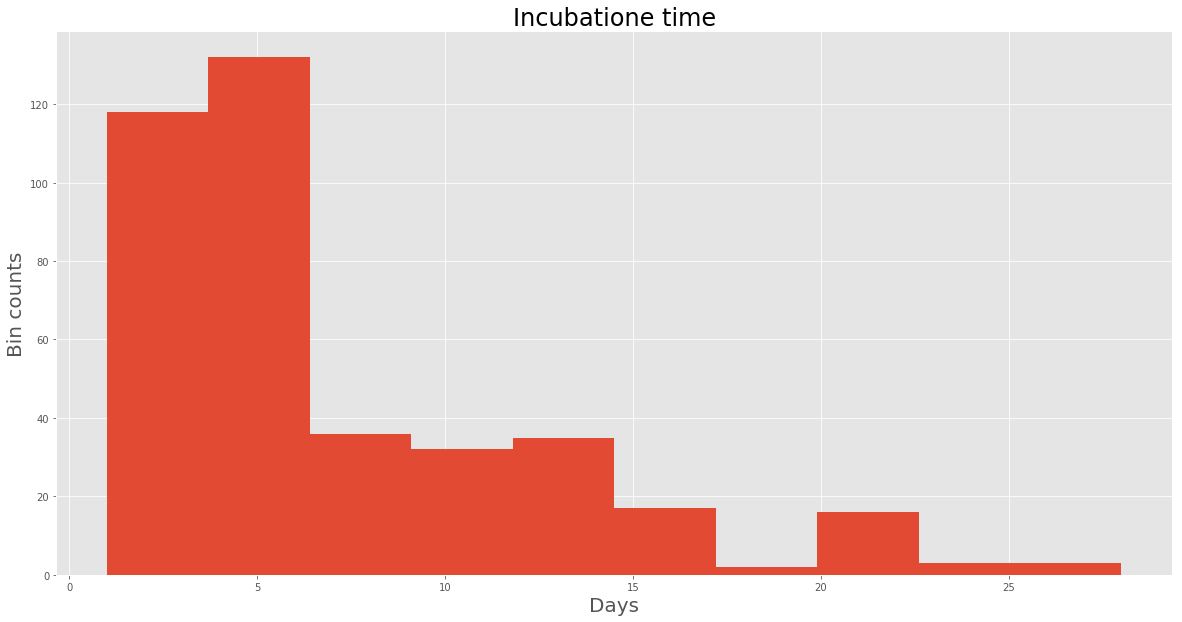

In [41]:
plt.figure(figsize=(20,10))
plt.hist(inc_time)
plt.title('Incubatione time', fontsize=24)
plt.ylabel('Bin counts', fontsize=20)
plt.xlabel('Days', fontsize=20);

# Create df for non commercial articles

In [42]:
directory = ['noncomm_use_subset']

In [43]:
df_non_comm = create_df_text(directory)

0 10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350 360 370 380 390 400 410 420 430 440 450 460 470 480 490 500 510 520 530 540 550 560 570 580 590 600 610 620 630 640 650 660 670 680 690 700 710 720 730 740 750 760 770 780 790 800 810 820 830 840 850 860 870 880 890 900 910 920 930 940 950 960 970 980 990 1000 1010 1020 1030 1040 1050 1060 1070 1080 1090 1100 1110 1120 1130 1140 1150 1160 1170 1180 1190 1200 1210 1220 1230 1240 1250 1260 1270 1280 1290 1300 1310 1320 1330 1340 1350 1360 1370 1380 1390 1400 1410 1420 1430 1440 1450 1460 1470 1480 1490 1500 1510 1520 1530 1540 1550 1560 1570 1580 1590 1600 1610 1620 1630 1640 1650 1660 1670 1680 1690 1700 1710 1720 1730 1740 1750 1760 1770 1780 1790 1800 1810 1820 1830 1840 1850 1860 1870 1880 1890 1900 1910 1920 1930 1940 1950 1960 1970 1980 1990 2000 2010 2020 2030 2040 2050 2060 2070 2080 2090 2100 2110 2120 2130 2140 2150 2160 2170 2180 2190 2200 2210 2

In [44]:
df_non_comm.head()

,title,abstract,full_text
0,The fecal microbiota and unconjugated fecal bi...,and Blautia (P = 0.008) significantly decrease...,human type 1 DM. The aim of this study was to ...
1,Development of a smartphone-based rapid dual f...,Accurate and rapid diagnosis of highly pathoge...,Avian influenza (AI) viruses are distinct from...
2,Dromedary camels in northern Mali have high se...,A high percentage (up to 90%) of dromedary cam...,Dromedary camels (Camelus dromedarius) appear ...
3,Regulated Export of a Secretory Protein from t...,"253 protein, C-reactive protein (CRPt), varies...",Abstract. The half-time for secretion of the p...
4,,,This is an Open Access article distributed und...


In [45]:
df_non_comm.isnull().any()

title        False
abstract     False
full_text    False
dtype: bool

# Check articles that contain the word incubation

In [46]:
incubation = df_non_comm[df_non_comm['full_text'].str.contains('incubation')]
incubation.head()

,title,abstract,full_text
0,The fecal microbiota and unconjugated fecal bi...,and Blautia (P = 0.008) significantly decrease...,human type 1 DM. The aim of this study was to ...
3,Regulated Export of a Secretory Protein from t...,"253 protein, C-reactive protein (CRPt), varies...",Abstract. The half-time for secretion of the p...
5,ULK1/2 Restricts the Formation of Inducible SI...,,Spatial and temporal organization of cellular ...
13,Structure-based identification of functional r...,Bluetongue virus (BTV) encodes a single cappin...,Eukaryotic cellular and most viral messenger R...
14,Comparative Evaluation of Three Homogenization...,Background: Real-time reverse transcription PC...,irrespective of the length of time between sym...


Let's write a regex for capture digits followed by the word day and save in a list.

In [47]:
incubation_time = []
texts = incubation['full_text'].values

for text in texts:
    for sentence in text.split(". "):
        if "incubation" in sentence:
            single_day = re.findall(r'( \d{1,2}(\.\d{1,2})? day[s]?)', sentence)
            
            if len(single_day) == 1:
                num = single_day[0][0].split(" ")
                incubation_time.append(float(num[1]))

In [48]:
print(len(incubation_time))
print(incubation_time, end=' ')

84
[14.0, 7.0, 5.0, 3.6, 14.0, 14.0, 5.2, 2.0, 28.0, 7.0, 14.0, 14.0, 5.0, 18.0, 28.0, 2.0, 8.0, 49.0, 4.0, 6.0, 13.0, 5.0, 5.0, 14.0, 2.0, 4.0, 6.0, 5.0, 5.0, 2.0, 5.0, 3.0, 6.0, 5.0, 7.0, 10.0, 7.0, 21.0, 12.0, 3.0, 14.0, 5.0, 14.0, 7.0, 4.0, 21.0, 14.0, 2.0, 4.0, 5.2, 5.0, 5.0, 4.0, 14.0, 1.0, 1.0, 7.0, 21.0, 5.0, 6.83, 14.0, 20.0, 2.0, 4.0, 5.2, 2.0, 17.0, 3.0, 6.0, 5.0, 4.0, 21.0, 14.0, 6.0, 28.0, 10.0, 17.0, 3.0, 5.0, 4.0, 15.0, 5.2, 5.2, 4.0] 

I'm assuming that values over 30 are outliers so I'm gonna remove them.

In [49]:
inc_time = [i for i in incubation_time if i < 30]

In [50]:
df_inc = pd.DataFrame(inc_time, columns=['Incubation days'])
df_inc.head()

,Incubation days
0,14.0
1,7.0
2,5.0
3,3.6
4,14.0


In [51]:
df_inc.describe()

,Incubation days
count,83.000000
mean,8.655783
std,6.609523
min,1.000000
25%,4.000000
50%,5.200000
75%,14.000000
max,28.000000


### The mean of the non commercial articles for the incubation days is 9 days.

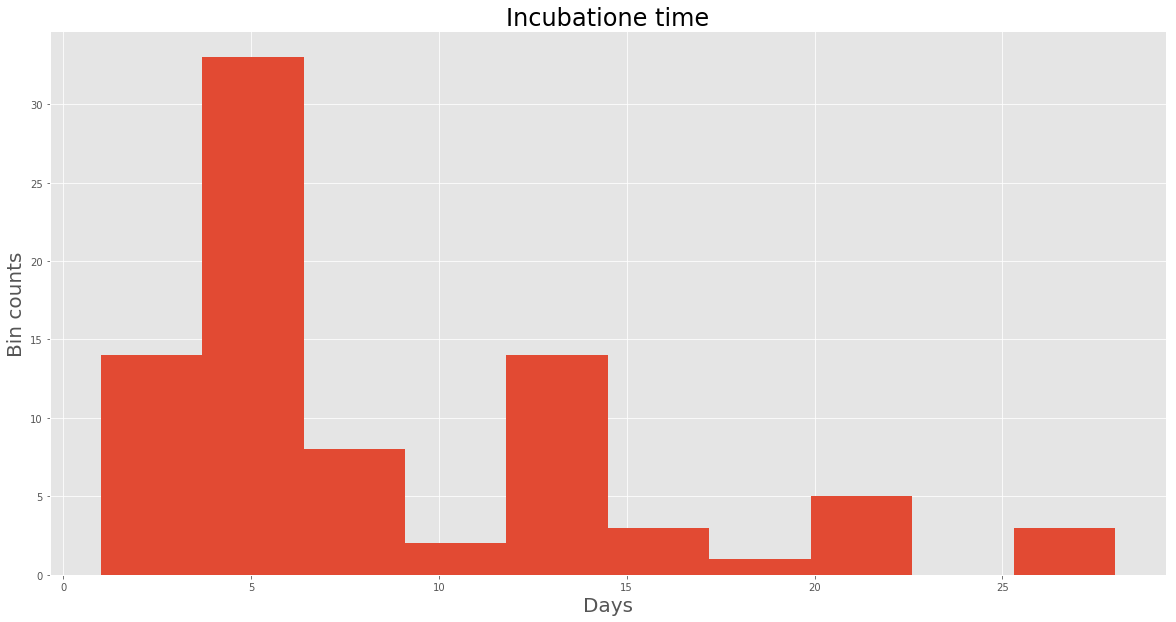

In [52]:
plt.figure(figsize=(20,10))
plt.hist(inc_time)
plt.title('Incubatione time', fontsize=24)
plt.ylabel('Bin counts', fontsize=20)
plt.xlabel('Days', fontsize=20);

# Preprocessing the Data

# Stopword and punctualization

In [53]:
# Get all the stop words in the English language
stopwords_list = stopwords.words('english')
stopwords_list = stopwords_list + ['the', 'a', 'in', 'al', 'c', 'et','e', 'study', 'virus', 'b','p', 
                      'using', 'also', 'infection', 'cell', 'h', 'n', 'protein']

In [54]:
# Now we have a list that includes all english stopwords, as well as all punctuation
stopwords_list += list(string.punctuation)

# Tokenizing our Data

In [55]:
def tokenize(text):
    joined_text = ' '.join(text)
    tokenized_text = word_tokenize(joined_text)
    pattern = "([a-zA-Z]+(?:'[a-z]+)?)"
    text_tokens_raw = nltk.regexp_tokenize(str(tokenized_text), pattern)
    stopped_tokens = [w.lower() for w in text_tokens_raw if w not in stopwords_list]
    
    return stopped_tokens

In [56]:
full_txt_list = []
for x in df_non_comm['full_text']:
    full_txt_list.append(x)

In [57]:
tokenized_full_txt = tokenize(full_txt_list)

In [58]:
tokenized_full_txt[:10]

['human',
 'type',
 'dm',
 'the',
 'aim',
 'evaluate',
 'changes',
 'fecal',
 'microbiota',
 'fecal']

# Count Vectorization.

In [59]:
def count_vectorize(text, vocab=None):
    if vocab:
        unique_words = vocab
    else:
        unique_words = list(set(text))
    
    txt_dict = {i:0 for i in unique_words}
    
    for word in text:
        txt_dict[word] += 1
    
    return txt_dict

In [60]:
test_vectorized = count_vectorize(tokenized_full_txt)
print(test_vectorized)

{'fly': 37, 'photophobia': 6, 'slanted': 1, 'statin': 16, 'extrahelical': 2, 'nobivac': 5, 'antidiabetic': 29, 'clustalx': 18, 'tgama': 8, 'vulgare': 1, 'thrombography': 1, 'esempi': 5, 'penetrability': 1, 'indetermination': 1, 'mimetism': 1, 'postdiagnosis': 3, 'cpipj': 1, 'adjectives': 1, 'restriction': 728, 'largo': 11, 'wilms': 1, 'whitton': 3, 'dexter': 1, 'repolarize': 2, 'djk': 1, 'glycocalyces': 1, 'emerge': 215, 'parker': 17, 'rotavec': 1, 'ivd': 19, 'accettata': 2, 'torresilla': 1, 'mura': 2, 'decoction': 12, 'beall': 5, 'letale': 1, 'repairs': 4, 'lithotripsy': 2, 'kepplinger': 2, 'stolk': 1, 'weev': 5, 'intubazione': 1, 'trichostatin': 5, 'novavax': 2, 'artificiality': 1, "dell'albero": 1, 'nhsbiotin': 3, 'adjecent': 1, 'safe': 599, 'logistical': 37, 'unvanquished': 1, 'saudita': 4, 'predicated': 8, 'phytochrome': 1, 'microsource': 2, 'steadystate': 8, 'recurred': 10, 'rivalutare': 2, 'mukaisho': 2, 'acuucc': 24, 'unknowingly': 5, "dell'accettabilit": 1, 'fluoresced': 1, 'f

# Get the 50 most common words 

In [61]:
freqdist = FreqDist(tokenized_full_txt)

# get the 50 most common words 
most_common = freqdist.most_common(50)
print(most_common[:20], end = ' ')

[('the', 63219), ('cells', 34594), ('a', 30240), ('in', 26343), ('c', 22125), ('patients', 17070), ('may', 16270), ('used', 16151), ('data', 16041), ('s', 15526), ('viral', 14893), ('b', 14453), ('g', 14236), ('disease', 14175), ('fig', 13761), ('one', 13150), ('health', 12722), ('this', 12688), ('p', 12485), ('two', 12436)] 

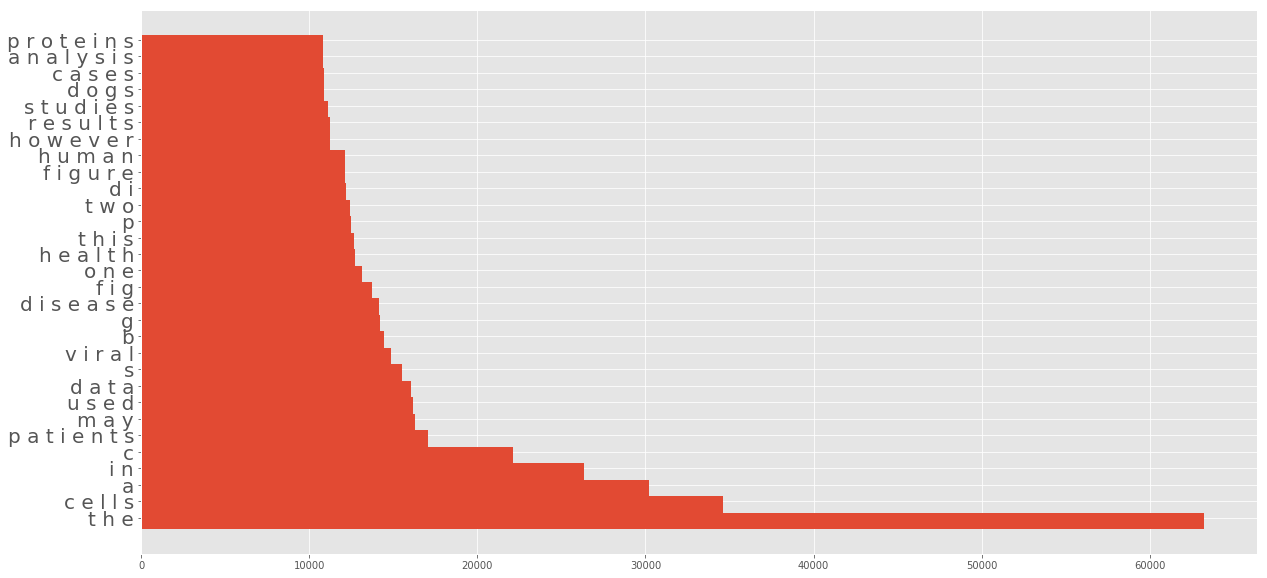

In [62]:
num_to_show = 30

labels = [" ".join(e[0]) for e in freqdist.most_common(num_to_show)]
values = [e[1] for e in freqdist.most_common(num_to_show)]

indexes = np.arange(len(labels))
width = 1
plt.figure(figsize=(20,10))
plt.barh(indexes, values, width)
plt.yticks(indexes + width * 0.2, labels, fontsize=20)
plt.show()

# Normalized Word Frequency

In [63]:
total_word_count = sum(freqdist.values())
titles_top_200 = freqdist.most_common(200)
print('Word\t\t\tNormalized Frequency')
for word in titles_top_200:
    normalized_frequency = word[1] / total_word_count
    print('{} \t\t\t {:.4}'.format(word[0], normalized_frequency))

Word			Normalized Frequency
the 			 0.01051
cells 			 0.00575
a 			 0.005026
in 			 0.004378
c 			 0.003677
patients 			 0.002837
may 			 0.002704
used 			 0.002684
data 			 0.002666
s 			 0.002581
viral 			 0.002475
b 			 0.002402
g 			 0.002366
disease 			 0.002356
fig 			 0.002287
one 			 0.002186
health 			 0.002114
this 			 0.002109
p 			 0.002075
two 			 0.002067
di 			 0.002024
figure 			 0.002021
human 			 0.002014
however 			 0.001869
results 			 0.001863
studies 			 0.001851
dogs 			 0.001807
cases 			 0.001805
analysis 			 0.001801
proteins 			 0.001794
n 			 0.001783
t 			 0.00178
time 			 0.001762
h 			 0.00176
clinical 			 0.001739
treatment 			 0.00173
group 			 0.001692
rna 			 0.001684
expression 			 0.001674
viruses 			 0.001674
high 			 0.001631
we 			 0.00163
based 			 0.001629
control 			 0.001619
l 			 0.001586
different 			 0.001576
number 			 0.001565
respiratory 			 0.001537
reported 			 0.001531
specific 			 0.001529
cov 			 0.001527
influenza 			 0.001512
wel

# Bigrams

In [65]:
bigram_measures = nltk.collocations.BigramAssocMeasures()
title_finder = BigramCollocationFinder.from_words(tokenized_full_txt)
title_scored = title_finder.score_ngrams(bigram_measures.raw_freq)
title_scored[:50]

[(('mers', 'cov'), 0.0009244411469053659),
 (('h', 'n'), 0.0007944675804041081),
 (('in', 'addition'), 0.0006425547418080087),
 (('t', 'cells'), 0.0005188970263643568),
 (('public', 'health'), 0.0005104204894186226),
 (('sars', 'cov'), 0.0004731902095001037),
 (('fig', 'a'), 0.00037330003882586334),
 (('wild', 'type'), 0.00030033533844983754),
 (('figure', 'a'), 0.0002966787931006973),
 (('fig', 'b'), 0.000291360181683766),
 (('in', 'contrast'), 0.00027324366154484386),
 (('cd', 't'), 0.00025894989336184106),
 (('amino', 'acid'), 0.0002579526537211665),
 (('infectious', 'diseases'), 0.00025778644711438737),
 (('a', 'b'), 0.0002471492242805248),
 (('rt', 'pcr'), 0.0002471492242805248),
 (('for', 'example'), 0.00024631819124662935),
 (('influenza', 'a'), 0.00024631819124662935),
 (('mg', 'kg'), 0.00024615198463985024),
 (('figure', 's'), 0.00024083337322291896),
 (('real', 'time'), 0.00023002994378227732),
 (('fig', 's'), 0.00022604098521957888),
 (('figure', 'b'), 0.00021822927470096108

# Pointwise Mutual Information

In [66]:
title_finder.apply_freq_filter(5)
title_pmi_scored = title_finder.score_ngrams(bigram_measures.pmi)
title_pmi_scored

[(('amini', 'bavil'), 20.19859083837114),
 (('bavil', 'olyaee'), 20.19859083837114),
 (('bushy', 'stunt'), 20.19859083837114),
 (('cyd', 'tdv'), 20.19859083837114),
 (('fiume', 'sarno'), 20.19859083837114),
 (('livak', 'schmittgen'), 20.19859083837114),
 (('mescher', 'strominger'), 20.19859083837114),
 (('messier', 'solek'), 20.19859083837114),
 (('oncorhynchus', 'mykiss'), 20.19859083837114),
 (('phar', 'mingen'), 20.19859083837114),
 (('putorius', 'furo'), 20.19859083837114),
 (('rodr', 'guez'), 20.19859083837114),
 (('sooty', 'mangabeys'), 20.19859083837114),
 (('traffi', 'cking'), 20.19859083837114),
 (('zuba', 'surma'), 20.19859083837114),
 (('addis', 'ababa'), 19.935556432537346),
 (('avocado', 'sunblotch'), 19.935556432537346),
 (('ewha', 'womans'), 19.935556432537346),
 (('guillen', 'servent'), 19.935556432537346),
 (('ibt', 'bioservices'), 19.935556432537346),
 (('infi', 'ltrating'), 19.935556432537346),
 (('kolaskar', 'tongaonkar'), 19.935556432537346),
 (('maupin', 'furlow')

# TF-IDF Vectorization

If the word is used often in many other documents, it is not unique, and therefore probably not too useful if we wanted to figure out how this document is unique in relation to other documents. Conversely, if a word is used many times in a document, but rarely in all the other documents we are considering, then it is likely a good indicator for telling us that this word is important to the document in question.

# TF

In [67]:
def term_frequency(BoW_dict):
    total_word_count = sum(BoW_dict.values())
    
    for ind, val in BoW_dict.items():
        BoW_dict[ind] = val/ total_word_count
    
    return BoW_dict

In [68]:
test = term_frequency(test_vectorized)
print(list(test)[:20])

['fly', 'photophobia', 'slanted', 'statin', 'extrahelical', 'nobivac', 'antidiabetic', 'clustalx', 'tgama', 'vulgare', 'thrombography', 'esempi', 'penetrability', 'indetermination', 'mimetism', 'postdiagnosis', 'cpipj', 'adjectives', 'restriction', 'largo']


# IDF

In [69]:
def inverse_document_frequency(list_of_dicts):
    vocab_set = set()
    
    # Iterate through list of dfs and add index to vocab_set
    for d in list_of_dicts:
        for word in d.keys():
            vocab_set.add(word)
    
    # Once vocab set is complete, create an empty dictionary with a key for each word and value of 0.
    full_vocab_dict = {i:0 for i in vocab_set}
    
    # Loop through each word in full_vocab_dict
    for word, val in full_vocab_dict.items():
        docs = 0
        
        # Loop through list of dicts.  Each time a dictionary contains the word, increment docs by 1
        for d in list_of_dicts:
            if word in d:
                docs += 1
        
        # Now that we know denominator for equation, compute and set IDF value for word
        
        full_vocab_dict[word] = np.log((len(list_of_dicts)/ float(docs)))
    
    return full_vocab_dict

# Computing TF-IDF

In [70]:
def tf_idf(list_of_dicts):
    # Create empty dictionary containing full vocabulary of entire corpus
    doc_tf_idf = {}
    idf = inverse_document_frequency(list_of_dicts)
    full_vocab_list = {i:0 for i in list(idf.keys())}
    
    # Create tf-idf list of dictionaries, containing a dictionary that will be updated for each document
    tf_idf_list_of_dicts = []
    
    # Now, compute tf and then use this to compute and set tf-idf values for each document
    for doc in list_of_dicts:
        doc_tf = term_frequency(doc)
        for word in doc_tf:
            doc_tf_idf[word] = doc_tf[word] * idf[word]
        tf_idf_list_of_dicts.append(doc_tf_idf)
    
    return tf_idf_list_of_dicts

# Vectorizing All Documents

In [71]:
count_vectorized_all_documents = []
count_vectorized_all_documents.append(test_vectorized)

In [72]:
tf_idf_all_docs = tf_idf(count_vectorized_all_documents)
print(list(tf_idf_all_docs[0])[:20])

['fly', 'photophobia', 'slanted', 'statin', 'extrahelical', 'nobivac', 'antidiabetic', 'clustalx', 'tgama', 'vulgare', 'thrombography', 'esempi', 'penetrability', 'indetermination', 'mimetism', 'postdiagnosis', 'cpipj', 'adjectives', 'restriction', 'largo']


In [73]:
num_dims = len(tf_idf_all_docs[0])
print("Number of Dimensions: {}".format(num_dims))

Number of Dimensions: 115271


# Sentiment analysis title sentences

In [74]:
title_list = []
for x in df_non_comm['title']:
    title_list.append(x)

In [75]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\luigi\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [76]:
sid = SentimentIntensityAnalyzer()

In [77]:
compound_list = []
for x in title_list:
    ss = sid.polarity_scores(x)
    compound_list.append(ss['compound'])

In [78]:
compound_list

[0.6486,
 0.0,
 0.0,
 0.0,
 0.0,
 -0.3182,
 0.0,
 0.0,
 0.2732,
 0.0,
 0.0,
 -0.296,
 -0.2732,
 0.0,
 0.0,
 0.0,
 0.0,
 0.5574,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.4215,
 -0.6705,
 -0.1027,
 0.0,
 0.0,
 0.2732,
 0.0,
 -0.765,
 -0.5267,
 0.0,
 0.0,
 0.0516,
 0.34,
 0.4939,
 0.0772,
 0.0,
 0.0,
 0.0,
 0.0,
 -0.296,
 -0.4939,
 0.0,
 -0.2732,
 -0.2732,
 0.296,
 0.0,
 0.0258,
 0.0,
 -0.4404,
 -0.5994,
 0.0,
 0.0,
 0.0,
 0.0516,
 0.5106,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.5267,
 0.3182,
 0.0,
 0.0,
 -0.3612,
 0.0,
 0.4404,
 0.0,
 -0.2732,
 0.296,
 0.0,
 0.0,
 -0.0772,
 0.0,
 0.0,
 -0.4215,
 0.4939,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 -0.4019,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 -0.2732,
 0.0,
 0.0,
 -0.7944,
 -0.2732,
 0.296,
 -0.5106,
 -0.4019,
 -0.3818,
 0.0,
 0.0,
 0.296,
 0.0,
 0.0,
 -0.2732,
 -0.4019,
 0.0,
 0.0,
 0.0,
 0.0,
 -0.6597,
 0.0516,
 0.4019,
 0.0,
 0.0,
 0.0,
 -0.0516,
 -0.128,
 0.0,
 0.0,
 0.0,
 0.0258,
 0.

In [79]:
df_title_compound = pd.DataFrame(title_list,columns=['title'])
df_title_compound.head()

,title
0,The fecal microbiota and unconjugated fecal bi...
1,Development of a smartphone-based rapid dual f...
2,Dromedary camels in northern Mali have high se...
3,Regulated Export of a Secretory Protein from t...
4,


In [80]:
df_title_compound['compound'] = compound_list
df_title_compound.head()

,title,compound
0,The fecal microbiota and unconjugated fecal bi...,0.6486
1,Development of a smartphone-based rapid dual f...,0.0000
2,Dromedary camels in northern Mali have high se...,0.0000
3,Regulated Export of a Secretory Protein from t...,0.0000
4,,0.0000


In [81]:
df_title_compound['compound'].describe()

count    2353.000000
mean       -0.005235
std         0.255643
min        -0.895700
25%         0.000000
50%         0.000000
75%         0.000000
max         0.915300
Name: compound, dtype: float64

In [82]:
df_title_compound.isnull().any()

title       False
compound    False
dtype: bool

In [83]:
target_list = []
for x in df_title_compound['compound']:
    if x < -.25:
        target_list.append(-1)
    elif x > .25:
        target_list.append(1)
    else: 
        target_list.append(0)

In [84]:
df_title_compound['target'] = target_list
df_title_compound.head(20)

,title,compound,target
0,The fecal microbiota and unconjugated fecal bi...,0.6486,1
1,Development of a smartphone-based rapid dual f...,0.0000,0
2,Dromedary camels in northern Mali have high se...,0.0000,0
3,Regulated Export of a Secretory Protein from t...,0.0000,0
4,,0.0000,0
5,ULK1/2 Restricts the Formation of Inducible SI...,-0.3182,-1
6,,0.0000,0
7,Glycosylation of the HIV-1 Env V1V2 loop to fo...,0.0000,0
8,Evaluation of acute and sublethal effects of c...,0.2732,1
9,Pandemic influenza in Papua New Guinea: a mode...,0.0000,0


In [85]:
import seaborn as sns

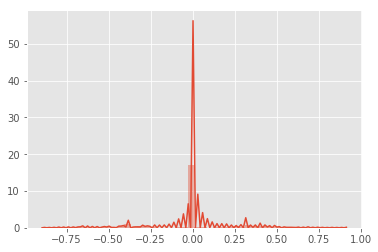

In [86]:
sns.distplot(compound_list);

# word_cloud

In [87]:
neg_title = df_title_compound[df_title_compound['target'] == -1]
neg_title.head()

,title,compound,target
5,ULK1/2 Restricts the Formation of Inducible SI...,-0.3182,-1
11,Three cases of idiopathic eosinophilic enterit...,-0.2960,-1
12,Potential risk of viral transmission from flyi...,-0.2732,-1
30,Statins May Decrease the Fatality Rate of Midd...,-0.6705,-1
36,"The Applied Health Research Centre Mason, Dala...",-0.7650,-1


In [88]:
neg_string = []
for t in neg_title['title']:
    neg_string.append(t)
neg_string

['ULK1/2 Restricts the Formation of Inducible SINT- Speckles, Membraneless Organelles Controlling the Threshold of TBK1 Activation',
 'Three cases of idiopathic eosinophilic enteritis with chronic obstinate diarrhea in Japanese Black fattening cattle',
 'Potential risk of viral transmission from flying foxes to domestic animals and humans on the southern coast of West Java, Indonesia',
 'Statins May Decrease the Fatality Rate of Middle East Respiratory Syndrome Infection',
 'The Applied Health Research Centre Mason, Dalah; Hospital for Sick Children, Child Health Evaluative Sciences Kowal, Christine; Hospital for Sick Children',
 'Risk Management and Healthcare Policy Dovepress Critical role of ethics in clinical management and public health response to the West Africa Ebola epidemic',
 'An Appropriate Lower Respiratory Tract Specimen Is Essential for Diagnosis of Middle East Respiratory Syndrome (MERS)',
 'Quantitative Proteomic Analysis of A549 Cells Infected with Human Respiratory S

# Negative sentiment

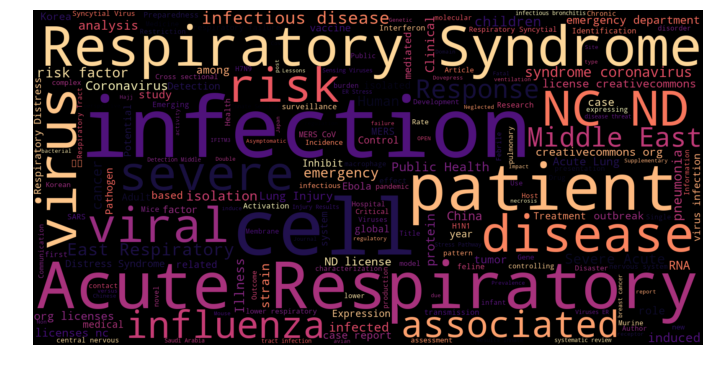

In [89]:
neg_title = df_title_compound[df_title_compound['target'] == -1]
neg_string = []
for t in neg_title['title']:
    neg_string.append(t)
neg_string = pd.Series(neg_string).str.cat(sep=' ')

wordcloud = WordCloud(width=1600, height=800,max_font_size=200,colormap='magma').generate(neg_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

# Positive sentiment

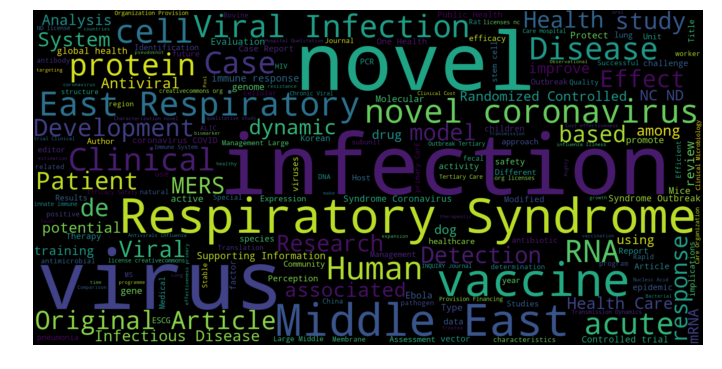

In [90]:
pos_title = df_title_compound[df_title_compound['target'] == 1]
pos_string = []
for t in pos_title['title']:
    pos_string.append(t)
pos_string = pd.Series(pos_string).str.cat(sep=' ')

wordcloud = WordCloud(width=1600, height=800,max_font_size=200).generate(pos_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

# Neutral sentiment

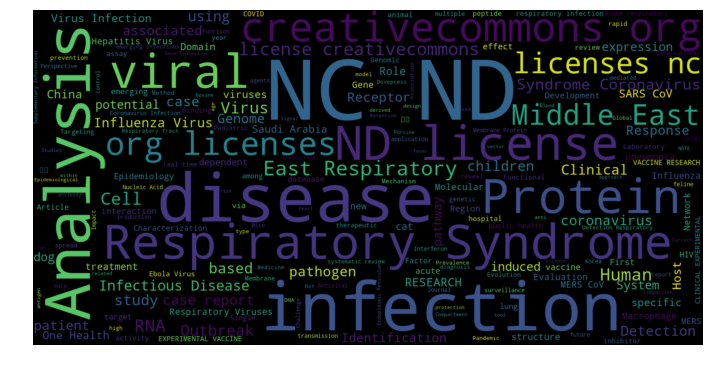

In [91]:
neut_title = df_title_compound[df_title_compound['target'] == 0]
neut_string = []
for t in neut_title['title']:
    neut_string.append(t)
neut_string = pd.Series(neut_string).str.cat(sep=' ')

wordcloud = WordCloud(width=1600, height=800,max_font_size=200).generate(neut_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

# Sentiment analysis words

In [92]:
sid = SentimentIntensityAnalyzer()

In [93]:
list_x = []
for x in most_common:
    print(x[0])

the
cells
a
in
c
patients
may
used
data
s
viral
b
g
disease
fig
one
health
this
p
two
di
figure
human
however
results
studies
dogs
cases
analysis
proteins
n
t
time
h
clinical
treatment
group
rna
expression
viruses
high
we
based
control
l
different
number
respiratory
reported
specific


In [94]:
comp_word_list = []
for x in most_common:
    ss = sid.polarity_scores(x[0])
    comp_word_list.append(ss['compound'])

In [95]:
comp_word_list

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0772,
 0.0,
 0.0,
 0.0]

# What is known about transmission?

In [96]:
df = pd.DataFrame(full_txt_list, columns=['full_text'])
df.head(20)

,full_text
0,human type 1 DM. The aim of this study was to ...
1,Avian influenza (AI) viruses are distinct from...
2,Dromedary camels (Camelus dromedarius) appear ...
3,Abstract. The half-time for secretion of the p...
4,This is an Open Access article distributed und...
5,Spatial and temporal organization of cellular ...
6,Coronaviruses have in the past been known to b...
7,The only surface protein of human immunodefici...
8,"Quinoline is known for its bactericidal, antis..."
9,Novel influenza virus strains have resulted in...


In [97]:
transmission = df[df['full_text'].str.contains('transmission')]
len(transmission)

792

In [98]:
transm_text = transmission.full_text.values

In [99]:
transm_list = []
for t in transm_text:
    if 'transmission' in t:
        transm_list.append(t)

In [100]:
for t in transm_text:
    if 'transmission' in t:
        transm_list.append(t)

# NLP-architect